In [1]:
# Curate dataset and analysis features

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdDetermineBonds

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
import os

import joblib
import json


In [ ]:
from ase.io import read, write

In [ ]:
os.listdir('.')

# The raw QM9 dataset - cleaning

In [3]:
from openbabel import pybel

def xyz_to_smiles_pybel(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

def xyz_to_smiles_rdk(fname):
    m = Chem.Mol( Chem.MolFromXYZFile(fname) )
    rdDetermineBonds.DetermineBonds(m,charge=0)
    smi = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)  # m or Chem.RemoveHs(m)
    return smi

In [ ]:
def screen_qm9_raw(filename, filename_xyz_clean):
    if '1000.xyz' in filename:
        print( filename )
    
    with open(filename, 'r') as f1:
        lines = f1.readlines()
        natom = int(lines.pop(0))
        au2ev = 27.2107
        line = lines.pop(0).split()
        homo,lumo = float(line[7])*au2ev, float(line[8])*au2ev
        smiles = lines[natom+1].split()[1]
        inchi  = lines[natom+2].split()[1]
        output = [filename, homo, lumo, smiles, inchi]
        
    coord_lines = []
    for l in lines[:natom]:
        l = l.replace('*^','E').split()[:4]
        l = [l[0]] + [ str(np.around(float(c),3)) for c in l[1:] ]
        coord_lines.append( '  '.join(l) )

    with open(filename_xyz_clean, 'w') as f1:
        f1.write( str(natom)+'\n\n')
        for line in coord_lines:
            f1.write( line + '\n' )
    try:
        smi_rdk = xyz_to_smiles_rdk(filename_xyz_clean)
    except:
        #print('Issue:',filename)
        smi_rdk = None
        
    try:    
        smi_pybel = xyz_to_smiles_pybel(filename_xyz_clean)
    except:
        smi_pybel = None
        
    output.append(smi_pybel) 
    output.append(smi_rdk) 
    
    return output

jobdir = '../QM9 dataset/dsgdb9nsd.xyz/'
new_xyz = '../QM9 dataset/clean_xyz/'
qm9_raw = [ [os.path.join(jobdir,x),os.path.join(new_xyz,x)] for x in os.listdir(jobdir) if '.xyz' in x]

data = [ screen_qm9_raw( q[0],q[1] ) for q in qm9_raw[:] ]

df_qm9_raw = pd.DataFrame(data, columns=['name','HOMO','LUMO','SMILES','INCHI','SMILES_pybel','SMILES_rdk'])
#df_qm9_raw.to_csv('df_qm9_raw.csv')
#df_qm9_raw

In [17]:
df_qm9_raw.to_csv('df_qm9_raw.csv')


In [18]:
df_qm9_raw

name       HOMO  \
0       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000001.xyz -10.549588   
1       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz  -6.993150   
2       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000003.xyz  -7.967293   
3       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000004.xyz  -7.741444   
4       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000005.xyz  -9.806736   
...                                                   ...        ...   
133880  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133881.xyz  -6.133292   
133881  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133882.xyz  -6.511521   
133882  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133883.xyz  -6.076149   
133883  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133884.xyz  -5.774111   
133884  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133885.xyz  -6.301998   

            LUMO                                          SMILES  \
0       3.186373                                               C   
1       2.255767                                               N   
2       1.869375                                               O   
3       1.376861                                             C#C   
4       0.519724                                             C#N   
...          ...                                             ...   
133880  1.599989  C1[C@@H]2[C@@H]3[C@H]4[C@@H]5O[C@]14[C@@H]5N23   
133881  1.654411  C1N2[C@H]3[C@@H]2[C@@H]2[C@H]4O[C@@]12[C@@H]34   
133882  1.959170       C1N2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13CN45   
133883  2.397263    C1N2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   
133884  2.019034    C1N2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@H]45   

                                                    INCHI  \
0                                       InChI=1S/CH4/h1H4   
1                                       InChI=1S/H3N/h1H3   
2                                       InChI=1S/H2O/h1H2   
3                                InChI=1S/C2H2/c1-2/h1-2H   
4                                   InChI=1S/CHN/c1-2/h1H   
...                                                   ...   
133880  InChI=1S/C7H7NO/c1-2-4-3-5-6(8(2)4)7(1,3)9-5/h...   
133881  InChI=1S/C7H7NO/c1-7-2-4-5(8(1)4)3(7)6(2)9-7/h...   
133882  InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...   
133883  InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...   
133884  InChI=1S/C7H7NO/c1-7-5-2-3(4(2)9-7)6(7)8(1)5/h...   

                                             SMILES_pybel  \
0                                                       C   
1                                                       N   
2                                                       O   
3                                                     C#C   
4                                                     C#N   
...                                                   ...   
133880  C1[C@@H]2[C@@H]3[C@H]4[C@@H]5O[C@]14[C@@H]5[N@]23   
133881  C1[N@@]2[C@H]3[C@@H]2[C@@H]2[C@H]4O[C@@]12[C@@...   
133882    C1[N@]2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13C[N@]45   
133883   C1[N@@]2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   
133884   C1[N@@]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@H]45   

                                               SMILES_rdk  
0                                       [H]C([H])([H])[H]  
1                                            [H]N([H])[H]  
2                                                 [H]O[H]  
3                                               [H]C#C[H]  
4                                                  [H]C#N  
...                                                   ...  
133880                                               None  
133881                                               None  
133882  [H]C1([H])N2[C@@]3([H])[C@]2([H])[C@]2([H])N4C...  
133883  [H]C1([H])N2[C@@]3([H])[C@@]14C([H])([H])[C@]1...  
133884                                               None  

[133885 rows x 7 columns]

In [21]:
%%capture --no-display

mask_is_good = []
"""
## check the bad SMILES and INCHI
## Remove complex
for s1,c,s2 in zip(df_qm9_raw['SMILES'],df_qm9_raw['INCHI'],df_qm9_raw['SMILES_pybel']):
    try:
        mol1 = Chem.MolFromSmiles(s1)
        mol2 = Chem.MolFromSmiles(s2)
        #mol3 = Chem.MolFromInchi(c)
        #s = Chem.MolToSmiles(mol3)
        if mol1 is None or mol2 is None:
            mask = False
        else:
            mask =True
    except:
        mask =False
    if '.' in s1 or '.' in s2: ## keep non-complex
        mask = False
    mask_is_good.append( mask )
"""

for s in df_qm9_raw['SMILES_rdk']:
    if s is None:
        mask = False
    elif '.' in s:
        mask = False
    else:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol is None:
                mask = False
            else:
                mask = True
        except:
            mask = False
        
    mask_is_good.append( mask )
    
df_qm9_valid = df_qm9_raw[mask_is_good]
#df_qm9_valid.to_csv('df_qm9_valid.csv')
df_qm9_valid

name       HOMO  \
0       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000001.xyz -10.549588   
1       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz  -6.993150   
2       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000003.xyz  -7.967293   
3       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000004.xyz  -7.741444   
4       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000005.xyz  -9.806736   
...                                                   ...        ...   
133864  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133865.xyz  -3.605418   
133865  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133866.xyz  -4.285685   
133872  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133873.xyz  -5.676152   
133882  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133883.xyz  -6.076149   
133883  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133884.xyz  -5.774111   

            LUMO                                        SMILES  \
0       3.186373                                             C   
1       2.255767                                             N   
2       1.869375                                             O   
3       1.376861                                           C#C   
4       0.519724                                           C#N   
...          ...                                           ...   
133864 -1.466657                 C1[C@H]2CN3C[CH]O[C@@H]1[C]23   
133865 -2.046245           C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872  2.242162            C1N2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882  1.959170     C1N2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13CN45   
133883  2.397263  C1N2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                                    INCHI  \
0                                       InChI=1S/CH4/h1H4   
1                                       InChI=1S/H3N/h1H3   
2                                       InChI=1S/H2O/h1H2   
3                                InChI=1S/C2H2/c1-2/h1-2H   
4                                   InChI=1S/CHN/c1-2/h1H   
...                                                   ...   
133864  InChI=1S/C7H9NO/c1-2-9-6-3-5-4-8(1)7(5)6/h2,5-...   
133865  InChI=1S/C7H8O2/c1-2-8-5-3-6-7(5)4(1)9-6/h2,4-...   
133872  InChI=1S/C8H11N/c1-5-2-7-8(3-5)4-9(7)6(1)8/h5-...   
133882  InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...   
133883  InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...   

                                            SMILES_pybel  \
0                                                      C   
1                                                      N   
2                                                      O   
3                                                    C#C   
4                                                    C#N   
...                                                  ...   
133864                  C1[C@H]2C[N@]3C[CH]O[C@@H]1[C]23   
133865               C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872            C1[N@@]2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882   C1[N@]2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13C[N@]45   
133883  C1[N@@]2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                               SMILES_rdk  
0                                       [H]C([H])([H])[H]  
1                                            [H]N([H])[H]  
2                                                 [H]O[H]  
3                                               [H]C#C[H]  
4                                                  [H]C#N  
...                                                   ...  
133864  [H]C1=[O+][C@]2([H])[C-]3N(C1([H])[H])C([H])([...  
133865  [H]C1=[O+][C@@]2([H])[C-]3[C@]([H])(O[C@@]3([H...  
133872  [H]C1([H])N2[C@@]3([H])C([H])([H])[C@]4([H])C(...  
133882  [H]C1([H])N2[C@@]3([H])[C@]2([H])[C@]2([H])N4C...  
133883  [H]C1([H])N2[C@@]3([H])[C@@]14C([H])([H])[C@]1...  

[126817 rows x 7 columns]

In [24]:
%%capture --no-display

## Remove radical
def has_radical(smi):
    contains_radical = False
    mol = Chem.MolFromSmiles(smi)
    if any([True if atom.GetNumRadicalElectrons()>0 else False for atom in mol.GetAtoms() ]):
        contains_radical = True
    return contains_radical


mask_without_radical = []
for s1,s2 in zip(df_qm9_valid['SMILES_rdk'],df_qm9_valid['SMILES_pybel']):
    #mol = Chem.MolFromInchi(c)
    #s2 = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)
    try:
        #mask = not any([has_radical(s1), has_radical(s2)])
        mask = not has_radical(s1)
    except:
        mask = False
    mask_without_radical.append( mask )
    #print(s, s2, mask)

df_qm9_radical_removed = df_qm9_valid[mask_without_radical]
df_qm9_radical_removed.to_csv('df_qm9_radical_removed.csv')
df_qm9_radical_removed

name       HOMO  \
0       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000001.xyz -10.549588   
1       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz  -6.993150   
2       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000003.xyz  -7.967293   
3       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000004.xyz  -7.741444   
4       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000005.xyz  -9.806736   
...                                                   ...        ...   
133864  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133865.xyz  -3.605418   
133865  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133866.xyz  -4.285685   
133872  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133873.xyz  -5.676152   
133882  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133883.xyz  -6.076149   
133883  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133884.xyz  -5.774111   

            LUMO                                        SMILES  \
0       3.186373                                             C   
1       2.255767                                             N   
2       1.869375                                             O   
3       1.376861                                           C#C   
4       0.519724                                           C#N   
...          ...                                           ...   
133864 -1.466657                 C1[C@H]2CN3C[CH]O[C@@H]1[C]23   
133865 -2.046245           C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872  2.242162            C1N2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882  1.959170     C1N2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13CN45   
133883  2.397263  C1N2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                                    INCHI  \
0                                       InChI=1S/CH4/h1H4   
1                                       InChI=1S/H3N/h1H3   
2                                       InChI=1S/H2O/h1H2   
3                                InChI=1S/C2H2/c1-2/h1-2H   
4                                   InChI=1S/CHN/c1-2/h1H   
...                                                   ...   
133864  InChI=1S/C7H9NO/c1-2-9-6-3-5-4-8(1)7(5)6/h2,5-...   
133865  InChI=1S/C7H8O2/c1-2-8-5-3-6-7(5)4(1)9-6/h2,4-...   
133872  InChI=1S/C8H11N/c1-5-2-7-8(3-5)4-9(7)6(1)8/h5-...   
133882  InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...   
133883  InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...   

                                            SMILES_pybel  \
0                                                      C   
1                                                      N   
2                                                      O   
3                                                    C#C   
4                                                    C#N   
...                                                  ...   
133864                  C1[C@H]2C[N@]3C[CH]O[C@@H]1[C]23   
133865               C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872            C1[N@@]2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882   C1[N@]2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13C[N@]45   
133883  C1[N@@]2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                               SMILES_rdk  
0                                       [H]C([H])([H])[H]  
1                                            [H]N([H])[H]  
2                                                 [H]O[H]  
3                                               [H]C#C[H]  
4                                                  [H]C#N  
...                                                   ...  
133864  [H]C1=[O+][C@]2([H])[C-]3N(C1([H])[H])C([H])([...  
133865  [H]C1=[O+][C@@]2([H])[C-]3[C@]([H])(O[C@@]3([H...  
133872  [H]C1([H])N2[C@@]3([H])C([H])([H])[C@]4([H])C(...  
133882  [H]C1([H])N2[C@@]3([H])[C@]2([H])[C@]2([H])N4C...  
133883  [H]C1([H])N2[C@@]3([H])[C@@]14C([H])([H])[C@]1...  

[126806 rows x 7 columns]

In [25]:
## The structures with radicals
df_qm9_contain_radicals = df_qm9_valid[ [not t for t in mask_without_radical] ]
df_qm9_contain_radicals.to_csv('df_qm9_contain_radicals.csv')
df_qm9_contain_radicals

name      HOMO      LUMO  \
36994   ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_036995.xyz -5.599962 -1.654411   
36995   ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_036996.xyz -5.714247 -1.455772   
66510   ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_066511.xyz -5.474793 -0.802716   
133827  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133828.xyz -5.126496  0.095237   
133828  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133829.xyz -5.627173 -0.331971   
133832  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133833.xyz -5.251665 -0.285712   
133833  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133834.xyz -5.782274 -0.712920   
133845  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133846.xyz -5.121054  0.108843   
133846  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133847.xyz -5.616288 -0.315644   
133850  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133851.xyz -5.194523 -0.152380   
133851  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133852.xyz -5.684315 -0.563261   

                                                   SMILES  \
36994   [C@@H]12[C][C@@H]3[C@@H]4[C@H]2[C@@H]2[C@H]1N3...   
36995   [C@@H]12[C][C@@H]3N4[C@H]2[C@@H]2[C@H]1[C@H]3[...   
66510                           N[C][C@@H]1C[N][C]2C=CN12   
133827      C[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3C[C@@H]21   
133828      C[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3O[C@@H]21   
133832      O[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3C[C@@H]21   
133833      O[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3O[C@@H]21   
133845      C[C@@]12[C@H]3[C@@H]1[C@@H]1C[C@H]3[C][C@H]21   
133846      C[C@@]12[C@H]3[C@@H]1[C@@H]1O[C@H]3[C][C@H]21   
133850      O[C@@]12[C@H]3[C@@H]1[C@@H]1C[C@H]3[C][C@H]21   
133851      O[C@@]12[C@H]3[C@@H]1[C@@H]1O[C@H]3[C][C@H]21   

                                                    INCHI  \
36994   InChI=1S/C8H7N/c1-2-4-5-3(1)9-7(2)6(4)8(5)9/h2...   
36995   InChI=1S/C8H7N/c1-2-4-5-3(1)9-7(2)6(4)8(5)9/h2...   
66510   InChI=1S/C6H7N3/c7-3-5-4-8-6-1-2-9(5)6/h1-2,5H...   
133827  InChI=1S/C9H10/c1-9-6-3-4-2-5(6)8(9)7(4)9/h4-8...   
133828  InChI=1S/C8H8O/c1-8-5-3-2-4(6(5)8)9-7(3)8/h3-7...   
133832  InChI=1S/C8H8O/c9-8-5-2-3-1-4(5)7(8)6(3)8/h3-7...   
133833  InChI=1S/C7H6O2/c8-7-4-2-1-3(5(4)7)9-6(2)7/h2-...   
133845  InChI=1S/C9H10/c1-9-6-3-4-2-5(6)8(9)7(4)9/h4-8...   
133846  InChI=1S/C8H8O/c1-8-3-2-4-5(8)6(8)7(3)9-4/h3-7...   
133850  InChI=1S/C8H8O/c9-8-5-2-3-1-4(5)7(8)6(3)8/h3-7...   
133851  InChI=1S/C7H6O2/c8-7-2-1-3-4(7)5(7)6(2)9-3/h2-...   

                                             SMILES_pybel  \
36994   [C@@H]12[C][C@@H]3[C@@H]4[C@H]2[C@@H]2[C@H]1[N...   
36995   [C@@H]12[C][C@@H]3[N@@]4[C@H]2[C@@H]2[C@H]1[C@...   
66510                           N[C][C@@H]1C[N][C]2C=CN12   
133827      C[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3C[C@@H]21   
133828      C[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3O[C@@H]21   
133832      O[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3C[C@@H]21   
133833      O[C@]12[C@@H]3[C@H]1[C@H]1[C][C@@H]3O[C@@H]21   
133845      C[C@@]12[C@H]3[C@@H]1[C@@H]1C[C@H]3[C][C@H]21   
133846      C[C@@]12[C@H]3[C@@H]1[C@@H]1O[C@H]3[C][C@H]21   
133850      O[C@@]12[C@H]3[C@@H]1[C@@H]1C[C@H]3[C][C@H]21   
133851      O[C@@]12[C@H]3[C@@H]1[C@@H]1O[C@H]3[C][C@H]21   

                                               SMILES_rdk  
36994   [H][C@@]12[C][C@@]3([H])N4[C@]1([H])[C@]1([H])...  
36995   [H][C@]12[C][C@]3([H])N4[C@@]1([H])[C@@]1([H])...  
66510   [H][C+]1[C@@]2([H])N3[C@]([H])([C]N([H])[H])C(...  
133827  [H]C([H])([H])[C@@]12[C@]3([H])C([H])([H])[C@@...  
133828  [H]C([H])([H])[C@@]12[C@]3([H])O[C@@]4([H])[C]...  
133832  [H]O[C@@]12[C@]3([H])C([H])([H])[C@@]4([H])[C]...  
133833  [H]O[C@@]12[C@]3([H])O[C@@]4([H])[C][C@]3([H])...  
133845  [H]C([H])([H])[C@]12[C@@]3([H])[C][C@]4([H])C(...  
133846  [H]C([H])([H])[C@]12[C@@]3([H])[C][C@]4([H])O[...  
133850  [H]O[C@]12[C@@]3([H])[C][C@]4([H])C([H])([H])[...  
133851  [H]O[C@]12[C@@]3([H])[C][C@]4([H])O[C@@]3([H])...

In [21]:
###### Jump start with processed dataset if needed
df_qm9_radical_removed = pd.read_csv('df_qm9_radical_removed.csv', index_col=0)
df_qm9_contain_radicals = pd.read_csv('df_qm9_contain_radicals.csv', index_col=0)

In [22]:
## Now, let's find dienes in radical_removed data. Here are some functions to find diene patterns
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    if mol is None:
        match = False
    else:
        #mol = Chem.RemoveHs( mol )
        #if any([mol.HasSubstructMatch( Chem.MolFromSmiles(s) ) for s in sub_struct]):
        mask = []
        for s in sub_struct:
            m = Chem.MolFromSmiles(s)
            Chem.Kekulize(m)
            mask.append( mol.HasSubstructMatch( m ) )
        if any( mask ):
            match = True
        else:
            match = False
    return match

def add_diene_tag(df):
    match_smi1, match_smi2, match_both = [],[],[]
    for s1,s2 in zip(df['SMILES'],df['SMILES_pybel']):
        mask_smi1 = has_substructure(s1)
        mask_smi2 = has_substructure(s2)
        mask_both = all([mask_smi1,mask_smi2])
        match_smi1.append( mask_smi1 )
        match_smi2.append( mask_smi2 )
        match_both.append( mask_both )
    df['SMILES_match_diene'] = match_smi1
    df['SMILES_pybel_match_diene'] = match_smi2
    df['BOTH_match_diene'] = match_both
    display( 'Match results: ', np.sum([match_smi1, match_smi2, match_both], axis=1) )

def has_diene_pattern(df, pattern='C=CC=C'):
    new_col = 'SMILES_pattern_'+pattern
    match_smi = [ has_substructure(s, sub_struct=[pattern]) for s in df['SMILES_rdk'] ]
    df[new_col] = match_smi
    display( 'Match results: ', pattern, np.sum(match_smi) )

In [23]:
%%capture --no-display

#add_diene_tag(df_qm9_radical_removed)
patterns = ['C=CC=C','C1=CC=CCC1','C1=NN=CN=N1'] # aliphatic, C6, N4
patterns +=['N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']

for p in patterns:
    has_diene_pattern(df_qm9_radical_removed, pattern=p)
df_qm9_radical_removed

'Match results: '

'C=CC=C'

6306

'Match results: '

'C1=CC=CCC1'

22

'Match results: '

'C1=NN=CN=N1'

1

'Match results: '

'N=CC=C'

7783

'Match results: '

'C=NC=C'

6164

'Match results: '

'N=NC=C'

1769

'Match results: '

'N=CN=C'

3517

'Match results: '

'N=CC=N'

2511

'Match results: '

'C=NN=C'

369

'Match results: '

'N=NN=C'

175

'Match results: '

'N=NC=N'

687

'Match results: '

'N=NN=N'

49

name       HOMO  \
0       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000001.xyz -10.549588   
1       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz  -6.993150   
2       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000003.xyz  -7.967293   
3       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000004.xyz  -7.741444   
4       ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000005.xyz  -9.806736   
...                                                   ...        ...   
133864  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133865.xyz  -3.605418   
133865  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133866.xyz  -4.285685   
133872  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133873.xyz  -5.676152   
133882  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133883.xyz  -6.076149   
133883  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133884.xyz  -5.774111   

            LUMO                                        SMILES  \
0       3.186373                                             C   
1       2.255767                                             N   
2       1.869375                                             O   
3       1.376861                                           C#C   
4       0.519724                                           C#N   
...          ...                                           ...   
133864 -1.466657                 C1[C@H]2CN3C[CH]O[C@@H]1[C]23   
133865 -2.046245           C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872  2.242162            C1N2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882  1.959170     C1N2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13CN45   
133883  2.397263  C1N2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                                    INCHI  \
0                                       InChI=1S/CH4/h1H4   
1                                       InChI=1S/H3N/h1H3   
2                                       InChI=1S/H2O/h1H2   
3                                InChI=1S/C2H2/c1-2/h1-2H   
4                                   InChI=1S/CHN/c1-2/h1H   
...                                                   ...   
133864  InChI=1S/C7H9NO/c1-2-9-6-3-5-4-8(1)7(5)6/h2,5-...   
133865  InChI=1S/C7H8O2/c1-2-8-5-3-6-7(5)4(1)9-6/h2,4-...   
133872  InChI=1S/C8H11N/c1-5-2-7-8(3-5)4-9(7)6(1)8/h5-...   
133882  InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...   
133883  InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...   

                                            SMILES_pybel  \
0                                                      C   
1                                                      N   
2                                                      O   
3                                                    C#C   
4                                                    C#N   
...                                                  ...   
133864                  C1[C@H]2C[N@]3C[CH]O[C@@H]1[C]23   
133865               C1[C@H]2O[C@H]3C[C@@H](O[CH]1)[C]23   
133872            C1[N@@]2[C@H]3C[C@H]4C[C@@H]2[C@@]13C4   
133882   C1[N@]2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13C[N@]45   
133883  C1[N@@]2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45   

                                               SMILES_rdk  \
0                                       [H]C([H])([H])[H]   
1                                            [H]N([H])[H]   
2                                                 [H]O[H]   
3                                               [H]C#C[H]   
4                                                  [H]C#N   
...                                                   ...   
133864  [H]C1=[O+][C@]2([H])[C-]3N(C1([H])[H])C([H])([...   
133865  [H]C1=[O+][C@@]2([H])[C-]3[C@]([H])(O[C@@]3([H...   
133872  [H]C1([H])N2[C@@]3([H])C([H])([H])[C@]4([H])C(...   
133882  [H]C1([H])N2[C@@]3([H])[C@]2([H])[C@]2([H])N4C...   
133883  [H]C1([H])N2[C@@]3([H])[C@@]14C([H])([H])[C@]1...   

        SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
0                       False                      False   
1                       False                      False   
2                       Fals

In [29]:
pattern_col = ['SMILES_pattern_'+p for p in patterns]

# No radicals
mask = np.any( df_qm9_radical_removed[pattern_col], axis=1)
df_qm9_diene_radical_removed = df_qm9_radical_removed[mask]
#display( df_qm9_diene_radical_removed )
df_qm9_NotDiene_radical_removed = df_qm9_radical_removed[~mask]
#display( df_qm9_NotDiene_radical_removed )

df_qm9_diene_radical_removed.to_csv('df_qm9_diene_radical_removed.csv')
#df_qm9_NotDiene_radical_removed.to_csv('df_qm9_notdiene_radical_removed.csv')


In [ ]:
%%capture --no-display

#add_diene_tag(df_qm9_contain_radicals)
for p in patterns:
    has_diene_pattern(df_qm9_contain_radicals, pattern=p)
#df_qm9_contain_radicals
# Has radicals
mask = np.any( df_qm9_contain_radicals[pattern_col]==True, axis=1)
df_qm9_diene_contain_radicals = df_qm9_contain_radicals[mask]
display( df_qm9_diene_contain_radicals )

df_qm9_NotDiene_contain_radicals = df_qm9_contain_radicals[~mask]
display( df_qm9_NotDiene_contain_radicals )

df_qm9_diene_contain_radicals.to_csv('df_qm9_diene_contain_radicals.csv')
df_qm9_NotDiene_contain_radicals.to_csv('df_qm9_notdiene_contain_radicals.csv')

# Now we have the QM9 diene data. Process the dienes from this QM9 and our own

In [3]:
# Some functions updated
def has_radical(smi):
    contains_radical = False
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        contains_radical = True
    else:
        if any([True if atom.GetNumRadicalElectrons()>0 else False for atom in mol.GetAtoms() ]):
            contains_radical = True
        
    return contains_radical
    
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    if mol is None:
        match = False
    else:
        #mol = Chem.RemoveHs( mol )
        mask = []
        for s in sub_struct:
            m = Chem.MolFromSmiles(s)
            Chem.Kekulize(m)
            mask.append( mol.HasSubstructMatch( m ) )
        if any( mask ):
            match = True
        else:
            match = False
    return match

def has_diene_pattern(df, pattern='C=CC=C'):
    new_col = 'SMILES_pattern_'+pattern
    match_smi = [ has_substructure(s, sub_struct=[pattern]) for s in df['SMILES_rdk'] ]
    df[new_col] = match_smi
    display( 'Match results: ', pattern, np.sum(match_smi) )

## Finalize QM9 diene dataset

In [11]:
###### Jump start with processed dataset from last step
df_qm9_diene_radical_removed = pd.read_csv('df_qm9_diene_radical_removed.csv', index_col=0)
#df_qm9_diene_contain_radicals = pd.read_csv('df_qm9_diene_contain_radicals.csv', index_col=0)
#df_qm9_NotDiene_radical_removed = pd.read_csv('df_qm9_notdiene_radical_removed.csv', index_col=0)
#df_qm9_NotDiene_contain_radicals = pd.read_csv('df_qm9_notdiene_contain_radicals.csv', index_col=0)
df_qm9_diene_radical_removed

name      HOMO      LUMO  \
49      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000050.xyz -5.521051  1.357814   
50      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000051.xyz -6.130571  0.903395   
51      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000052.xyz -6.111523  0.541493   
52      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000053.xyz -6.827165  0.027211   
164     ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000165.xyz -6.633969  0.650336   
...                                                   ...       ...       ...   
133819  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133820.xyz -5.463909 -0.868021   
133826  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133827.xyz -4.927858 -2.410868   
133831  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133832.xyz -5.346903 -0.993191   
133854  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133855.xyz -5.853022 -0.631288   
133857  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133858.xyz -4.606772 -2.832634   

                                     SMILES  \
49                               [nH]1cccc1   
50                               [nH]1ccnc1   
51                                  o1cccc1   
52                                  o1ccnc1   
164                              [nH]1cccn1   
...                                     ...   
133819        N1[C@@H]2[C@@H](OC=CC=C2)[C]1   
133826     OC1=C[CH][C]2[C@@H]1[CH][C][CH]2   
133831       N[C][C@@H]1[CH][C]2[N][CH]CN12   
133854          CC1=C[C]2[CH]CC(=O)[C@@H]12   
133857  C[C@@H]1N2[CH][C]3[CH]C[C]1[C@@H]23   

                                                    INCHI  \
49                      InChI=1S/C4H5N/c1-2-4-5-3-1/h1-5H   
50             InChI=1S/C3H4N2/c1-2-5-3-4-1/h1-3H,(H,4,5)   
51                      InChI=1S/C4H4O/c1-2-4-5-3-1/h1-4H   
52                     InChI=1S/C3H3NO/c1-2-5-3-4-1/h1-3H   
164            InChI=1S/C3H4N2/c1-2-4-5-3-1/h1-3H,(H,4,5)   
...                                                   ...   
133819  InChI=1S/C7H7NO/c1-2-4-9-7-5-8-6(7)3-1/h1-4,6-...   
133826  InChI=1S/C8H6O/c9-8-5-4-6-2-1-3-7(6)8/h2-5,7,9...   
133831  InChI=1S/C6H7N3/c7-4-5-3-6-8-1-2-9(5)6/h1,3,5H...   
133854  InChI=1S/C8H8O/c1-5-4-6-2-3-7(9)8(5)6/h2,4,8H,...   
133857  InChI=1S/C8H9N/c1-5-7-3-2-6-4-9(5)8(6)7/h2,4-5...   

                                  SMILES_pybel  \
49                                  [nH]1cccc1   
50                                  [nH]1ccnc1   
51                                     o1cccc1   
52                                     o1ccnc1   
164                                 [nH]1cccn1   
...                                        ...   
133819           N1[C@@H]2[C@@H](OC=CC=C2)[C]1   
133826        OC1=C[CH][C]2[C@@H]1[CH][C][CH]2   
133831       N[C][C@@H]1[CH][C]2[N][CH]C[N@]12   
133854             CC1=C[C]2[CH]CC(=O)[C@@H]12   
133857  C[C@@H]1[N@]2[CH][C]3[CH]C[C]1[C@@H]23   

                                               SMILES_rdk  \
49                           [H]c1c([H])c([H])n([H])c1[H]   
50                                [H]c1nc([H])n([H])c1[H]   
51                                [H]c1oc([H])c([H])c1[H]   
52                                   [H]c1nc([H])c([H])o1   
164                               [H]c1nn([H])c([H])c1[H]   
...                                                   ...   
133819  [H]C1=C([H])C([H])=C([H])[C@]2([H])[N+]([H])=[...   
133826     [H]OC1=C([H])C([H])=C2C([H])=C=C([H])[C@]12[H]   
133831  [H]C1=NC2=C([H])[C@@]([H])([C-]=[N+]([H])[H])N...   
133854  [H]C1=C(C([H])([H])[H])[C@]2([H])C(=O)C([H])([...   
133857  [H]C1=C2C([H])=[N+]3[C@]2([H])[C-](C1([H])[H])...   

        SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
49                       True                      False   
50                      False                      False   
51                       True                      False   
52                      False                      False   
164                     False                      False   
...                       ...                        ...   
133819                   Tru

In [ ]:
names = list( set( df_qm9_diene_radical_removed[df_qm9_diene_radical_removed.duplicated('SMILES_rdk')]['SMILES_rdk'] ) )
for m in names:
    df = df_qm9_diene_radical_removed[ df_qm9_diene_radical_removed['SMILES_rdk']==m ]
    display( df )

In [12]:
df_qm9_diene_radical_removed = df_qm9_diene_radical_removed.drop_duplicates(subset=['SMILES_rdk'])
## Check duplicates ##
mask_duplicated_items = df_qm9_diene_radical_removed[['SMILES_rdk']].duplicated(keep=False)
counts = df_qm9_diene_radical_removed[mask_duplicated_items]['SMILES_rdk'].value_counts()
print( counts )
df_qm9_diene_radical_removed

Series([], Name: count, dtype: int64)


name      HOMO      LUMO  \
49      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000050.xyz -5.521051  1.357814   
50      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000051.xyz -6.130571  0.903395   
51      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000052.xyz -6.111523  0.541493   
52      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000053.xyz -6.827165  0.027211   
164     ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000165.xyz -6.633969  0.650336   
...                                                   ...       ...       ...   
133819  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133820.xyz -5.463909 -0.868021   
133826  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133827.xyz -4.927858 -2.410868   
133831  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133832.xyz -5.346903 -0.993191   
133854  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133855.xyz -5.853022 -0.631288   
133857  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133858.xyz -4.606772 -2.832634   

                                     SMILES  \
49                               [nH]1cccc1   
50                               [nH]1ccnc1   
51                                  o1cccc1   
52                                  o1ccnc1   
164                              [nH]1cccn1   
...                                     ...   
133819        N1[C@@H]2[C@@H](OC=CC=C2)[C]1   
133826     OC1=C[CH][C]2[C@@H]1[CH][C][CH]2   
133831       N[C][C@@H]1[CH][C]2[N][CH]CN12   
133854          CC1=C[C]2[CH]CC(=O)[C@@H]12   
133857  C[C@@H]1N2[CH][C]3[CH]C[C]1[C@@H]23   

                                                    INCHI  \
49                      InChI=1S/C4H5N/c1-2-4-5-3-1/h1-5H   
50             InChI=1S/C3H4N2/c1-2-5-3-4-1/h1-3H,(H,4,5)   
51                      InChI=1S/C4H4O/c1-2-4-5-3-1/h1-4H   
52                     InChI=1S/C3H3NO/c1-2-5-3-4-1/h1-3H   
164            InChI=1S/C3H4N2/c1-2-4-5-3-1/h1-3H,(H,4,5)   
...                                                   ...   
133819  InChI=1S/C7H7NO/c1-2-4-9-7-5-8-6(7)3-1/h1-4,6-...   
133826  InChI=1S/C8H6O/c9-8-5-4-6-2-1-3-7(6)8/h2-5,7,9...   
133831  InChI=1S/C6H7N3/c7-4-5-3-6-8-1-2-9(5)6/h1,3,5H...   
133854  InChI=1S/C8H8O/c1-5-4-6-2-3-7(9)8(5)6/h2,4,8H,...   
133857  InChI=1S/C8H9N/c1-5-7-3-2-6-4-9(5)8(6)7/h2,4-5...   

                                  SMILES_pybel  \
49                                  [nH]1cccc1   
50                                  [nH]1ccnc1   
51                                     o1cccc1   
52                                     o1ccnc1   
164                                 [nH]1cccn1   
...                                        ...   
133819           N1[C@@H]2[C@@H](OC=CC=C2)[C]1   
133826        OC1=C[CH][C]2[C@@H]1[CH][C][CH]2   
133831       N[C][C@@H]1[CH][C]2[N][CH]C[N@]12   
133854             CC1=C[C]2[CH]CC(=O)[C@@H]12   
133857  C[C@@H]1[N@]2[CH][C]3[CH]C[C]1[C@@H]23   

                                               SMILES_rdk  \
49                           [H]c1c([H])c([H])n([H])c1[H]   
50                                [H]c1nc([H])n([H])c1[H]   
51                                [H]c1oc([H])c([H])c1[H]   
52                                   [H]c1nc([H])c([H])o1   
164                               [H]c1nn([H])c([H])c1[H]   
...                                                   ...   
133819  [H]C1=C([H])C([H])=C([H])[C@]2([H])[N+]([H])=[...   
133826     [H]OC1=C([H])C([H])=C2C([H])=C=C([H])[C@]12[H]   
133831  [H]C1=NC2=C([H])[C@@]([H])([C-]=[N+]([H])[H])N...   
133854  [H]C1=C(C([H])([H])[H])[C@]2([H])C(=O)C([H])([...   
133857  [H]C1=C2C([H])=[N+]3[C@]2([H])[C-](C1([H])[H])...   

        SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
49                       True                      False   
50                      False                      False   
51                       True                      False   
52                      False                      False   
164                     False                      False   
...                       ...                        ...   
133819                   Tru

In [13]:
#patterns = ['C=CC=C','N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']
#pattern_col = ['SMILES_pattern_'+p for p in patterns]
patterns_col = [ c for c in df_qm9_diene_radical_removed.columns if 'SMILES_pattern_' in c ]
print( patterns_col )
for p in patterns_col:
    mask = df_qm9_diene_radical_removed[p]==True
    df = df_qm9_diene_radical_removed[mask]
    print( p, len(df) )

['SMILES_pattern_C=CC=C', 'SMILES_pattern_C1=CC=CCC1', 'SMILES_pattern_C1=NN=CN=N1', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N']
SMILES_pattern_C=CC=C 6277
SMILES_pattern_C1=CC=CCC1 22
SMILES_pattern_C1=NN=CN=N1 1
SMILES_pattern_N=CC=C 7758
SMILES_pattern_C=NC=C 6081
SMILES_pattern_N=NC=C 1758
SMILES_pattern_N=CN=C 3497
SMILES_pattern_N=CC=N 2437
SMILES_pattern_C=NN=C 354
SMILES_pattern_N=NN=C 173
SMILES_pattern_N=NC=N 683
SMILES_pattern_N=NN=N 49


In [14]:
df_qm9 = df_qm9_diene_radical_removed[['HOMO','LUMO','SMILES_rdk','name']+patterns_col]
df_qm9 = df_qm9.rename(columns={'SMILES_rdk':'SMILES'})
df_qm9['source'] = 'QM9'
df_qm9.to_csv('df_qm9_diene_final.csv')
df_qm9

HOMO      LUMO                                             SMILES  \
49     -5.521051  1.357814                       [H]c1c([H])c([H])n([H])c1[H]   
50     -6.130571  0.903395                            [H]c1nc([H])n([H])c1[H]   
51     -6.111523  0.541493                            [H]c1oc([H])c([H])c1[H]   
52     -6.827165  0.027211                               [H]c1nc([H])c([H])o1   
164    -6.633969  0.650336                            [H]c1nn([H])c([H])c1[H]   
...          ...       ...                                                ...   
133819 -5.463909 -0.868021  [H]C1=C([H])C([H])=C([H])[C@]2([H])[N+]([H])=[...   
133826 -4.927858 -2.410868     [H]OC1=C([H])C([H])=C2C([H])=C=C([H])[C@]12[H]   
133831 -5.346903 -0.993191  [H]C1=NC2=C([H])[C@@]([H])([C-]=[N+]([H])[H])N...   
133854 -5.853022 -0.631288  [H]C1=C(C([H])([H])[H])[C@]2([H])C(=O)C([H])([...   
133857 -4.606772 -2.832634  [H]C1=C2C([H])=[N+]3[C@]2([H])[C-](C1([H])[H])...   

                                                     name  \
49      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000050.xyz   
50      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000051.xyz   
51      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000052.xyz   
52      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000053.xyz   
164     ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000165.xyz   
...                                                   ...   
133819  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133820.xyz   
133826  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133827.xyz   
133831  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133832.xyz   
133854  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133855.xyz   
133857  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133858.xyz   

        SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
49                       True                      False   
50                      False                      False   
51                       True                      False   
52                      False                      False   
164                     False                      False   
...                       ...                        ...   
133819                   True                      False   
133826                   True                      False   
133831                  False                      False   
133854                   True                      False   
133857                  False                      False   

        SMILES_pattern_C1=NN=CN=N1  SMILES_pattern_N=CC=C  \
49                           False                  False   
50                           False                  False   
51                           False                  False   
52                           False                  False   
164                          False                   True   
...                            ...                    ...   
133819                       False                  False   
133826                       False                  False   
133831                       False                  False   
133854                       False                  False   
133857                       False                   True   

        SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  \
49                      False                  False                  False   
50                       True                  False                  False   
51                      False                  False                  False   
52                       True                  False                  False   
164                     False                  False                  False   
...                       ...                    ...                    ...   
133819                  False                  False                  False   
133826                  False                  False                  False   
133831                   True                  False                  False   
133854                  False                  False          

## Finalize our own calculations for non-aromatic dienes

In [31]:
## Our diene
df_pnl = pd.read_csv('df_pnl_diene_initial.csv', index_col=0) 
#df_pnl=df_pnl.rename(columns={'Name':'Self_Name'})
#df_pnl['source'] = 'PNL'
df_pnl = df_pnl.reset_index(drop=True)
df_pnl

Energy    LUMO    HOMO              SMILES_old  \
0     -231.187430 -0.5038 -5.8544                 C=CC=CO   
1     -231.185461 -0.4567 -5.7518               C=CC(=C)O   
2     -269.284965 -2.3982 -7.0841               C=CC=CC=O   
3     -269.278857 -2.0868 -7.0058             C=CC(=C)C=O   
4     -344.535382 -1.8580 -6.8378          C=CC(=C)C(=O)O   
...           ...     ...     ...                     ...   
6220 -1393.452065 -3.8548 -7.5314  O=S(O)c1nnc(S(=O)O)nn1   
6221  -560.102117 -3.8911 -7.5720       O=C(O)c1nnc(O)nn1   
6222  -463.754084 -3.9313 -7.6212          N#Cc1nnc(O)nn1   
6223  -809.002295 -3.1448 -6.7273           CSc1nnc(O)nn1   
6224  -920.113081 -3.5911 -7.2704       O=S(O)c1nnc(O)nn1   

                                         SMILES        name  \
0           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   job_0.xyz   
1           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   job_1.xyz   
2       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]  job_10.xyz   
3         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]  job_11.xyz   
4        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]  job_12.xyz   
...                                         ...         ...   
6220  [H]O[S@+]([O-])c1nnc([S@@+]([O-])O[H])nn1  job_54.xyz   
6221                    [H]OC(=O)c1nnc(O[H])nn1   job_6.xyz   
6222                          [H]Oc1nnc(C#N)nn1   job_7.xyz   
6223              [H]Oc1nnc(SC([H])([H])[H])nn1   job_8.xyz   
6224             [H]Oc1nnc([S@@+]([O-])O[H])nn1   job_9.xyz   

      SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
0                      True                      False   
1                      True                      False   
2                      True                      False   
3                      True                      False   
4                      True                      False   
...                     ...                        ...   
6220                  False                      False   
6221                  False                      False   
6222                  False                      False   
6223                  False                      False   
6224                  False                      False   

      SMILES_pattern_C1=NN=CN=N1 diene_type source  
0                          False      0_one    PNL  
1                          False      0_one    PNL  
2                          False      0_one    PNL  
3                          False      0_one    PNL  
4                          False      0_one    PNL  
...                          ...        ...    ...  
6220                        True      2_two    PNL  
6221                        True      2_two    PNL  
6222                        True      2_two    PNL  
6223                        True      2_two    PNL  
6224                        True      2_two    PNL  

[6225 rows x 11 columns]

In [ ]:
## A hard coded fix for specific radicals
def correct_single_to_double_bond(s):
    mol =Chem.MolFromSmiles( s )
    #mw = Chem.RWMol(mol)
    atom_idx = []
    for i,atom in enumerate(mol.GetAtoms()):
        if atom.GetNumRadicalElectrons()>0 :
            atom.SetNumRadicalElectrons(0)  
            atom_idx.append(i)
    if len(atom_idx)!=2:
        display(s, 'Number of radicals is wrong  ===========')
    else:
        bond = mol.GetBondBetweenAtoms(atom_idx[0], atom_idx[1]) 
        if bond is not None:
            if bond.GetBondTypeAsDouble()==1.0:
                bond.SetBondType(Chem.rdchem.BondType.DOUBLE)  # Change the bond type to double
            else:
                display(s, 'Wrong bond order is found  ===========')
        else:
            display(s,atom_idx, 'gives a None bond ===========')
    s = Chem.MolToSmiles(mol)
    return s

import re
def correct_SOOH(s):
    old_pattern = '[S@@](O)[O]'
    new_pattern = 'S(O)=O'
    s = re.sub(old_pattern, new_pattern, s)
    return s

smi = '[CH]([CH]/C=C/C(=O)O)N(C)C'
display(Chem.MolFromSmiles( smi ))
smi = correct_single_to_double_bond(smi)
display(Chem.MolFromSmiles( smi ))

In [ ]:
%%capture --no-display

mask_valid = [ True if Chem.MolFromSmiles(s) is not None and '.' not in s else False for s in df_pnl['SMILES']]
df_pnl = df_pnl[mask_valid]
display('After valid: ',np.sum(mask_valid))

new_smiles = []
for s in df_pnl['SMILES']:
    mol = Chem.MolFromSmiles(s)
    s = Chem.MolToSmiles(mol, canonical=True , isomericSmiles=True)
    s = s.replace("[S]([O])O","S(=O)O")
    if has_radical(s):
        s = correct_single_to_double_bond(s)
    new_smiles.append(s)
df_pnl['SMILES_corrected'] = new_smiles

mask_without_radical = [ not has_radical(s) for s in df_pnl['SMILES_corrected'] ]
display('Radicals',np.sum(mask_without_radical))

df_pnl = df_pnl[mask_without_radical]
df_pnl

In [ ]:
# Double check we have dienes only in this data
mask_is_diene = [ has_substructure(s) for s in df_pnl['SMILES_corrected']]
df_pnl = df_pnl[mask_is_diene]
df_pnl

In [32]:
## Final check duplicates if needed ##
row_index_to_remove = []

mask_duplicated_items = df_pnl[['SMILES']].duplicated(keep=False)
counts = df_pnl[mask_duplicated_items]['SMILES'].value_counts()
for s in counts.index:
    df = df_pnl[ df_pnl['SMILES']==s ].sort_values(by='Energy')
    #display( df )
    row_index_to_remove += list(df.index)[1:]
    
df_pnl = df_pnl.drop(row_index_to_remove, axis=0)
df_pnl

Energy    LUMO    HOMO              SMILES_old  \
0     -231.187430 -0.5038 -5.8544                 C=CC=CO   
2     -269.284965 -2.3982 -7.0841               C=CC=CC=O   
3     -269.278857 -2.0868 -7.0058             C=CC(=C)C=O   
4     -344.535382 -1.8580 -6.8378          C=CC(=C)C(=O)O   
5     -344.542807 -2.1378 -7.0594            C=CC=CC(=O)O   
...           ...     ...     ...                     ...   
6220 -1393.452065 -3.8548 -7.5314  O=S(O)c1nnc(S(=O)O)nn1   
6221  -560.102117 -3.8911 -7.5720       O=C(O)c1nnc(O)nn1   
6222  -463.754084 -3.9313 -7.6212          N#Cc1nnc(O)nn1   
6223  -809.002295 -3.1448 -6.7273           CSc1nnc(O)nn1   
6224  -920.113081 -3.5911 -7.2704       O=S(O)c1nnc(O)nn1   

                                         SMILES        name  \
0           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   job_0.xyz   
2       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]  job_10.xyz   
3         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]  job_11.xyz   
4        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]  job_12.xyz   
5      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]  job_13.xyz   
...                                         ...         ...   
6220  [H]O[S@+]([O-])c1nnc([S@@+]([O-])O[H])nn1  job_54.xyz   
6221                    [H]OC(=O)c1nnc(O[H])nn1   job_6.xyz   
6222                          [H]Oc1nnc(C#N)nn1   job_7.xyz   
6223              [H]Oc1nnc(SC([H])([H])[H])nn1   job_8.xyz   
6224             [H]Oc1nnc([S@@+]([O-])O[H])nn1   job_9.xyz   

      SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
0                      True                      False   
2                      True                      False   
3                      True                      False   
4                      True                      False   
5                      True                      False   
...                     ...                        ...   
6220                  False                      False   
6221                  False                      False   
6222                  False                      False   
6223                  False                      False   
6224                  False                      False   

      SMILES_pattern_C1=NN=CN=N1 diene_type source  
0                          False      0_one    PNL  
2                          False      0_one    PNL  
3                          False      0_one    PNL  
4                          False      0_one    PNL  
5                          False      0_one    PNL  
...                          ...        ...    ...  
6220                        True      2_two    PNL  
6221                        True      2_two    PNL  
6222                        True      2_two    PNL  
6223                        True      2_two    PNL  
6224                        True      2_two    PNL  

[5977 rows x 11 columns]

In [33]:
df_pnl.to_csv( 'df_pnl_diene_final.csv' )


## Now combine two dataset to make the final diene dataset used in following analysis

In [34]:
## Jump start with final data
df_qm9 = pd.read_csv('df_qm9_diene_final.csv', index_col=0 )
df_pnl = pd.read_csv('df_pnl_diene_final.csv', index_col=0 )
display(df_pnl, df_qm9)

Energy    LUMO    HOMO              SMILES_old  \
0     -231.187430 -0.5038 -5.8544                 C=CC=CO   
2     -269.284965 -2.3982 -7.0841               C=CC=CC=O   
3     -269.278857 -2.0868 -7.0058             C=CC(=C)C=O   
4     -344.535382 -1.8580 -6.8378          C=CC(=C)C(=O)O   
5     -344.542807 -2.1378 -7.0594            C=CC=CC(=O)O   
...           ...     ...     ...                     ...   
6220 -1393.452065 -3.8548 -7.5314  O=S(O)c1nnc(S(=O)O)nn1   
6221  -560.102117 -3.8911 -7.5720       O=C(O)c1nnc(O)nn1   
6222  -463.754084 -3.9313 -7.6212          N#Cc1nnc(O)nn1   
6223  -809.002295 -3.1448 -6.7273           CSc1nnc(O)nn1   
6224  -920.113081 -3.5911 -7.2704       O=S(O)c1nnc(O)nn1   

                                         SMILES        name  \
0           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   job_0.xyz   
2       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]  job_10.xyz   
3         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]  job_11.xyz   
4        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]  job_12.xyz   
5      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]  job_13.xyz   
...                                         ...         ...   
6220  [H]O[S@+]([O-])c1nnc([S@@+]([O-])O[H])nn1  job_54.xyz   
6221                    [H]OC(=O)c1nnc(O[H])nn1   job_6.xyz   
6222                          [H]Oc1nnc(C#N)nn1   job_7.xyz   
6223              [H]Oc1nnc(SC([H])([H])[H])nn1   job_8.xyz   
6224             [H]Oc1nnc([S@@+]([O-])O[H])nn1   job_9.xyz   

      SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
0                      True                      False   
2                      True                      False   
3                      True                      False   
4                      True                      False   
5                      True                      False   
...                     ...                        ...   
6220                  False                      False   
6221                  False                      False   
6222                  False                      False   
6223                  False                      False   
6224                  False                      False   

      SMILES_pattern_C1=NN=CN=N1 diene_type source  
0                          False      0_one    PNL  
2                          False      0_one    PNL  
3                          False      0_one    PNL  
4                          False      0_one    PNL  
5                          False      0_one    PNL  
...                          ...        ...    ...  
6220                        True      2_two    PNL  
6221                        True      2_two    PNL  
6222                        True      2_two    PNL  
6223                        True      2_two    PNL  
6224                        True      2_two    PNL  

[5977 rows x 11 columns]

HOMO      LUMO                                             SMILES  \
49     -5.521051  1.357814                       [H]c1c([H])c([H])n([H])c1[H]   
50     -6.130571  0.903395                            [H]c1nc([H])n([H])c1[H]   
51     -6.111523  0.541493                            [H]c1oc([H])c([H])c1[H]   
52     -6.827165  0.027211                               [H]c1nc([H])c([H])o1   
164    -6.633969  0.650336                            [H]c1nn([H])c([H])c1[H]   
...          ...       ...                                                ...   
133819 -5.463909 -0.868021  [H]C1=C([H])C([H])=C([H])[C@]2([H])[N+]([H])=[...   
133826 -4.927858 -2.410868     [H]OC1=C([H])C([H])=C2C([H])=C=C([H])[C@]12[H]   
133831 -5.346903 -0.993191  [H]C1=NC2=C([H])[C@@]([H])([C-]=[N+]([H])[H])N...   
133854 -5.853022 -0.631288  [H]C1=C(C([H])([H])[H])[C@]2([H])C(=O)C([H])([...   
133857 -4.606772 -2.832634  [H]C1=C2C([H])=[N+]3[C@]2([H])[C-](C1([H])[H])...   

                                                     name  \
49      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000050.xyz   
50      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000051.xyz   
51      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000052.xyz   
52      ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000053.xyz   
164     ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_000165.xyz   
...                                                   ...   
133819  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133820.xyz   
133826  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133827.xyz   
133831  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133832.xyz   
133854  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133855.xyz   
133857  ../QM9 dataset/dsgdb9nsd.xyz/dsgdb9nsd_133858.xyz   

        SMILES_pattern_C=CC=C  SMILES_pattern_C1=CC=CCC1  \
49                       True                      False   
50                      False                      False   
51                       True                      False   
52                      False                      False   
164                     False                      False   
...                       ...                        ...   
133819                   True                      False   
133826                   True                      False   
133831                  False                      False   
133854                   True                      False   
133857                  False                      False   

        SMILES_pattern_C1=NN=CN=N1  SMILES_pattern_N=CC=C  \
49                           False                  False   
50                           False                  False   
51                           False                  False   
52                           False                  False   
164                          False                   True   
...                            ...                    ...   
133819                       False                  False   
133826                       False                  False   
133831                       False                  False   
133854                       False                  False   
133857                       False                   True   

        SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  SMILES_pattern_N=CN=C  \
49                      False                  False                  False   
50                       True                  False                  False   
51                      False                  False                  False   
52                       True                  False                  False   
164                     False                  False                  False   
...                       ...                    ...                    ...   
133819                  False                  False                  False   
133826                  False                  False                  False   
133831                   True                  False                  False   
133854                  False                  False          

In [46]:
# Data distribution
patterns_pnl = [ c for c in df_pnl.columns if 'SMILES_pattern_' in c ]
for p in patterns_pnl:
    df1 = df_pnl[df_pnl[p]==True]
    df2 = df_qm9[df_qm9[p]==True]
    print( p, 'PNL', df1.shape, 'QM9', df2.shape)
print('----------------------------------------')
patterns_qm9 = [ c for c in df_qm9.columns if 'SMILES_pattern_' in c ]
for p in patterns_qm9:
    not_p = patterns_qm9.copy()
    not_p.remove(p)
    mask = np.any(df_qm9[not_p],axis=1)
    mask = np.all( [df_qm9[p], ~mask], axis=0 )
    df2 = df_qm9[mask]
    print( p, 'QM9', df2.shape)

SMILES_pattern_C=CC=C PNL (5914, 11) QM9 (6277, 17)
SMILES_pattern_C1=CC=CCC1 PNL (2191, 11) QM9 (22, 17)
SMILES_pattern_C1=NN=CN=N1 PNL (63, 11) QM9 (1, 17)
----------------------------------------
SMILES_pattern_C=CC=C QM9 (4701, 17)
SMILES_pattern_C1=CC=CCC1 QM9 (0, 17)
SMILES_pattern_C1=NN=CN=N1 QM9 (0, 17)
SMILES_pattern_N=CC=C QM9 (4700, 17)
SMILES_pattern_C=NC=C QM9 (3590, 17)
SMILES_pattern_N=NC=C QM9 (1424, 17)
SMILES_pattern_N=CN=C QM9 (1772, 17)
SMILES_pattern_N=CC=N QM9 (1031, 17)
SMILES_pattern_C=NN=C QM9 (141, 17)
SMILES_pattern_N=NN=C QM9 (86, 17)
SMILES_pattern_N=NC=N QM9 (393, 17)
SMILES_pattern_N=NN=N QM9 (49, 17)


In [62]:
# Now we want to separate different types of dienes

# Ours
col_to_keep = ['LUMO','HOMO','SMILES','source','diene_type']

# Linear, aliphatic diene:
mask = [ True if d.split('_')[0]=='0' else False for d in df_pnl['diene_type'] ]
mask = np.all( [df_pnl['SMILES_pattern_C=CC=C']==True, mask], axis=0 )
df1 = df_pnl[mask][ col_to_keep ]
df1['diene_class'] = 'C4'
# C6
mask = [ True if d.split('_')[0]=='1' else False for d in df_pnl['diene_type'] ]
mask = np.all( [df_pnl['SMILES_pattern_C1=CC=CCC1']==True, mask], axis=0 )
df2 = df_pnl[mask][ col_to_keep ]
df2['diene_class'] = 'C6'
# N4
mask = [ True if d.split('_')[0]=='2' else False for d in df_pnl['diene_type'] ]
mask = np.all( [df_pnl['SMILES_pattern_C1=NN=CN=N1']==True, mask], axis=0 )
df3 = df_pnl[mask][ col_to_keep ]
df3['diene_class'] = 'N4'

df_pnl_diene = pd.concat([df1,df2,df3],axis=0)
df_pnl_diene

LUMO    HOMO                                     SMILES source  \
0    -0.5038 -5.8544        [H]O/C([H])=C(\[H])C([H])=C([H])[H]    PNL   
2    -2.3982 -7.0841    [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]    PNL   
3    -2.0868 -7.0058      [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]    PNL   
4    -1.8580 -6.8378     [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]    PNL   
5    -2.1378 -7.0594   [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]    PNL   
...      ...     ...                                        ...    ...   
6220 -3.8548 -7.5314  [H]O[S@+]([O-])c1nnc([S@@+]([O-])O[H])nn1    PNL   
6221 -3.8911 -7.5720                    [H]OC(=O)c1nnc(O[H])nn1    PNL   
6222 -3.9313 -7.6212                          [H]Oc1nnc(C#N)nn1    PNL   
6223 -3.1448 -6.7273              [H]Oc1nnc(SC([H])([H])[H])nn1    PNL   
6224 -3.5911 -7.2704             [H]Oc1nnc([S@@+]([O-])O[H])nn1    PNL   

     diene_type diene_class  
0         0_one          C4  
2         0_one          C4  
3         0_one          C4  
4         0_one          C4  
5         0_one          C4  
...         ...         ...  
6220      2_two          N4  
6221      2_two          N4  
6222      2_two          N4  
6223      2_two          N4  
6224      2_two          N4  

[5977 rows x 6 columns]

In [68]:
def find_rings(smi):
    mol = Chem.MolFromSmiles(smi)
    ri = mol.GetRingInfo()
    atominfo = ri.AtomRings()
    return atominfo

def get_rings_count(smi, ring_min=3, ring_max=12):
    rings = find_rings(smi)
    rings = [ len(r) for r in rings ]
    rings = [ rings.count(i) for i in range(ring_min,ring_max) ]
    return rings

In [92]:
# QM9 
col_to_keep = ['LUMO','HOMO','SMILES','source']
patterns_qm9 = [ c for c in df_qm9.columns if 'SMILES_pattern_' in c ]
patterns_unique = [ c for c in patterns_qm9 if c not in patterns_pnl]

# C4
p = 'SMILES_pattern_C=CC=C'
not_p = patterns_qm9.copy()
not_p.remove(p)
mask = np.any(df_qm9[not_p],axis=1)
mask = np.all( [df_qm9[p], ~mask], axis=0 )

df1 = df_qm9[mask][col_to_keep]
num_ring = [ get_rings_count(c) for c in df1['SMILES'] ]

mask = np.sum(num_ring, axis=1)==0
#df1[mask]
# Conclusion: No good linear C4 diene (two molecules are both bad)

# C6
p1 = 'SMILES_pattern_C1=CC=CCC1'
mask = df_qm9[p1]==True
df1 = df_qm9[mask][col_to_keep]
# Conlcusion: No good C6

#mask = np.sum(num_ring, axis=1)==0
# N4
df1 = df_qm9[ df_qm9['SMILES_pattern_C1=NN=CN=N1']==True ][col_to_keep]
df1['diene_type'] = 'Tetrazine'
df1['diene_class'] = 'N4'
df1 = [df1]  # Only 1: tetrazane

# Others
for p in patterns_unique:
    not_p = patterns_unique.copy()
    not_p.remove(p)
    mask = np.any( df_qm9[not_p], axis=1 )
    mask = np.all( [df_qm9[p], ~mask], axis=0 )
    df2 = df_qm9[mask][col_to_keep]
    
    no_3_member_ring = [ True if get_rings_count(c)[0]==0 else False for c in df2['SMILES'] ]
    df2 = df2[no_3_member_ring]
    
    df2['diene_type'] = p.replace('SMILES_pattern_','')
    df2['diene_class'] = 'Mix'
    df1.append( df2 )

df_qm9_diene = pd.concat(df1,axis=0)
df_qm9_diene

LUMO      HOMO                                        SMILES  \
722    -3.050319 -6.734648                              [H]c1nnc([H])nn1   
164     0.650336 -6.633969                       [H]c1nn([H])c([H])c1[H]   
169    -0.375508 -7.284304                            [H]c1noc([H])c1[H]   
441    -0.821763 -6.699274             [H]/N=C1\OC([H])([H])C([H])=C1[H]   
725     0.707478 -6.304719            [H]c1nn([H])c(C([H])([H])[H])c1[H]   
...          ...       ...                                           ...   
130581 -4.149632 -9.463881                               N#CC(=O)n1nnnn1   
130837 -4.013578 -8.370011                          [H]C(=O)C(=O)n1nnnn1   
130957 -1.665295 -7.651649         [H]C(=O)C([H])([H])C([H])([H])n1nnnn1   
131602 -2.786376 -8.492459                   [H]OC([H])([H])C(=O)n1nnnn1   
131823 -1.189108 -7.847566  [H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1   

       source diene_type diene_class  
722       QM9  Tetrazine          N4  
164       QM9     N=CC=C         Mix  
169       QM9     N=CC=C         Mix  
441       QM9     N=CC=C         Mix  
725       QM9     N=CC=C         Mix  
...       ...        ...         ...  
130581    QM9     N=NN=N         Mix  
130837    QM9     N=NN=N         Mix  
130957    QM9     N=NN=N         Mix  
131602    QM9     N=NN=N         Mix  
131823    QM9     N=NN=N         Mix  

[12622 rows x 6 columns]

In [93]:
df_diene = pd.concat( [df_pnl_diene, df_qm9_diene], axis=0, join='outer', ignore_index = True)
df_diene

LUMO      HOMO                                        SMILES  \
0     -0.503800 -5.854400           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   
1     -2.398200 -7.084100       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
2     -2.086800 -7.005800         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]   
3     -1.858000 -6.837800        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]   
4     -2.137800 -7.059400      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
...         ...       ...                                           ...   
18594 -4.149632 -9.463881                               N#CC(=O)n1nnnn1   
18595 -4.013578 -8.370011                          [H]C(=O)C(=O)n1nnnn1   
18596 -1.665295 -7.651649         [H]C(=O)C([H])([H])C([H])([H])n1nnnn1   
18597 -2.786376 -8.492459                   [H]OC([H])([H])C(=O)n1nnnn1   
18598 -1.189108 -7.847566  [H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1   

      source diene_type diene_class  
0        PNL      0_one          C4  
1        PNL      0_one          C4  
2        PNL      0_one          C4  
3        PNL      0_one          C4  
4        PNL      0_one          C4  
...      ...        ...         ...  
18594    QM9     N=NN=N         Mix  
18595    QM9     N=NN=N         Mix  
18596    QM9     N=NN=N         Mix  
18597    QM9     N=NN=N         Mix  
18598    QM9     N=NN=N         Mix  

[18599 rows x 6 columns]

In [94]:
%%capture --no-display
# Now double check things 

#= [ has_radical(s) 
mask_valid = [False if Chem.MolFromSmiles(s) is None else True for s in df_diene['SMILES']]
display( 'valid data:', np.sum(mask_valid) )

mask_no_radical = [ not has_radical(s) for s in df_diene['SMILES'] ]
display( 'without radical:', np.sum(mask_no_radical) )

#mask_is_diene = [ has_substructure(s) for s in df_diene['SMILES'] ]
#display( 'Has diene substruct:', np.sum(mask_is_diene) )

display( 'Num of QM9 data: ', np.sum( df_diene['source']=='QM9' ) )
display( 'Num of PNL data: ', np.sum( df_diene['source']=='PNL' ) )

'valid data:'

18599

'without radical:'

18599

'Num of QM9 data: '

12622

'Num of PNL data: '

5977

In [97]:
%%capture --no-display

# Adding INCHI to dataset if needed
def get_inchi( smi_column ):
    c_inchi = []
    for smi in smi_column:
        try:
            mol = Chem.MolFromSmiles(smi)
            Chem.Kekulize(mol)
            inchi = Chem.MolToInchi(mol)
        except:
            display(smi, 'is bad')
            inchi = 'NotFound'
        c_inchi.append(inchi)
    return c_inchi

df_diene['Inchi'] = get_inchi(df_diene['SMILES'])
display( df_diene)

LUMO      HOMO                                        SMILES  \
0     -0.503800 -5.854400           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   
1     -2.398200 -7.084100       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
2     -2.086800 -7.005800         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]   
3     -1.858000 -6.837800        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]   
4     -2.137800 -7.059400      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
...         ...       ...                                           ...   
18594 -4.149632 -9.463881                               N#CC(=O)n1nnnn1   
18595 -4.013578 -8.370011                          [H]C(=O)C(=O)n1nnnn1   
18596 -1.665295 -7.651649         [H]C(=O)C([H])([H])C([H])([H])n1nnnn1   
18597 -2.786376 -8.492459                   [H]OC([H])([H])C(=O)n1nnnn1   
18598 -1.189108 -7.847566  [H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1   

      source diene_type diene_class  \
0        PNL      0_one          C4   
1        PNL      0_one          C4   
2        PNL      0_one          C4   
3        PNL      0_one          C4   
4        PNL      0_one          C4   
...      ...        ...         ...   
18594    QM9     N=NN=N         Mix   
18595    QM9     N=NN=N         Mix   
18596    QM9     N=NN=N         Mix   
18597    QM9     N=NN=N         Mix   
18598    QM9     N=NN=N         Mix   

                                                   Inchi  
0              InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+  
1            InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+  
2                InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2  
3       InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)  
4      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...  
...                                                  ...  
18594                InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8  
18595          InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H  
18596    InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2  
18597     InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2  
18598    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2  

[18599 rows x 7 columns]

In [ ]:
## Final check duplicates if needed ##
mask_duplicated_items = df_diene[['Inchi']].duplicated(keep=False)
counts = df_diene[mask_duplicated_items]['Inchi'].value_counts()
for s in counts.index:
    df = df_diene[ df_diene['Inchi']==s ]
    
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=6, subImgSize=(400, 300), returnPNG=False, legends=[s+'\n'+i for s,i in zip(df['SMILES'],df['Inchi'])], )  
    display( img )

    display(df)

In [99]:
df_diene

LUMO      HOMO                                        SMILES  \
0     -0.503800 -5.854400           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   
1     -2.398200 -7.084100       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
2     -2.086800 -7.005800         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]   
3     -1.858000 -6.837800        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]   
4     -2.137800 -7.059400      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
...         ...       ...                                           ...   
18594 -4.149632 -9.463881                               N#CC(=O)n1nnnn1   
18595 -4.013578 -8.370011                          [H]C(=O)C(=O)n1nnnn1   
18596 -1.665295 -7.651649         [H]C(=O)C([H])([H])C([H])([H])n1nnnn1   
18597 -2.786376 -8.492459                   [H]OC([H])([H])C(=O)n1nnnn1   
18598 -1.189108 -7.847566  [H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1   

      source diene_type diene_class  \
0        PNL      0_one          C4   
1        PNL      0_one          C4   
2        PNL      0_one          C4   
3        PNL      0_one          C4   
4        PNL      0_one          C4   
...      ...        ...         ...   
18594    QM9     N=NN=N         Mix   
18595    QM9     N=NN=N         Mix   
18596    QM9     N=NN=N         Mix   
18597    QM9     N=NN=N         Mix   
18598    QM9     N=NN=N         Mix   

                                                   Inchi  
0              InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+  
1            InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+  
2                InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2  
3       InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)  
4      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...  
...                                                  ...  
18594                InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8  
18595          InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H  
18596    InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2  
18597     InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2  
18598    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2  

[18599 rows x 7 columns]

In [100]:
## Save the final diene dataset
df_diene.to_csv('df_diene_combined.csv')

# Read the combined df dataset, and perform data analysis

In [4]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

def perform_pca_n(df, n_pca, if_plot=False, top_features=0):
    X_scale,scaler = get_std(df)

    pca = PCA(n_components=n_pca)
    principal = pca.fit_transform(X_scale)
    
    num_pc = pca.n_components_
    name_pc = [ f'pc{n+1}' for n in range(num_pc) ]
    df_pca = pd.DataFrame(data=principal, columns=name_pc, index=df.index)

    ## See what PCA can tell
    explained_var = pca.explained_variance_ratio_
    print('Total Var ', np.sum(explained_var) ,' from ',len(explained_var) )
    print('Exp Var: ', explained_var)

    component = pca.components_
    pca_coeff = pd.DataFrame(data=np.transpose(component), columns=name_pc)
    pca_coeff.index = X_scale.columns
    
    if if_plot:
        contribution = (pca_coeff*explained_var)**2
        contribution['Total'] = contribution.sum(axis=1)
        contribution = contribution.sort_values('Total',ascending=True)
        if top_features>=1:
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*top_features),tight_layout=True)
            contribution.tail(top_features).plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        elif top_features>0:
            top_features = contribution['Total'].tail(1).values[0]*top_features
            contribution = contribution[ contribution['Total'] >= top_features ]
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*len(contribution)),tight_layout=True)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        else:
            fig, axs = plt.subplots(1,1, figsize=(8,0.2*len(explained_var) ),tight_layout=True)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        #display('Contribution matrix is', contribution.shape, contribution)
        axs.set_xlabel('Weighting')
        axs.get_legend().remove()
        plt.show()
    return df_pca, pca_coeff, explained_var

def plot_pca_2d(df_pca, pca_coef, color, xname='pc1', yname='pc2' , wname=None, cbar_label='LUMO (eV)',
                feature_arrow=False, num_feature=10, xrange=None, yrange=None, color_map='jet',
                size=None, explained_var=None, save_to_file=None, data_alpha=0.5):
    """
    df_pca: the pca dataframe
    df_coef: the pca coefficient
    xname,yname: the name for pc, e.g. pc2, pc3. 
    color: the list for color
    """
    color_map = color_map
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5),tight_layout=True)
    if wname==None:
        if size is not None:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
        else:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none')
    else:
        size =(df_pca[wname] - np.amin(df_pca[wname]))*10 
        im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
    
    if xrange is not None:
        axs.set_xlim(xrange)
    if yrange is not None:
        axs.set_ylim(yrange)
    
    axs.set_xlabel(xname,fontsize=10) ## input X name
    axs.set_ylabel(yname,fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
        
    ## The feature contribution
    if feature_arrow:
        if explained_var is not None:
            #pca_coef['length'] = np.sum( (pca_coef[[xname,yname]]*explained_var[:2])**2, axis=1 )
            pca_coef['length'] = np.sum( (pca_coef*explained_var)**2, axis=1 )
        else:
            pca_coef['length'] = np.sqrt( pca_coef[xname]**2 + pca_coef[yname]**2 )
        pca_coef = pca_coef.sort_values('length',ascending=False)
        pca_coef = pca_coef.head(num_feature)
        display('In plot',pca_coef)
        factor = 20
        for i,(m,c1,c2) in enumerate(zip(pca_coef.index, pca_coef[xname], pca_coef[yname])):
            axs.arrow(0,0, c1*factor, c2*factor, head_width=0.5, facecolor='m', edgecolor='k')
            print( str(i),m )
            axs.text( c1*factor*1.4, c2*factor*1.3, str(i), ha='center', va='center', fontsize=8 )
    #comp = comp*var*100  # scale comp by its variance explaination power
    #axs.plot([0,c1*10],[0,c2*10], label=m, lw=3, linestyle='-',marker='o',markersize=7)
    
    fig.colorbar(im, shrink=0.5, label=cbar_label)
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=800)     

    #im.set_clim( df.min().min(), df.max().max() )
    plt.show()

import matplotlib.colors as mcolors
def feature_weight( pca_coef, explained_var, num_variable=10, if_var_considered=False, header=None, save_to_file=None, fig_size=None):
    pc_names = list(pca_coef.drop('length',axis=1).columns)
    print(pc_names)
    
    if if_var_considered:
        weight = (pca_coef[pc_names]*explained_var)**2
        weight['length'] = weight.sum(axis=1)
    weight = weight.sort_values('length',ascending=False)
    weight = weight.head(num_variable)
    if header is not None:
        weight.index = [i.replace(header,'')+f'({n})' for n,i in enumerate(weight.index)]
    #display(weight)
    n_pc_show = 5
    colors = ['tab:cyan' for p in pc_names]
    colors = list(mcolors.TABLEAU_COLORS.keys())[:n_pc_show] + colors[n_pc_show:]
    
    if fig_size is None: fig_size = (7,0.25*num_variable)
    fig, axs = plt.subplots(1,1, figsize=fig_size,tight_layout=True)
    weight.plot(kind='barh', y=pc_names, ax=axs, stacked=True, color=colors)#, colormap='tab10')
    axs.set_xlabel('Variable weighting in PC',fontsize=10) ## input X name
    axs.set_ylabel('Variables',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
    axs.invert_yaxis()
    
    handles, labels = axs.get_legend_handles_labels()
    handles,labels = handles[:n_pc_show+1],labels[:n_pc_show+1]
    labels[-1] = 'Other pc'
    axs.legend( handles,labels, bbox_to_anchor=(1.0, 1.0), fontsize=8, frameon=False, ncol=1 ) #int(len(pc_names)/10)+1 )
    #axs.get_legend().remove()
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=800)    
    plt.show()
    
def see_correlation(df, xlabel, ylabel='LUMO'):
    fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
    y= np.array(df[ylabel])
    x= np.array(df[xlabel])
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    #z = plt.cm.jet(z)    
    im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
    axs.set_ylabel('LUMO',fontsize=14) ## input X name
    axs.set_xlabel(xlabel,fontsize=14) ## input Y name
    axs.tick_params(direction='in',labelsize='10')
    plt.show()

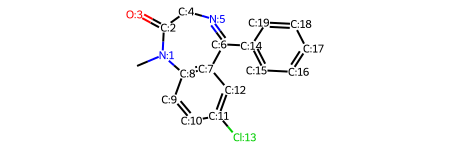

[0, 0, 0, 2, 1, 0, 0, 0, 0]


In [5]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def find_rings(smi):
    mol = Chem.MolFromSmiles(smi)
    ri = mol.GetRingInfo()
    atominfo = ri.AtomRings()
    return atominfo

def get_rings_count(smi, ring_min=3, ring_max=12):
    rings = find_rings(smi)
    rings = [ len(r) for r in rings ]
    rings = [ rings.count(i) for i in range(ring_min,ring_max) ]
    return rings

def locate_func( smi, pattern='C=CC=C', pattern_ngb=[1,2,2,1] ):
    """
    return a dict: key=location, value=functionl groups
    """
    pattern = Chem.MolFromSmiles(pattern)
    mol = Chem.MolFromSmiles(smi)
    #display(mol)
    #display( mol_with_atom_index(mol) )
    atoms_in_diene = mol.GetSubstructMatches(pattern)[0]
    bonds = [ mol.GetAtomWithIdx(at).GetBonds() for at in atoms_in_diene ]
    output = {}
    dummy_atom = Chem.Atom(82)
    for ii,(at,bond,patt) in enumerate(zip(atoms_in_diene,bonds,pattern_ngb)):
        if len(bond)>patt: ## There is a func here
            func_bond = [b for b in bond if b.GetBeginAtom().GetIdx() not in atoms_in_diene or b.GetEndAtom().GetIdx() not in atoms_in_diene]
            func_bond = [ b.GetIdx() for b in func_bond]
            mol_fragments = Chem.FragmentOnBonds( mol, func_bond , addDummies=True , dummyLabels=[(0,0) for b in func_bond] )
            mol_fragments = Chem.RWMol(mol_fragments)            
            mol_fragments.ReplaceAtom(at, dummy_atom)
            mol_fragments = Chem.GetMolFrags(mol_fragments, asMols=True)
            mol_fragments = [ fragment for fragment in mol_fragments if not any(a.GetSymbol()=='Pb' for a in fragment.GetAtoms()) ]

            mol_fragments = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol_fragments]
            output[ii] = mol_fragments
    return output

s = 'CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3'
mol = Chem.MolFromSmiles( s )
display( mol_with_atom_index(mol) )
print(  get_rings_count(s) )

## Add rdkit property to df

In [6]:
## Jump start with combined dataset, un-sorted
df_diene = pd.read_csv('df_diene_combined.csv', index_col=0)
display( df_diene )

LUMO      HOMO                                        SMILES  \
0     -0.503800 -5.854400           [H]O/C([H])=C(\[H])C([H])=C([H])[H]   
1     -2.398200 -7.084100       [H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
2     -2.086800 -7.005800         [H]C(=O)C(=C([H])[H])C([H])=C([H])[H]   
3     -1.858000 -6.837800        [H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]   
4     -2.137800 -7.059400      [H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]   
...         ...       ...                                           ...   
18594 -4.149632 -9.463881                               N#CC(=O)n1nnnn1   
18595 -4.013578 -8.370011                          [H]C(=O)C(=O)n1nnnn1   
18596 -1.665295 -7.651649         [H]C(=O)C([H])([H])C([H])([H])n1nnnn1   
18597 -2.786376 -8.492459                   [H]OC([H])([H])C(=O)n1nnnn1   
18598 -1.189108 -7.847566  [H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1   

      source diene_type diene_class  \
0        PNL      0_one          C4   
1        PNL      0_one          C4   
2        PNL      0_one          C4   
3        PNL      0_one          C4   
4        PNL      0_one          C4   
...      ...        ...         ...   
18594    QM9     N=NN=N         Mix   
18595    QM9     N=NN=N         Mix   
18596    QM9     N=NN=N         Mix   
18597    QM9     N=NN=N         Mix   
18598    QM9     N=NN=N         Mix   

                                                   Inchi  
0              InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+  
1            InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+  
2                InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2  
3       InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)  
4      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...  
...                                                  ...  
18594                InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8  
18595          InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H  
18596    InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2  
18597     InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2  
18598    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2  

[18599 rows x 7 columns]

In [33]:
#%%capture --no-display
## Double check ##
def check_error(smiles):
    try:
        Chem.RDKFingerprint(Chem.MolFromSmiles(smiles))
        return True
    except:
        return False

mask1 = [ check_error(s) for s in df_diene['SMILES'] ]
mask2 = df_diene['Inchi']!='NotFound'
mask_all = np.all([mask1,mask2], axis=0)
print( np.sum(mask_all) )

#df_diene.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_diene = df_diene.dropna(axis='rows')

18599


In [13]:
mask = [ True if '[S@+]' in s else False for s in df_diene['SMILES'] ]
df_diene[mask]

LUMO    HOMO                                             SMILES  \
8    -1.8710 -6.7556     [H]O[S@+]([O-])/C([H])=C(\[H])C([H])=C([H])[H]   
9    -1.7826 -6.8582     [H]O[S@+]([O-])/C([H])=C(/[H])C([H])=C([H])[H]   
23   -0.6866 -5.0549  [H]O[S@+]([O-])C(=C([H])[H])/C(=C(\[H])N(C([H]...   
24   -0.9266 -5.2498  [H]O[S@+]([O-])/C([H])=C([H])/C(=C(\[H])N(C([H...   
25   -1.3635 -5.2350  [H]O[S@+]([O-])/C(=C(\C([H])=C([H])[H])N(C([H]...   
...      ...     ...                                                ...   
5957 -3.3904 -7.0116            [H]O[S@+]([O-])c1nnc(C([H])([H])[H])nn1   
5962 -3.9066 -7.5298                  [H]O[S@+]([O-])c1nnc(C([H])=O)nn1   
5969 -4.1931 -7.8582                       [H]O[S@+]([O-])c1nnc(C#N)nn1   
5971 -3.3499 -7.0234           [H]O[S@+]([O-])c1nnc(SC([H])([H])[H])nn1   
5972 -3.8548 -7.5314          [H]O[S@+]([O-])c1nnc([S@@+]([O-])O[H])nn1   

     source diene_type diene_class  \
8       PNL      0_one          C4   
9       PNL      0_one          C4   
23      PNL    0_three          C4   
24      PNL    0_three          C4   
25      PNL    0_three          C4   
...     ...        ...         ...   
5957    PNL      2_two          N4   
5962    PNL      2_two          N4   
5969    PNL      2_two          N4   
5971    PNL      2_two          N4   
5972    PNL      2_two          N4   

                                                  Inchi  
8     InChI=1S/C4H6O2S/c1-2-3-4-7(5)6/h2-4H,1H2,(H,5...  
9     InChI=1S/C4H6O2S/c1-2-3-4-7(5)6/h2-4H,1H2,(H,5...  
23    InChI=1S/C8H16N2O2S/c1-7(13(11)12)8(10(4)5)6-9...  
24    InChI=1S/C8H16N2O2S/c1-9(2)7-8(10(3)4)5-6-13(1...  
25    InChI=1S/C8H16N2O2S/c1-6-7(9(2)3)8(10(4)5)13(1...  
...                                                 ...  
5957  InChI=1S/C3H4N4O2S/c1-2-4-6-3(7-5-2)10(8)9/h1H...  
5962  InChI=1S/C3H2N4O3S/c8-1-2-4-6-3(7-5-2)11(9)10/...  
5969  InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...  
5971  InChI=1S/C3H4N4O2S2/c1-10-2-4-6-3(7-5-2)11(8)9...  
5972  InChI=1S/C2H2N4O4S2/c7-11(8)1-3-5-2(6-4-1)12(9...  

[921 rows x 7 columns]

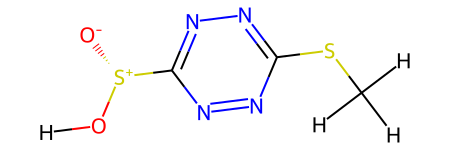

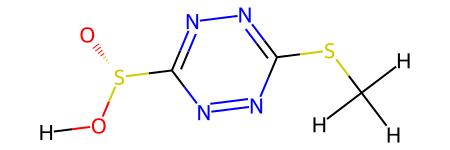

[H]O[S@+]([O-])c1nnc(SC([H])([H])[H])nn1 [H]OS(O)c1nnc(SC([H])([H])[H])nn1


In [15]:
from rdkit.Chem import rdDetermineBonds

smi1 = '[H]O[S@+]([O-])c1nnc(SC([H])([H])[H])nn1'
m = Chem.AddHs( Chem.MolFromSmiles(smi1) )
display( m )

for atom in m.GetAtoms():
    #atom = m.GetAtomWithIdx(at_idx)
    chg = atom.GetFormalCharge()
    atom.SetFormalCharge(0)
    atom.UpdatePropertyCache()
display( m )

#rdDetermineBonds.DetermineBonds(m,charge=0)
#display( m )

smi2 = Chem.MolToSmiles( m, canonical=True, isomericSmiles=True)
print( smi1, smi2 )

[07:47:33] DEPRECATION WARNING: please use MorganGenerator
[07:47:33] DEPRECATION WARNING: please use MorganGenerator
[07:47:33] DEPRECATION WARNING: please use MorganGenerator
[07:47:33] DEPRECATION WARNING: please use MorganGenerator
[07:47:33] DEPRECATION WARNING: please use MorganGenerator
[07:47:33] DEPRECATION WARNING: please use MorganGenerator


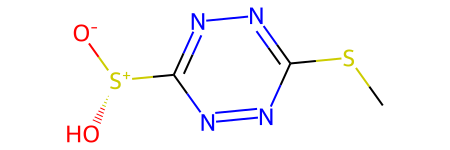

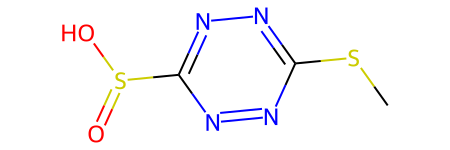

qed 0.501364498575434 0.5019414179280609
SPS 13.0 12.909090909090908
MaxPartialCharge 0.4156967302036969 0.2864181131070956
MinPartialCharge -0.5780008524382023 -0.2997377973081346
MaxAbsPartialCharge 0.5780008524382023 0.2997377973081346
MinAbsPartialCharge 0.4156967302036969 0.2864181131070956
BCUT2D_MWHI 32.23981464154533 32.209288744307386
BCUT2D_MWLOW 11.268009809563122 11.2681017164453
BCUT2D_CHGHI 2.125432262956167 2.041584951262874
BCUT2D_CHGLO -1.9444754296894209 -1.9059353166849076
BCUT2D_LOGPHI 2.0402332653550954 2.028674555886195
BCUT2D_LOGPLOW -2.0779606150482133 -2.024279820351401
BCUT2D_MRHI 7.979846539410796 7.97981685586992
BCUT2D_MRLOW 0.463079084888027 0.5382245065923988
BalabanJ 2.8274086041001762 2.9138015626758036
BertzCT 227.2837093023618 262.5446100817276
HallKierAlpha -0.44000000000000006 -0.6000000000000001
Kappa1 8.654696969696971 8.496153846153845
Kappa2 3.809658461029751 3.6938293606593904
Kappa3 2.2567440077715584 2.1704503288918873
LabuteASA 69.8325829636

In [18]:
df1 = Descriptors.CalcMolDescriptors( Chem.MolFromSmiles(smi1) ) 
df2 = Descriptors.CalcMolDescriptors( Chem.MolFromSmiles('[H]OS(=O)c1nnc(SC([H])([H])[H])nn1') ) 
display( Chem.MolFromSmiles(smi1), Chem.MolFromSmiles('[H]OS(=O)c1nnc(SC([H])([H])[H])nn1') )
for k,v1 in df1.items():
    v2 = df2[k]
    if v1!=v2:
        print(k, v1,v2)

In [5]:
%%capture --no-display

num_issue = 0

fp_data = []
for smi in df_diene['SMILES'][:]:
    try:
        df = Descriptors.CalcMolDescriptors( Chem.MolFromSmiles(smi) )        
        fp_data.append( pd.DataFrame(df, index=[smi]) )
    except:
        num_issue += 1
    #    fp_data.append( smi )
    #    display(smi, 'has problem')
display( num_issue )

X_prop = pd.concat(fp_data, axis=0)#, columns=fp_names_prop)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_prop = X_prop.select_dtypes(include=numerics)

#X_features_prop.to_csv('fp_rdk_phychem_property.csv')
X_prop = X_prop.dropna(axis='columns')
X_prop


0

MaxAbsEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                    7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                  9.565093   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                 9.759537   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]               9.623611   
...                                                         ...   
N#CC(=O)n1nnnn1                                       10.271389   
[H]C(=O)C(=O)n1nnnn1                                  10.264444   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                  9.790349   
[H]OC([H])([H])C(=O)n1nnnn1                           10.382500   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1           8.355366   

                                              MaxEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                 7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]             9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]               9.565093   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]              9.759537   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]            9.623611   
...                                                      ...   
N#CC(=O)n1nnnn1                                    10.271389   
[H]C(=O)C(=O)n1nnnn1                               10.264444   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1               9.790349   
[H]OC([H])([H])C(=O)n1nnnn1                        10.382500   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1        8.355366   

                                              MinAbsEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                    0.937500   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                0.710000   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                  0.425926   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                 0.027778   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]               0.944537   
...                                                         ...   
N#CC(=O)n1nnnn1                                        0.500000   
[H]C(=O)C(=O)n1nnnn1                                   0.072778   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                  0.400833   
[H]OC([H])([H])C(=O)n1nnnn1                            0.611111   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1           0.140417   

                                              MinEStateIndex       qed  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                 0.937500  0.363289   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]             0.710000  0.274912   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]               0.425926  0.274912   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]             -1.018519  0.409656   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]           -0.944537  0.409656   
...                                                      ...       ...   
N#CC(=O)n1nnnn1                                    -0.902778  0.379468   
[H]C(=O)C(=O)n1nnnn1                               -0.888889  0.316953   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1               0.400833  0.469488   
[H]OC([H])([H])C(=O)n1nnnn1                        -0.652778  0.457915   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1        0.140417  0.534304   

                                                   SPS    MolWt  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]           8.800000   70.091   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]       8.666667   82.102   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]         6.666667   82.102   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]        7.428571   98.101   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]      9.142857   98.101   
...                                                ...      ...   
N#CC(=O)n1nnnn1                               8.333333  124.063   
[H]C(=O)C(=O)n1nnnn1                          8.888889  127.063   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1         9.333333  127.107   
[H]OC([H])([H])C(=O)n1nnnn1                   9.444444  129.079   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nn

In [ ]:
#%%capture --no-display

## Skip if generated already
fp_names_prop = [ n[0] for n in Descriptors._descList if not n[0].startswith('fr_')]
fp_names_prop.remove('Ipc')  ## https://github.com/rdkit/rdkit/issues/1527
print( len(fp_names_prop) )

from rdkit.ML.Descriptors import MoleculeDescriptors
calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_names_prop)   

fp_data = []
for sour,smi in zip(df_diene['source'], df_diene['SMILES']):
    try:
        fp = calc.CalcDescriptors( Chem.MolFromSmiles(smi) )
        #fp_data.append( list(y)+list(fp) )
        fp_data.append( fp )
    except:
        fp_data.append( list( np.full(len(fp_names_prop),-99999) ) )
        print(smi, 'has problem')
    
X_prop = pd.DataFrame(fp_data, columns=fp_names_prop)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_prop = X_prop.select_dtypes(include=numerics)

#X_features_prop.to_csv('fp_rdk_phychem_property.csv')
X_prop = X_prop.dropna(axis='columns')
X_prop


In [6]:
X_prop.columns = [ 'rdk_'+c for c in X_prop.columns ]
df_diene = pd.concat( [df_diene.set_index('SMILES'),X_prop], axis=1, join='inner' )
#df_diene.to_csv('df_diene_combined_with_rdkprop.csv')
df_diene

LUMO      HOMO source  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]          -0.503800 -5.854400    PNL   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]      -2.398200 -7.084100    PNL   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]        -2.086800 -7.005800    PNL   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]       -1.858000 -6.837800    PNL   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]     -2.137800 -7.059400    PNL   
...                                                ...       ...    ...   
N#CC(=O)n1nnnn1                              -4.149632 -9.463881    QM9   
[H]C(=O)C(=O)n1nnnn1                         -4.013578 -8.370011    QM9   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1        -1.665295 -7.651649    QM9   
[H]OC([H])([H])C(=O)n1nnnn1                  -2.786376 -8.492459    QM9   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1 -1.189108 -7.847566    QM9   

                                             diene_type diene_class  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]               0_one          C4   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]           0_one          C4   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             0_one          C4   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]            0_one          C4   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]          0_one          C4   
...                                                 ...         ...   
N#CC(=O)n1nnnn1                                  N=NN=N         Mix   
[H]C(=O)C(=O)n1nnnn1                             N=NN=N         Mix   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1            N=NN=N         Mix   
[H]OC([H])([H])C(=O)n1nnnn1                      N=NN=N         Mix   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1     N=NN=N         Mix   

                                                                                          Inchi  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                   InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]             InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]         InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...   
...                                                                                         ...   
N#CC(=O)n1nnnn1                                             InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8   
[H]C(=O)C(=O)n1nnnn1                                  InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1           InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2   
[H]OC([H])([H])C(=O)n1nnnn1                      InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2   

                                              rdk_MaxAbsEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                        7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                    9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                      9.565093   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                     9.759537   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                   9.623611   
...                                                             ...   
N#CC(=O)n1nnnn1                                           10.271389   
[H]C(=O)C(=O)n1nnnn1                                      10.264444   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                      9.790349   
[H]OC([H])([H])C(=O)n1nnnn1                               10.382500   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1               8.355366   

                                              rdk_MaxEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             

In [7]:
# Compute the ring counts
ring_considered_min, ring_considered_max = 3,12
ring_col = [ 'RingCount_'+str(i) for i in range(ring_considered_min, ring_considered_max) ]

data = [ get_rings_count(s, ring_min=ring_considered_min, ring_max=ring_considered_max) for s in df_diene.index ]
df_ring = pd.DataFrame(data, columns=ring_col, index=df_diene.index )
#df_ring['source'] = df_diene['source']
df_ring

RingCount_3  RingCount_4  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     0            0   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 0            0   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   0            0   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                  0            0   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                0            0   
...                                                   ...          ...   
N#CC(=O)n1nnnn1                                         0            0   
[H]C(=O)C(=O)n1nnnn1                                    0            0   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                   0            0   
[H]OC([H])([H])C(=O)n1nnnn1                             0            0   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1            0            0   

                                              RingCount_5  RingCount_6  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     0            0   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 0            0   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   0            0   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                  0            0   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                0            0   
...                                                   ...          ...   
N#CC(=O)n1nnnn1                                         1            0   
[H]C(=O)C(=O)n1nnnn1                                    1            0   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                   1            0   
[H]OC([H])([H])C(=O)n1nnnn1                             1            0   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1            1            0   

                                              RingCount_7  RingCount_8  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     0            0   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 0            0   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   0            0   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                  0            0   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                0            0   
...                                                   ...          ...   
N#CC(=O)n1nnnn1                                         0            0   
[H]C(=O)C(=O)n1nnnn1                                    0            0   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                   0            0   
[H]OC([H])([H])C(=O)n1nnnn1                             0            0   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1            0            0   

                                              RingCount_9  RingCount_10  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     0             0   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 0             0   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   0             0   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                  0             0   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                0             0   
...                                                   ...           ...   
N#CC(=O)n1nnnn1                                         0             0   
[H]C(=O)C(=O)n1nnnn1                                    0             0   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                   0             0   
[H]OC([H])([H])C(=O)n1nnnn1                             0             0   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1            0             0   

                                              RingCount_11  
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                      0  
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                  0  
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                    0  
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                   0  
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 0  
...                                                    ...  
N#CC(=O)n1nnnn1                                    

In [8]:
df_diene = pd.concat( [df_diene, df_ring], axis=1, join='inner' )
df_diene

LUMO      HOMO source  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]          -0.503800 -5.854400    PNL   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]      -2.398200 -7.084100    PNL   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]        -2.086800 -7.005800    PNL   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]       -1.858000 -6.837800    PNL   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]     -2.137800 -7.059400    PNL   
...                                                ...       ...    ...   
N#CC(=O)n1nnnn1                              -4.149632 -9.463881    QM9   
[H]C(=O)C(=O)n1nnnn1                         -4.013578 -8.370011    QM9   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1        -1.665295 -7.651649    QM9   
[H]OC([H])([H])C(=O)n1nnnn1                  -2.786376 -8.492459    QM9   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1 -1.189108 -7.847566    QM9   

                                             diene_type diene_class  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]               0_one          C4   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]           0_one          C4   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             0_one          C4   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]            0_one          C4   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]          0_one          C4   
...                                                 ...         ...   
N#CC(=O)n1nnnn1                                  N=NN=N         Mix   
[H]C(=O)C(=O)n1nnnn1                             N=NN=N         Mix   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1            N=NN=N         Mix   
[H]OC([H])([H])C(=O)n1nnnn1                      N=NN=N         Mix   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1     N=NN=N         Mix   

                                                                                          Inchi  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                   InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]             InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]         InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...   
...                                                                                         ...   
N#CC(=O)n1nnnn1                                             InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8   
[H]C(=O)C(=O)n1nnnn1                                  InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1           InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2   
[H]OC([H])([H])C(=O)n1nnnn1                      InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2   

                                              rdk_MaxAbsEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                        7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                    9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                      9.565093   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                     9.759537   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                   9.623611   
...                                                             ...   
N#CC(=O)n1nnnn1                                           10.271389   
[H]C(=O)C(=O)n1nnnn1                                      10.264444   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                      9.790349   
[H]OC([H])([H])C(=O)n1nnnn1                               10.382500   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1               8.355366   

                                              rdk_MaxEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             

In [9]:
df_diene.to_csv('df_diene_final_dataset.csv')


In [10]:
print(    np.sum(df_diene['source'] =='PNL'),    np.sum(df_diene['source'] =='QM9')  )
print(    np.any( df_ring[ df_diene['source'] =='PNL' ]>0, axis=1 ).sum(),     np.any( df_ring[ df_diene['source'] =='QM9' ]>0, axis=1 ).sum()  )

df_pnl = np.sum( df_ring[ df_diene['source'] =='PNL' ]>0, axis=0)
df_qm9 = np.sum( df_ring[ df_diene['source'] =='QM9' ]>0, axis=0)
#display( df_pnl, df_qm9 )
df_ring_count = pd.concat( [df_pnl, df_qm9], axis=1)
df_ring_count.columns = ['PNL','QM9']
df_ring_count

5977 12622
2254 12583


PNL    QM9
RingCount_3      0      0
RingCount_4      0    503
RingCount_5      0  10396
RingCount_6   2254   2272
RingCount_7      0    199
RingCount_8      0      3
RingCount_9      0      4
RingCount_10     0      0
RingCount_11     0      0

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4,4),tight_layout=True,dpi=100)
#sns.histplot(df_ring, x='Ring_count_6', hue='source', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='HOMO',  
#sns.histplot(df_diene, x='LUMO', hue='source', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO',  
df_ring_count.plot(kind='bar', y=['PNL','QM9'], color=['red','blueviolet'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)

In [ ]:
#df = df_diene[ np.all([df_diene['source'] =='PNL', df_ring['Ring_count_4']>0],axis=0) ]
df = df_diene[ np.all([df_diene['source'] =='QM9', np.all(df_ring==0,axis=1)],axis=0) ]
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df['SMILES']], molsPerRow=5 ) ##, legends=[str(p) for p in top['LUMO']] )  
display(img)
df

In [48]:
# Generate padelpy descriptor if needed
df_padelpy = pd.read_csv('../df_merged.csv', index_col=0).drop(['Unnamed: 0'],axis=1)
df_padelpy.columns = [ 'padelpy_'+c for c in df_padelpy.columns ]
df_padelpy

padelpy_nAcid  padelpy_ALogP  padelpy_ALogp2  padelpy_AMR  \
0                0.0         0.9424        0.888118      31.5678   
1                0.0         1.3494        1.820880      39.4072   
2                0.0         0.5753        0.330970      37.6331   
3                1.0         0.0190        0.000361      37.3600   
4                0.0         0.9189        0.844377      37.3576   
...              ...            ...             ...          ...   
23141            0.0         0.6777        0.459277       9.7346   
23142            0.0         0.9440        0.891136       8.0537   
23143            0.0         0.9440        0.891136       8.0537   
23144            0.0         0.9440        0.891136       8.0537   
23145            0.0         0.9440        0.891136       8.0537   

       padelpy_apol  padelpy_naAromAtom  padelpy_nAromBond  padelpy_nAtom  \
0         15.427172                 0.0                0.0           12.0   
1         19.227551                 0.0                0.0           15.0   
2         19.691551                 0.0                0.0           17.0   
3         17.737965                 0.0                0.0           14.0   
4         19.691551                 0.0                0.0           17.0   
...             ...                 ...                ...            ...   
23141     11.584586                 5.0                5.0           11.0   
23142     11.946586                 5.0                5.0           11.0   
23143     10.619793                 5.0                5.0           10.0   
23144     10.619793                 5.0                5.0           10.0   
23145      9.293000                 5.0                5.0            9.0   

       padelpy_nHeavyAtom  padelpy_nH  ...  padelpy_PubchemFP871  \
0                     8.0         4.0  ...                   0.0   
1                     8.0         7.0  ...                   0.0   
2                    10.0         7.0  ...                   0.0   
3                     9.0         5.0  ...                   0.0   
4                    10.0         7.0  ...                   0.0   
...                   ...         ...  ...                   ...   
23141                 9.0         2.0  ...                   0.0   
23142                 9.0         2.0  ...                   0.0   
23143                 9.0         1.0  ...                   0.0   
23144                 9.0         1.0  ...                   0.0   
23145                 9.0         0.0  ...                   0.0   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
0                       0.0                   0.0                   0.0   
1                       0.0                   0.0                   0.0   
2                       0.0                   0.0                   0.0   
3                       0.0                   0.0                   0.0   
4                       0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
23141                   0.0                   0.0                   0.0   
23142                   0.0                   0.0                   0.0   
23143                   0.0                   0.0                   0.0   
23144                   0.0                   0.0                   0.0   
23145                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875  padelpy_PubchemFP876  padelpy_PubchemFP877  \
0                       0.0                   0.0                   0.0   
1                       0.0                   0.0                   0.0   
2                       0.0                   0.0                   0.0   
3                       0.0                   0.0                   0.0   
4                       0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
23141                 

In [49]:
df_diene_all_descriptor = pd.concat( [df_diene, df_padelpy], axis=1, join='inner')
df_diene_all_descriptor = df_diene_all_descriptor[df_diene_all_descriptor['padelpy_PubchemFP880']!= -11111] # Remove the bad structure

df_diene_all_descriptor.to_csv('df_diene_all_descriptor.csv')
df_diene_all_descriptor

HOMO      LUMO                SMILES source  SMILES_pattern_C=CC=C  \
0     -9.223634 -2.514619      C=C/C(C#N)=C\C#N    PNL                   True   
1     -6.825734 -1.951855       C=C/C(=C\C#N)SC    PNL                   True   
2     -7.288529 -2.100722  C=C/C(=C\C#N)OC(C)=O    PNL                   True   
3     -7.787972 -2.711582   C=C/C(=C\C#N)S(=O)O    PNL                   True   
4     -7.539353 -2.689519  C=C/C(=C\C#N)C(=O)OC    PNL                   True   
...         ...       ...                   ...    ...                    ...   
23141 -8.114231 -0.859858    FC(F)(F)c1n[nH]nc1    QM9                  False   
23142 -7.869334 -1.036728       FC(F)(F)c1nocc1    QM9                  False   
23143 -8.889736 -1.504752       FC(F)(F)c1nocn1    QM9                  False   
23144 -9.281570 -2.005429       FC(F)(F)c1nonc1    QM9                  False   
23145 -9.678846 -2.737396       FC(F)(F)c1nonn1    QM9                  False   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
0                      False                  False                  False   
1                      False                  False                  False   
2                      False                  False                  False   
3                      False                  False                  False   
4                      False                  False                  False   
...                      ...                    ...                    ...   
23141                  False                  False                  False   
23142                   True                  False                  False   
23143                  False                  False                  False   
23144                  False                  False                  False   
23145                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
0                      False                  False  ...   
1                      False                  False  ...   
2                      False                  False  ...   
3                      False                  False  ...   
4                      False                  False  ...   
...                      ...                    ...  ...   
23141                  False                   True  ...   
23142                  False                  False  ...   
23143                   True                  False  ...   
23144                  False                   True  ...   
23145                  False                  False  ...   

       padelpy_PubchemFP871  padelpy_PubchemFP872  padelpy_PubchemFP873  \
0                       0.0                   0.0                   0.0   
1                       0.0                   0.0                   0.0   
2                       0.0                   0.0                   0.0   
3                       0.0                   0.0                   0.0   
4                       0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
23141                   0.0                   0.0                   0.0   
23142                   0.0                   0.0                   0.0   
23143                   0.0                   0.0                   0.0   
23144                   0.0                   0.0                   0.0   
23145                   0.0                   0.0                   0.0   

       padelpy_PubchemFP874 padelpy_PubchemFP875 padelpy_PubchemFP876  \
0                       0.0                  0.0                  0.0   
1                       0.0                  0.0                  0.0   
2                       0.0                  0.0                  0.0   
3                       0.0                  0.0                  0.0   
4                       0.0                  0.0                  0.0   
...                     ...              

## Pattern = butadiene C=CC=C

In [19]:
df_diene = pd.read_csv('df_diene_final_dataset.csv', index_col=0)

df_diene.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene = df_diene.dropna(axis='columns')

df_diene

LUMO      HOMO source  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]          -0.503800 -5.854400    PNL   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]      -2.398200 -7.084100    PNL   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]        -2.086800 -7.005800    PNL   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]       -1.858000 -6.837800    PNL   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]     -2.137800 -7.059400    PNL   
...                                                ...       ...    ...   
N#CC(=O)n1nnnn1                              -4.149632 -9.463881    QM9   
[H]C(=O)C(=O)n1nnnn1                         -4.013578 -8.370011    QM9   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1        -1.665295 -7.651649    QM9   
[H]OC([H])([H])C(=O)n1nnnn1                  -2.786376 -8.492459    QM9   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1 -1.189108 -7.847566    QM9   

                                             diene_type diene_class  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]               0_one          C4   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]           0_one          C4   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             0_one          C4   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]            0_one          C4   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]          0_one          C4   
...                                                 ...         ...   
N#CC(=O)n1nnnn1                                  N=NN=N         Mix   
[H]C(=O)C(=O)n1nnnn1                             N=NN=N         Mix   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1            N=NN=N         Mix   
[H]OC([H])([H])C(=O)n1nnnn1                      N=NN=N         Mix   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1     N=NN=N         Mix   

                                                                                          Inchi  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                   InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2/b4-3+   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]             InChI=1S/C5H6O/c1-2-3-4-5-6/h2-5H,1H2/b4-3+   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                   InChI=1S/C5H6O/c1-3-5(2)4-6/h3-4H,1-2H2   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]         InChI=1S/C5H6O2/c1-3-4(2)5(6)7/h3H,1-2H2,(H,6,7)   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]      InChI=1S/C5H6O2/c1-2-3-4-5(6)7/h2-4H,1H2,(H,6,...   
...                                                                                         ...   
N#CC(=O)n1nnnn1                                             InChI=1S/C2N6O/c3-1-2(9)8-6-4-5-7-8   
[H]C(=O)C(=O)n1nnnn1                                  InChI=1S/C2HN5O2/c8-1-2(9)7-5-3-4-6-7/h1H   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1           InChI=1S/C3H5N5O/c9-3-1-2-8-6-4-5-7-8/h3H,1-2H2   
[H]OC([H])([H])C(=O)n1nnnn1                      InChI=1S/C2H3N5O2/c8-1-2(9)7-5-3-4-6-7/h8H,1H2   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1    InChI=1S/C3H7N5O/c9-3-1-2-8-6-4-5-7-8/h9H,1-3H2   

                                              rdk_MaxAbsEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                        7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                    9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]                      9.565093   
[H]OC(=O)C(=C([H])[H])C([H])=C([H])[H]                     9.759537   
[H]OC(=O)/C([H])=C(\[H])C([H])=C([H])[H]                   9.623611   
...                                                             ...   
N#CC(=O)n1nnnn1                                           10.271389   
[H]C(=O)C(=O)n1nnnn1                                      10.264444   
[H]C(=O)C([H])([H])C([H])([H])n1nnnn1                      9.790349   
[H]OC([H])([H])C(=O)n1nnnn1                               10.382500   
[H]OC([H])([H])C([H])([H])C([H])([H])n1nnnn1               8.355366   

                                              rdk_MaxEStateIndex  \
[H]O/C([H])=C(\[H])C([H])=C([H])[H]                     7.814444   
[H]C(=O)/C([H])=C(\[H])C([H])=C([H])[H]                 9.429167   
[H]C(=O)C(=C([H])[H])C([H])=C([H])[H]             

In [ ]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)
df_diene_all_descriptor

In [ ]:
patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = ['SMILES_pattern_C=CC=C']
pattern_no = [p for p in patterns_col if p not in pattern_yes]

# Patterns that only match the target values
mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern

In [12]:
df_pnl = df_diene[ df_diene['source'] =='PNL' ].sort_values(by='LUMO',ascending=True)
df_qm9 = df_diene[ df_diene['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)
print( 'Num of QM9 data: ', len(df_pnl) )
print( 'Num of PNL data: ', len(df_qm9) )
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)
sns.histplot(df_diene, x='HOMO', hue='source', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_diene, x='LUMO', hue='source', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO',  

Num of QM9 data:  5977
Num of PNL data:  12622


<AxesSubplot:xlabel='LUMO', ylabel='Count'>

In [13]:
for c in list(set( df_diene['diene_class'] )):
    print( c, df_diene['diene_class'].value_counts()[c] )

N4 64
C4 3723
C6 2191
Mix 12621


In [ ]:
## C#N is bothering? See the CN in dienes
mask = [ not has_substructure(s,sub_struct=['C#N']) for s in df_diene_pattern['SMILES'] ]
df_diene_pattern[mask]

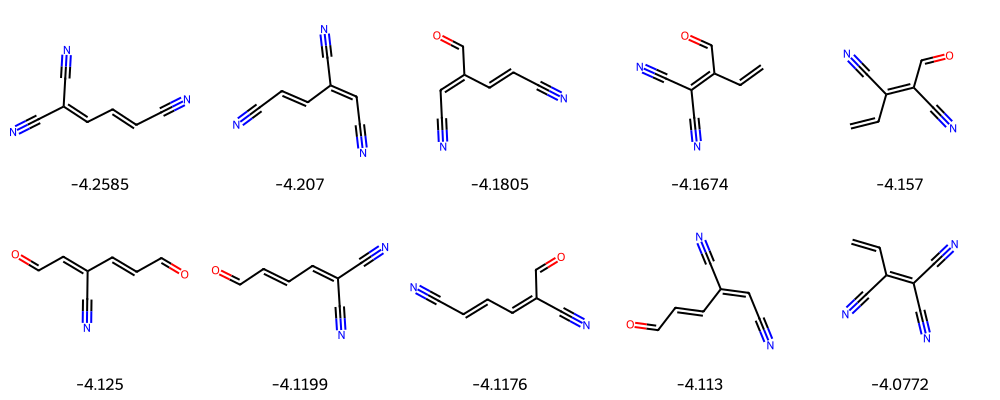

LUMO    HOMO source  \
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N            -4.2585 -8.1229    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N           -4.2070 -8.2029    PNL   
[H]C(=O)C(=C(\[H])C#N)/C([H])=C(\[H])C#N      -4.1805 -7.9527    PNL   
[H]C(=O)C(=C(C#N)C#N)C([H])=C([H])[H]         -4.1674 -8.0020    PNL   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]       -4.1570 -8.0485    PNL   
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O -4.1250 -7.8908    PNL   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N       -4.1199 -7.9799    PNL   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N      -4.1176 -7.9481    PNL   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N      -4.1130 -7.8384    PNL   
[H]C([H])=C([H])C(C#N)=C(C#N)C#N              -4.0772 -8.2850    PNL   

                                              diene_type diene_class  \
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N               0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N              0_three          C4   
[H]C(=O)C(=C(\[H])C#N)/C([H])=C(\[H])C#N         0_three          C4   
[H]C(=O)C(=C(C#N)C#N)C([H])=C([H])[H]            0_three          C4   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]          0_three          C4   
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O    0_three          C4   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N          0_three          C4   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N         0_three          C4   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N         0_three          C4   
[H]C([H])=C([H])C(C#N)=C(C#N)C#N                 0_three          C4   

                                                                                           Inchi  \
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N             InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N            InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]C(=O)C(=C(\[H])C#N)/C([H])=C(\[H])C#N       InChI=1S/C7H4N2O/c8-4-1-2-7(6-10)3-5-9/h1-3,6H...   
[H]C(=O)C(=C(C#N)C#N)C([H])=C([H])[H]           InChI=1S/C7H4N2O/c1-2-6(5-10)7(3-8)4-9/h2,5H,1H2   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]        InChI=1S/C7H4N2O/c1-2-6(3-8)7(4-9)5-10/h2,5H,1...   
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O  InChI=1S/C7H5NO2/c8-6-7(3-5-10)2-1-4-9/h1-5H/b...   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N        InChI=1S/C7H4N2O/c8-5-7(6-9)3-1-2-4-10/h1-4H/b...   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N       InChI=1S/C7H4N2O/c8-4-2-1-3-7(5-9)6-10/h1-3,6H...   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N       InChI=1S/C7H4N2O/c8-4-3-7(6-9)2-1-5-10/h1-3,5H...   
[H]C([H])=C([H])C(C#N)=C(C#N)C#N                   InChI=1S/C7H3N3/c1-2-6(3-8)7(4-9)5-10/h2H,1H2   

                                               rdk_MaxAbsEStateIndex  \
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                          8.167771   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                         8.253704   
[H]C(=O)C(=C(\[H])C#N)/C([H])=C(\[H])C#N                   10.020779   
[H]C(=O)C(=C(C#N)C#N)C([H])=C([H])[H]                      10.063981   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]                    10.016065   
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O               9.787596   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N                     9.681127   
[H]C(=O)/C(C#N)=C([H])\C([H])=C(/[H])C#N                    9.922693   
[H]C(=O)/C([H])=C([H])/C(C#N)=C(/[H])C#N                    9.723148   
[H]C([H])=C([H])C(C#N)=C(C#N)C#N                            8.277315   

                                               rdk_MaxEStateIndex  \
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                       8.167771   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                      8.253704   
[H]C(=O)C(=C(\[H])C#N)/C([H])=C(\[H])C#N                10.020779   
[H]C(=O)C(=C(C#N)C#N)C([H])=C([H])[H]                   10.063981   
[H]C(=O)/C(C#N)=C(\C#N)C([H])=C([H])[H]                 10.016065   
[H]C(=O)/C([H])=C(C#N)/C([H])=C(\[H])C([H])=O            9.787596   
[H]C(=O)/C([H])=C(\[H])C([H])=C(C#N)C#N                  9.681127   
[H]C(=O)/C(C#N)=C

In [14]:
#df = df_diene[ df_diene['source']=='PNL' ].sort_values(by='LUMO',ascending=True)
df = df_diene[ df_diene['diene_class']=='C4' ].sort_values(by='LUMO',ascending=True)

df = df.head(10)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df.index], molsPerRow=5, legends=[str(p) for p in df['LUMO']] )  
display(img, df)


### 1. PNL diene

In [6]:
df_pnl = df_diene[ df_diene['source']=='PNL' ].sort_values(by='LUMO',ascending=True)

## Can we constraint our choice to organic groups with C H O N P S only?
good_elements = ['C','H','O','N','S']
mask_element = []   ## molecules to keep, keep=True
for smi in df_pnl.index:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    mask_element.append(all(e in good_elements for e in element))
df_pnl = df_pnl[mask_element]
#df_final = df_final.reset_index(drop=True)
display( df_pnl )

LUMO    HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.5527 -8.2207    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.2967 -7.8837    PNL   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                 -4.2585 -8.1229    PNL   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                -4.2070 -8.2029    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.1931 -7.8582    PNL   
...                                                    ...     ...    ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  0.7473 -3.5459    PNL   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  0.7738 -3.7993    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.8251 -3.9622    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  0.9764 -3.6464    PNL   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  1.0242 -3.7444    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                    0_three          C4   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                   0_three          C4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
...                                                       ...         ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...    0_three          C4   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...    0_three          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...    0_three          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                  InChI=1S/C7H3N3/c8-4-2-1-3-7(5-9)6-10/h1-3H/b2-1+   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                 InChI=1S/C7H3N3/c8-4-1-2-7(6-10)3-5-9/h1-3H/b2...   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
...                                                                                               ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...  InChI=1S/C7H14N2O/c1-9(2)6-4-5-7(8)10-3/h4-6H,...   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...  InChI=1S/C7H14N2/c1-7(9(2)3)5-4-6-8/h4-6H,8H2,...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C9H18N2O/c1-10(2)8-6-7-9(12-5)11(3)4/...   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...  InChI=1S/C7H14N2O/c1-9(2)7(10-3)5-4-6-8/h4-6H,...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 8.163280   
[H]C(=O)c1nnc(C#N)nn1                                            9.918202   
[H]C(=C(C#N)C#N)/C([H])=C(\[H])C#N                               8.167771   
[H]/C(C#N)=C([H])\C(C#N)=C(\[H])C#N                              8.253704   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                    10.223758   
...                                                                   ...   
[H]C(=C(/OC([H])([H])[H])N([H])[H])/C([H])=C(\[...               5.328299   
[H]C(=C(/N(C([H])([H])[H])C([H])([H])[H])C([H])...               5.133299   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  4.927222   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...               5.110808   
[H]C(/C([H])=C(/OC([H])([H])[H])N(C([H])([H])[H...               5.132449   

                  

In [9]:
tag = ['unknown' if 'three' in d else 'known' for d in df_pnl['diene_type']]
df_pnl['tag'] = tag

df_pnl = df_pnl[ df_pnl['tag']=='known' ]
df_pnl

LUMO    HOMO source  \
N#Cc1nnc(C#N)nn1                                   -4.5527 -8.2207    PNL   
[H]C(=O)c1nnc(C#N)nn1                              -4.2967 -7.8837    PNL   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.1931 -7.8582    PNL   
[H]C(=O)c1nnc(C([H])=O)nn1                         -4.1621 -7.5513    PNL   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                -4.1484 -7.8139    PNL   
...                                                    ...     ...    ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  0.4591 -4.5486    PNL   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...  0.4841 -4.3699    PNL   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6879 -3.7748    PNL   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6898 -3.8828    PNL   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.8251 -3.9622    PNL   

                                                   diene_type diene_class  \
N#Cc1nnc(C#N)nn1                                        2_two          N4   
[H]C(=O)c1nnc(C#N)nn1                                   2_two          N4   
[H]O[S@+]([O-])c1nnc(C#N)nn1                            2_two          N4   
[H]C(=O)c1nnc(C([H])=O)nn1                              2_two          N4   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                     2_two          N4   
...                                                       ...         ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...      0_two          C4   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...      0_two          C4   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...      0_two          C4   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...      0_two          C4   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]         0_two          C4   

                                                                                                Inchi  \
N#Cc1nnc(C#N)nn1                                                InChI=1S/C4N6/c5-1-3-7-9-4(2-6)10-8-3   
[H]C(=O)c1nnc(C#N)nn1                                     InChI=1S/C4HN5O/c5-1-3-6-8-4(2-10)9-7-3/h2H   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        InChI=1S/C3HN5O2S/c4-1-2-5-7-3(8-6-2)11(9)10/h...   
[H]C(=O)c1nnc(C([H])=O)nn1                            InChI=1S/C4H2N4O2/c9-1-3-5-7-4(2-10)8-6-3/h1-2H   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                 InChI=1S/C3H2N4O4S/c8-2(9)1-4-6-3(7-5-1)12(10)...   
...                                                                                               ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  InChI=1S/C5H9NO/c1-7-5-3-2-4-6/h2-5H,6H2,1H3/b...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...  InChI=1S/C7H13NO/c1-8(2)6-4-5-7-9-3/h4-7H,1-3H...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  InChI=1S/C8H16N2/c1-9(2)7-5-6-8-10(3)4/h5-8H,1...   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  InChI=1S/C6H12N2/c1-8(2)6-4-3-5-7/h3-6H,7H2,1-...   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     InChI=1S/C4H8N2/c5-3-1-2-4-6/h1-4H,5-6H2/b3-1+...   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 8.163280   
[H]C(=O)c1nnc(C#N)nn1                                            9.918202   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                    10.223758   
[H]C(=O)c1nnc(C([H])=O)nn1                                       9.912782   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                             10.240765   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               4.981927   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               4.673308   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               5.064410   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  4.927222   

                  

In [ ]:
func = ['CO', 'CN(C)C', 'CN', 'COC',   'CC', 'CC=O', 'CC(=O)O',  'CC#N','CSC', 'CS(=O)O',]
img = Draw.MolsToGridImage( [Chem.MolFromSmiles('*'+p[1:]) for p in func], molsPerRow=11, subImgSize=(400, 300), returnPNG=False )# ,legends=[func[n] for n in range(len(func))] )  
display(img)

In [10]:
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)
sns.histplot(df_pnl, x='HOMO', hue='diene_class', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_pnl, x='LUMO', hue='diene_class', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO',  

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

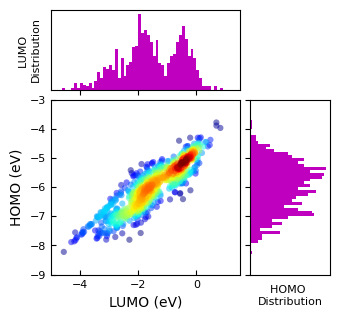

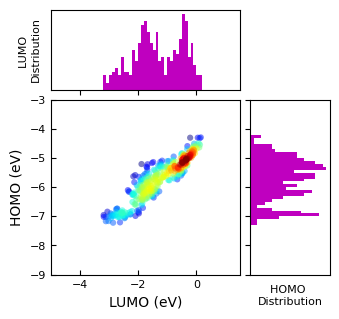

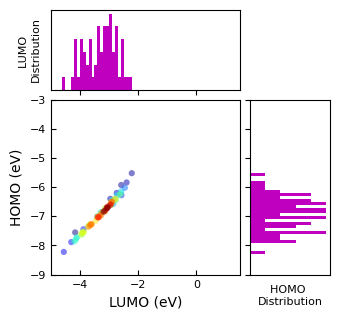

In [11]:
def plot_homo_lumo(x,y, fout=None):
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,)#dpi=200)

    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    #z = plt.cm.jet(z)
    
    im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
    axs.set_aspect(1.)
    
    axs.set_xlabel('LUMO (eV)',fontsize=10) ## input X name
    axs.set_ylabel('HOMO (eV)',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    axs.set_xlim([-5,1.5])
    axs.set_ylim([-9,-3])
    
    divider = make_axes_locatable(axs)
    extra_length = 0.8
    axHistx = divider.append_axes("top", extra_length, pad=0.1, sharex=axs)
    axHisty = divider.append_axes("right", extra_length, pad=0.1, sharey=axs)
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)
    
    ## Hist info
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1)*binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins, color='m')
    axHisty.hist(y, bins=bins, orientation='horizontal',color='m')
    
    axHistx.set_ylabel('LUMO \nDistribution',fontsize=8)
    axHisty.set_xlabel('HOMO \nDistribution',fontsize=8) 
    #axHistx.set_ylim([0,620])
    #axHisty.set_xlim([0,620])
    axHistx.set_yticks([])
    axHisty.set_xticks([])
    
    if fout is not None:
        plt.savefig(fout, dpi=800)    # Figure_2_PNL_LUMOHOMO.png     
    plt.show()

    df_pnl = df_diene[ df_diene['source']=='PNL' ].sort_values(by='LUMO',ascending=True)


x = np.array(df_pnl['LUMO'])
y = np.array(df_pnl['HOMO'])
plot_homo_lumo(x,y)

x = np.array(df_pnl[ df_pnl['diene_class']=='C4' ]['LUMO'])
y = np.array(df_pnl[ df_pnl['diene_class']=='C4' ]['HOMO'])
plot_homo_lumo(x,y)

x = np.array(df_pnl[ df_pnl['diene_class']=='C6' ]['LUMO'])
y = np.array(df_pnl[ df_pnl['diene_class']=='C6' ]['HOMO'])
plot_homo_lumo(x,y)

x = np.array(df_pnl[ df_pnl['diene_class']=='N4' ]['LUMO'])
y = np.array(df_pnl[ df_pnl['diene_class']=='N4' ]['HOMO'])
plot_homo_lumo(x,y)


In [13]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_pnl.columns if 'rdk_' in c ]#or 'RingCount_' in c ]    
X_features = df_pnl[feature_col]
X_features

LUMO  \
N#Cc1nnc(C#N)nn1                                   -4.5527   
[H]C(=O)c1nnc(C#N)nn1                              -4.2967   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.1931   
[H]C(=O)c1nnc(C([H])=O)nn1                         -4.1621   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                -4.1484   
...                                                    ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  0.4591   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...  0.4841   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6879   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6898   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.8251   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 8.163280   
[H]C(=O)c1nnc(C#N)nn1                                            9.918202   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                    10.223758   
[H]C(=O)c1nnc(C([H])=O)nn1                                       9.912782   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                             10.240765   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               4.981927   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               4.673308   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               5.064410   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  4.927222   

                                                    rdk_MaxEStateIndex  \
N#Cc1nnc(C#N)nn1                                              8.163280   
[H]C(=O)c1nnc(C#N)nn1                                         9.918202   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                 10.223758   
[H]C(=O)c1nnc(C([H])=O)nn1                                    9.912782   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                          10.240765   
...                                                                ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...            4.981927   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...            4.673308   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            5.064410   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]               4.927222   

                                                    rdk_MinAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 0.139815   
[H]C(=O)c1nnc(C#N)nn1                                            0.125926   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                     0.236852   
[H]C(=O)c1nnc(C([H])=O)nn1                                       0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                              0.527778   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               1.440000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               1.625000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               1.500000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  1.420000   

                                                    rdk_MinEStateIndex  \
N#Cc1nnc(C#N)nn1                                             -0.139815   
[H]C(=O)c1nnc(C#N)nn1                                        -0.147593   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                 -2.295839   
[H]C(=O)c1nnc(C([H])=O)nn1                                   -0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                          -2.390605   
...                                                                ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  

In [14]:
X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
X_features_prop_clean

Before clean (743, 199)
After clean (743, 125)
Num of keep:  69
Num of drop:  56
---------


LUMO  \
N#Cc1nnc(C#N)nn1                                   -4.5527   
[H]C(=O)c1nnc(C#N)nn1                              -4.2967   
[H]O[S@+]([O-])c1nnc(C#N)nn1                       -4.1931   
[H]C(=O)c1nnc(C([H])=O)nn1                         -4.1621   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                -4.1484   
...                                                    ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  0.4591   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...  0.4841   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6879   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.6898   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.8251   

                                                    rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 8.163280   
[H]C(=O)c1nnc(C#N)nn1                                            9.918202   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                    10.223758   
[H]C(=O)c1nnc(C([H])=O)nn1                                       9.912782   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                             10.240765   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               4.981927   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               4.673308   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               5.064410   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  4.927222   

                                                    rdk_MinAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 0.139815   
[H]C(=O)c1nnc(C#N)nn1                                            0.125926   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                     0.236852   
[H]C(=O)c1nnc(C([H])=O)nn1                                       0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                              0.527778   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               1.440000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               1.625000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               1.500000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  1.420000   

                                                    rdk_MinEStateIndex  \
N#Cc1nnc(C#N)nn1                                             -0.139815   
[H]C(=O)c1nnc(C#N)nn1                                        -0.147593   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                 -2.295839   
[H]C(=O)c1nnc(C([H])=O)nn1                                   -0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                          -2.390605   
...                                                                ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...            1.440000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...            1.625000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            1.500000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]               1.420000   

                                                     rdk_qed    rdk_SPS  \
N#Cc1nnc(C#N)nn1                                    0.448932   7.800000   
[H]C(=O)c1nnc(C#N)nn1                               0.455954   8.300000   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        0.522227  12.090909   
[H]C(=O)c1nnc(C([H])=O)nn1                          0.481498   8.800000   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                 0.540639  12.500000   
...                                                      ...        ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N

LUMO
rdk_TPSA           -0.651387
rdk_NOCount        -0.623652
rdk_NumHeteroatoms -0.602851

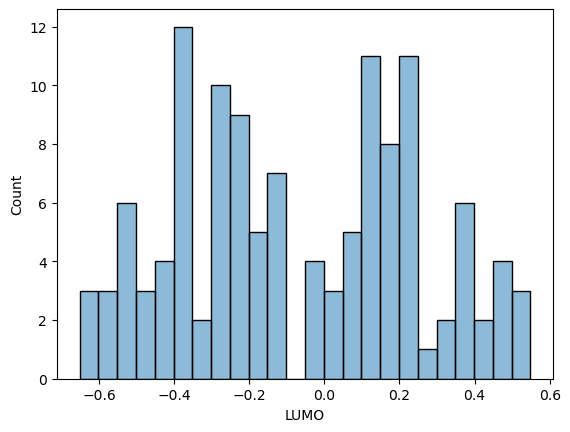

In [15]:
#highlight.plot(kind='barh', stacked=True, y='LUMO')
sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO', element="step", 
mask = highlight.drop('LUMO',axis=0).abs()>0.6
highlight.drop('LUMO')[ mask.values ]

In [16]:
Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)
display(X_prop,Y_prop)

rdk_MaxAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 8.163280   
[H]C(=O)c1nnc(C#N)nn1                                            9.918202   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                    10.223758   
[H]C(=O)c1nnc(C([H])=O)nn1                                       9.912782   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                             10.240765   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               4.981927   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               4.673308   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               5.064410   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  4.927222   

                                                    rdk_MinAbsEStateIndex  \
N#Cc1nnc(C#N)nn1                                                 0.139815   
[H]C(=O)c1nnc(C#N)nn1                                            0.125926   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                     0.236852   
[H]C(=O)c1nnc(C([H])=O)nn1                                       0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                              0.527778   
...                                                                   ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...               1.440000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...               1.625000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...               1.500000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]                  1.420000   

                                                    rdk_MinEStateIndex  \
N#Cc1nnc(C#N)nn1                                             -0.139815   
[H]C(=O)c1nnc(C#N)nn1                                        -0.147593   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                 -2.295839   
[H]C(=O)c1nnc(C([H])=O)nn1                                   -0.133704   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                          -2.390605   
...                                                                ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...            1.440000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...            1.625000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            2.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...            1.500000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]               1.420000   

                                                     rdk_qed    rdk_SPS  \
N#Cc1nnc(C#N)nn1                                    0.448932   7.800000   
[H]C(=O)c1nnc(C#N)nn1                               0.455954   8.300000   
[H]O[S@+]([O-])c1nnc(C#N)nn1                        0.522227  12.090909   
[H]C(=O)c1nnc(C([H])=O)nn1                          0.481498   8.800000   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                 0.540639  12.500000   
...                                                      ...        ...   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([...  0.406555  11.000000   
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C...  0.417276  11.000000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.542284  11.200000   
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H]...  0.527987  11.250000   
[H]C(/C([H])=C(\[H])N([H])[H])=C(/[H])N([H])[H]     0.436853  11.333333   

                                                    rdk_HeavyAtomMolWt  \
N#Cc1nnc(C#N)nn1                                               132.086   
[H]C(=O)c1nnc(C#N)nn1                                          134.078   
[H]O[S@+]([O-])c1nnc(C#N)nn1                                   170.133   
[H]C(=O)c1nnc(C([H])=O)nn1                                     136.070   
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1       

N#Cc1nnc(C#N)nn1                                                                              -4.5527
[H]C(=O)c1nnc(C#N)nn1                                                                         -4.2967
[H]O[S@+]([O-])c1nnc(C#N)nn1                                                                  -4.1931
[H]C(=O)c1nnc(C([H])=O)nn1                                                                    -4.1621
[H]OC(=O)c1nnc([S@@+]([O-])O[H])nn1                                                           -4.1484
                                                                                                ...  
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N([H])[H]                                          0.4591
[H]/C(OC([H])([H])[H])=C([H])\C([H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H]                    0.4841
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N(C([H])([H])[H])C([H])([H])[H]    0.6879
[H]C(/C([H])=C(\[H])N(C([H])([H])[H])C([H])([H])[H])=C(/[H])N([H])[H]             

Total Var  0.8139083885865348  from  13
Exp Var:  [0.16574089 0.12183605 0.09787397 0.0818234  0.06143698 0.05703231
 0.0474372  0.03988702 0.03461928 0.03183486 0.02690278 0.02443565
 0.023048  ]


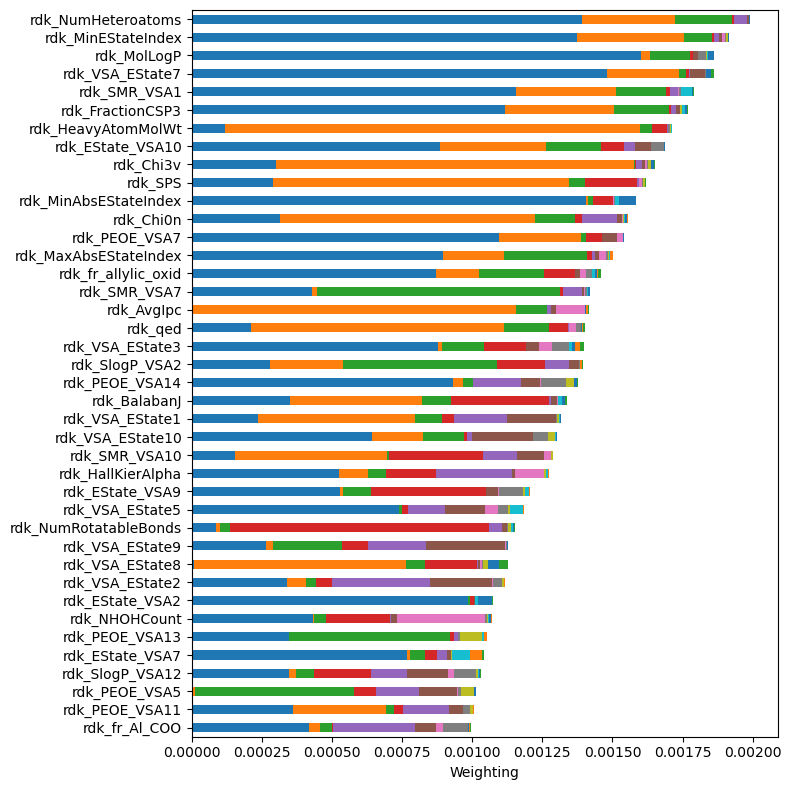

In [17]:
#X_features_prop_clean_scaled, scaler = get_std(X_features_prop_clean)
#display( X_features_prop_clean_scaled, Y_prop)
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)
#display(df2_pca, df2_pca_coef)

'In plot'

pc1       pc2       pc3       pc4       pc5  \
rdk_NumHeteroatoms  0.224989  0.149563  0.146390  0.032293 -0.108392   
rdk_MinEStateIndex -0.223723 -0.160389  0.101722 -0.032847  0.068532   
rdk_MolLogP        -0.241493  0.046977 -0.122089  0.039153 -0.015752   
rdk_VSA_EState7    -0.232227  0.131090 -0.053463 -0.036002  0.024729   
rdk_SMR_VSA1        0.205149  0.154754 -0.137124  0.042968  0.089815   
rdk_FractionCSP3   -0.201625  0.161699  0.143684 -0.026584  0.069747   
rdk_HeavyAtomMolWt  0.065367  0.315898  0.065407  0.089236 -0.039557   
rdk_EState_VSA10    0.179549  0.159335 -0.142777  0.112045  0.100442   
rdk_Chi3v          -0.104303  0.293423  0.023500  0.012901 -0.076126   
rdk_SPS            -0.102386  0.266665 -0.078681 -0.166222 -0.037639   

                         pc6       pc7       pc8       pc9      pc10  \
rdk_NumHeteroatoms -0.043775  0.000394 -0.014837 -0.007645 -0.036326   
rdk_MinEStateIndex  0.055385 -0.063732  0.046787 -0.076546  0.047804   
rdk_MolLogP         0.070344 -0.012611 -0.137524  0.048713  0.043391   
rdk_VSA_EState7     0.129068  0.030230 -0.040504 -0.025123 -0.008396   
rdk_SMR_VSA1       -0.007317  0.019853 -0.068437  0.018628  0.201079   
rdk_FractionCSP3   -0.070763  0.012000 -0.007068  0.058094  0.114446   
rdk_HeavyAtomMolWt  0.000238 -0.013384 -0.065992  0.031637 -0.064820   
rdk_EState_VSA10    0.132093  0.018165  0.167724  0.004613  0.009300   
rdk_Chi3v           0.053611  0.061122 -0.039016  0.096263 -0.012132   
rdk_SPS             0.006087  0.076701  0.028399  0.081089  0.029178   

                        pc11      pc12      pc13    length  
rdk_NumHeteroatoms  0.068339  0.016044 -0.006766  0.001991  
rdk_MinEStateIndex  0.046606 -0.004198  0.044378  0.001915  
rdk_MolLogP        -0.175727  0.014933  0.035021  0.001863  
rdk_VSA_EState7     0.148315 -0.038378  0.139792  0.001862  
rdk_SMR_VSA1        0.047478  0.044696  0.070807  0.001790  
rdk_FractionCSP3   -0.094552  0.037721 -0.054691  0.001769  
rdk_HeavyAtomMolWt -0.039803 -0.033362 -0.012126  0.001714  
rdk_EState_VSA10    0.073806 -0.028323 -0.021379  0.001687  
rdk_Chi3v          -0.126178 -0.052397 -0.048278  0.001651  
rdk_SPS             0.019645 -0.029274  0.063589  0.001619

0 rdk_NumHeteroatoms
1 rdk_MinEStateIndex
2 rdk_MolLogP
3 rdk_VSA_EState7
4 rdk_SMR_VSA1
5 rdk_FractionCSP3
6 rdk_HeavyAtomMolWt
7 rdk_EState_VSA10
8 rdk_Chi3v
9 rdk_SPS


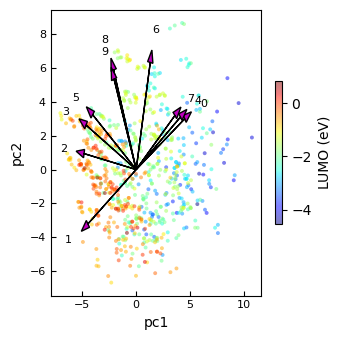

In [18]:
colors = Y_prop
#colors = [1 if s=='PNL' else 0 for s in Y_prop['source']]
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            feature_arrow=True, size=8, explained_var=exp_var, num_feature=10,)
           #save_to_file='Figure_PCA_PNL_rdk.png' )# yrange=[-5,10] )

In [24]:
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='rdk_',)# save_to_file='Figure_PCA_PNL_rdk_TopFeatures.png')


['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14']


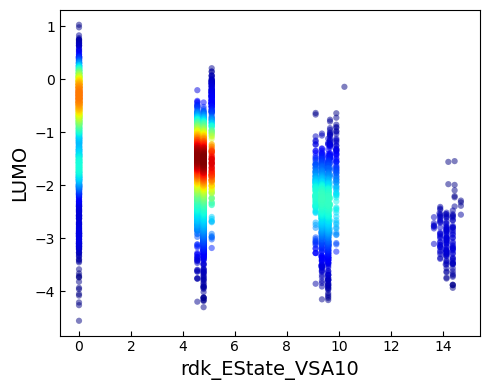

In [25]:
fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
xlabel = 'rdk_EState_VSA10'
y=np.array(df_pnl['LUMO'])
x= np.array(df_pnl[xlabel])
xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
#z = plt.cm.jet(z)    
im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
axs.set_ylabel('LUMO',fontsize=14) ## input X name
axs.set_xlabel(xlabel,fontsize=14) ## input Y name
axs.tick_params(direction='in',labelsize='10')
im

In [ ]:
### Explore pubchem FP
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'padelpy_PubchemFP' in c or 'RingCount_' in c ]    
X_features = df_pnl[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, xrange=[-10,8], yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_PNL_pubchem.png')

feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_PNL_pubchem_TopFeatures.png')

In [ ]:
### Explore padelpy descriptor
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'padelpy_PubchemFP' not in c and ('padelpy_' in c or 'RingCount_' in c) ]    
X_features = df_pnl[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_PNL_padelpy.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_PNL_padelpy_TopFeatures.png')

In [ ]:
### Explore ALLLL
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c ]    
X_features = df_pnl[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=10, explained_var=exp_var,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_PNL_everything.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_PNL_everything_TopFeatures.png')

### 2. QM9 C=CC=C

In [23]:
df_qm9 = df_diene_pattern[ df_diene_pattern['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)

## Keep rings >=5
ring = [ c for c in df_qm9.columns if 'RingCount_' in c ]

mask1 = np.all( [df_qm9['RingCount_3']==0, df_qm9['RingCount_4']==0], axis=0 )
mask2 = np.any( [df_qm9[r]==1 for r in ring ], axis=0 )
mask_keep = np.all( [mask1,mask2],axis=0 )
df_qm9 = df_qm9[mask_keep]

## Keep common atoms
good_elements = ['C','H','O','N','S']
mask_element = []   ## molecules to keep, keep=True
for smi in df_qm9['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    mask_element.append(all(e in good_elements for e in element))
df_qm9 = df_qm9[mask_element]

## Add ring info
NumRingAtom = np.zeros(len(df_qm9))
for r in ring:
    ring_num = int(r.split('_')[-1])
    idx = np.argwhere(df_qm9[r]==1).flatten()
    if len(idx)>0:
        NumRingAtom[ idx ] = ring_num
df_qm9['NumRingAtom'] = NumRingAtom

display( df_qm9 )

df_qm9.to_csv('df_final_qm9_cccc.csv')

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
9077  -6.930565 -2.854402   O=Cc1cc(=O)occ1    QM9                   True   
8920  -7.189067 -2.838076   O=c1occc(c1)C#N    QM9                   True   
9117  -7.009476 -2.816307   O=Cc1cccc(=O)o1    QM9                   True   
9048  -6.329209 -2.775491   O=CC(=O)n1cccc1    QM9                   True   
8804  -7.167298 -2.770049   O=c1oc(ccc1)C#N    QM9                   True   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
9077                   False                  False                  False   
8920                   False                  False                  False   
9117                   False                  False                  False   
9048                   False                  False                  False   
8804                   False                  False                  False   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
13875                  False                  False                  False   
14486                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
9077                   False                  False  ...   
8920                   False                  False  ...   
9117                   False                  False  ...   
9048                   False                  False  ...   
8804                   False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
13875                  False                  False  ...   
14486                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
9077                    0.0                   0.0                   0.0   
8920                    0.0                   0.0                   0.0   
9117                    0.0                   0.0                   0.0   
9048                    0.0                   0.0                   0.0   
8804                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876  padelpy_PubchemFP877  \
9077                    0.0                  0.0                   0.0   
8920                    0.0                  0.0                   0.0   
9117                    0.0                  0.0                   0.0   
9048                    0.0                  0.0                   0.0   
8804                    0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

In [24]:
fig, axs = plt.subplots( 1 ,1, figsize=(3.5,3.5))#tight_layout=True,dpi=100)

df = pd.read_csv('df_final_qm9_cccc.csv', index_col=0)
sns.histplot( df, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.3, fill=True, color='r', label='Style')#  )#, stat='percent', 
df = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
sns.histplot( df, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.3, fill=True, color='b', label='Style')#  )#, stat='percent', 
plt.show()

In [25]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)

colors = ['k','y','g','b','r','c']
x_range = [ n for n in range(5,10)]

fig, axs = plt.subplots( len(colors) ,1, figsize=(3.5,1*len(colors)), )#tight_layout=True,dpi=100)
sns.histplot( df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs[0], element="step", alpha=0.5, fill=True, color='k', label='No ring',)# stat='percent')
axs[0].set_xlabel('')
axs[0].set_xticklabels([])
axs[0].set_ylabel('')  
axs[0].tick_params(direction='in',labelsize=8)
axs[0].legend(fontsize=8, frameon=False, loc=2)
axs[0].set_xlim((-4,2.5))
    
ymax = [249, 39, 34, 7.9, 2.9]
for i,n in enumerate(x_range):
    df = df_qm9[ df_qm9['NumRingAtom']==n ] 
    sns.histplot( df, x='LUMO', kde=False, binwidth=0.1, ax=axs[i+1], element="step", alpha=0.3, fill=True, color=colors[i+1], label='Ring')#, stat='percent') 
    axs[i+1].set_xlabel('')
    axs[i+1].set_ylabel('')  
    axs[i+1].tick_params(direction='in',labelsize=8)
    axs[i+1].legend(fontsize=8, frameon=False, loc=2)
    axs[i+1].set_xlim((-4,2.5))
    axs[i+1].set_ylim(top=ymax[i])
    if i!=len(x_range)-1: axs[i+1].set_xticklabels([])
    handles, labels = axs[i+1].get_legend_handles_labels()
    labels = [f'Ring {int(n)}']
    axs[i+1].legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, loc=2)#, ncol=1, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs[-1].set_xlabel('LUMO (eV)', fontsize=10)
axs[3].set_ylabel('Data counts', fontsize=10)
axs[3].yaxis.set_label_coords(-0.08,1.01)

plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig("ML_PNL_CCCC_prediction_EWGEDG2.png", dpi=800) 
plt.show()

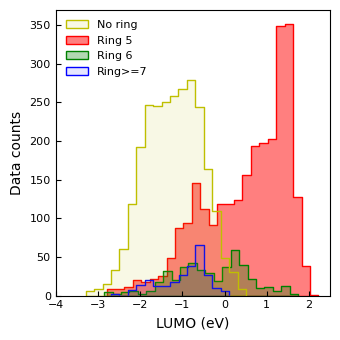

In [26]:
df = df_qm9.copy()
df['NumRingAtom'] = [ n if n<=6 else 999 for n in df['NumRingAtom'] ]

colors = ['r','g','b']
fig, axs = plt.subplots( 1 ,1, figsize=(3.5,3.5), tight_layout=True, )#dpi=100)
#sns.histplot( df, x='LUMO', hue='NumRingAtom', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.3, fill=True, palette=colors, label='Style')#  )#, stat='percent', multiple="stack", 
sns.histplot( df[df['NumRingAtom']==5], x='LUMO', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.5, fill=True, color='r', label='Ring 5')#  )#, stat='percent', multiple="stack", 
sns.histplot( df[df['NumRingAtom']==6], x='LUMO', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.3, fill=True, color='g', label='Ring 6')#  )#, stat='percent', multiple="stack", 
sns.histplot( df[df['NumRingAtom']>=7], x='LUMO', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.1, fill=True, color='b', label='Ring>=7')#  )#, stat='percent', multiple="stack", 

df = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
sns.histplot( df, x='LUMO', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.1, fill=True, color='y', label='No ring')#  )#, stat='percent', 

axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
axs.set_xlim((-4,2.5))

handles, labels = axs.get_legend_handles_labels()
#labels = ['Ring>=7','Ring 6','Ring 5','No ring']
axs.legend([handles[-1]]+handles[:-1], [labels[-1]]+labels[:-1], fontsize=8, frameon=False, loc=2)#, ncol=1, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)

axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.set_ylabel('Data counts', fontsize=10)

plt.savefig("QM9_Hist_Rings.png", dpi=800) 

plt.show()

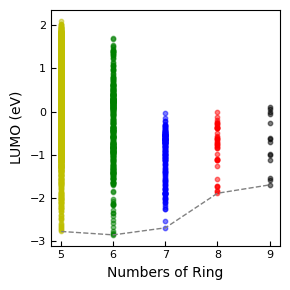

In [27]:
colors = ['y','g','b','r','k']

fig, axs = plt.subplots(1,1, figsize=(3.,3), tight_layout=True)

low_y=[]
for i,n in enumerate(x_range):
    df = df_qm9[ df_qm9['NumRingAtom']==n ]  
    x = np.full( len(df), n )
    y = df['LUMO']
    low_y.append(np.amin(y))
    #x,y,z = color_density(x, y)
    axs.scatter(x, y, marker='o', c=colors[i], cmap='jet', label='', alpha=0.5, s=10) 
axs.plot( x_range, low_y, ls='--', color='gray',lw=1)
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.set_xlabel('Numbers of Ring', fontsize=10)
axs.set_xticks( x_range )
plt.show()

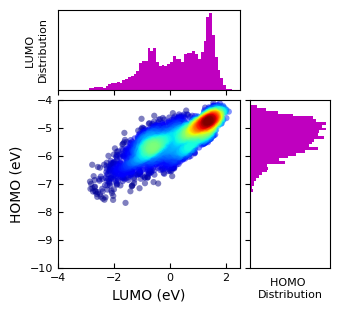

In [28]:
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,)#dpi=100)
x=np.array(df_qm9['LUMO'])
y= np.array(df_qm9['HOMO'])
xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
#z = plt.cm.jet(z)

im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
axs.set_aspect(1.)

axs.set_xlabel('LUMO (eV)',fontsize=10) ## input X name
axs.set_ylabel('HOMO (eV)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)
axs.set_xlim([-4,2.5])
axs.set_ylim([-10,-4])

divider = make_axes_locatable(axs)
extra_length = 0.8
axHistx = divider.append_axes("top", extra_length, pad=0.1, sharex=axs)
axHisty = divider.append_axes("right", extra_length, pad=0.1, sharey=axs)
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

## Hist info
binwidth = 0.1
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1)*binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins, color='m')
axHisty.hist(y, bins=bins, orientation='horizontal',color='m')

axHistx.set_ylabel('LUMO \nDistribution',fontsize=8)
axHisty.set_xlabel('HOMO \nDistribution',fontsize=8) 
#axHistx.set_ylim([0,620])
#axHisty.set_xlim([0,620])
axHistx.set_yticks([])
axHisty.set_xticks([])

plt.savefig("Figure_3_QM9_LUMOHOMO.png", dpi=800)     

plt.show()

Before clean (3382, 132)
After clean (3382, 121)
Num of keep:  87
Num of drop:  34
---------


LUMO
rdk_EState_VSA10 -0.681961

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8074227167162938  from  19
Exp Var:  [0.17404273 0.08202971 0.07579004 0.05828451 0.05286241 0.04640872
 0.04295507 0.04111052 0.03375272 0.02924761 0.0283728  0.02454407
 0.02219932 0.02101728 0.01788657 0.01547379 0.01476874 0.01358682
 0.01308927]


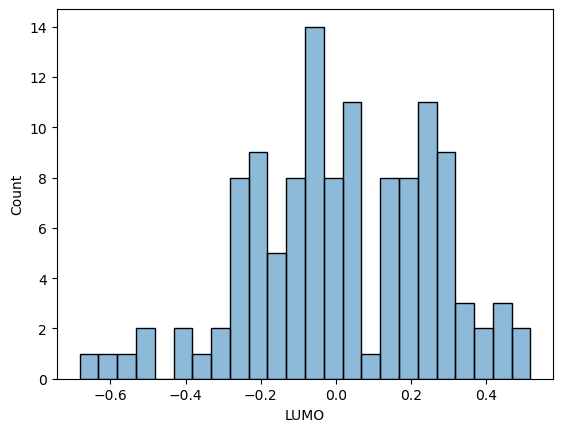

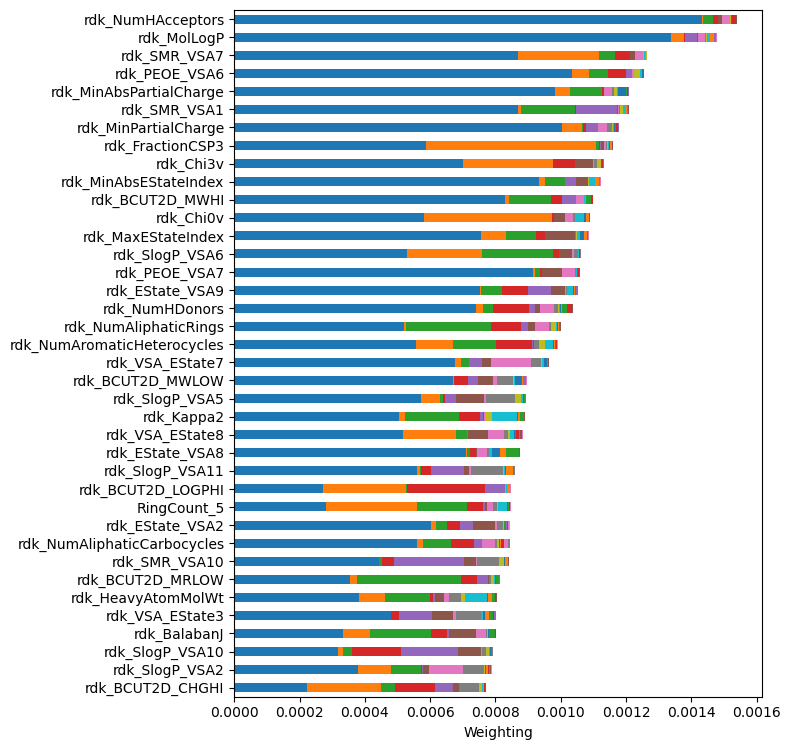

'In plot'

pc1       pc2       pc3       pc4       pc5  \
rdk_NumHAcceptors       -0.217405 -0.023446  0.072231  0.069708  0.018645   
rdk_MolLogP              0.210180 -0.075368 -0.021350 -0.024106 -0.114596   
rdk_SMR_VSA7             0.169281  0.192475  0.092235 -0.116212  0.015386   
rdk_PEOE_VSA6            0.184756  0.088291  0.100757  0.126675 -0.081557   
rdk_MinAbsPartialCharge -0.180077  0.081953  0.130342 -0.043152 -0.001829   
rdk_SMR_VSA1            -0.169472 -0.034143  0.169547 -0.039233 -0.211963   
rdk_MinPartialCharge     0.182058  0.094145  0.029001  0.047507  0.117140   
rdk_FractionCSP3         0.139204 -0.278418  0.041252 -0.011447 -0.044090   
rdk_Chi3v                0.152166 -0.202010  0.014669  0.140149  0.004215   
rdk_MinAbsEStateIndex    0.175422 -0.055594 -0.101724 -0.008998  0.109077   

                              pc6       pc7       pc8       pc9      pc10  \
rdk_NumHAcceptors        0.074984  0.115695 -0.001026 -0.035512 -0.014430   
rdk_MolLogP              0.029830  0.113283 -0.031925 -0.061046  0.090241   
rdk_SMR_VSA7            -0.081703  0.116031  0.001455  0.047688 -0.058152   
rdk_PEOE_VSA6            0.015752 -0.059088  0.008550 -0.120053 -0.102607   
rdk_MinAbsPartialCharge -0.023826  0.116183 -0.058797  0.091313  0.052757   
rdk_SMR_VSA1            -0.017319  0.047854  0.043672 -0.091362  0.094464   
rdk_MinPartialCharge    -0.020832 -0.119425 -0.092365 -0.064018 -0.048463   
rdk_FractionCSP3        -0.062900  0.058504  0.049078 -0.045914  0.032280   
rdk_Chi3v               -0.161291  0.032623 -0.073674  0.097981 -0.023466   
rdk_MinAbsEStateIndex    0.130652  0.015883 -0.014132  0.059278  0.136899   

                             pc11      pc12      pc13      pc14      pc15  \
rdk_NumHAcceptors       -0.054167 -0.051994  0.012387  0.151553  0.022391   
rdk_MolLogP             -0.014281  0.146380 -0.033013  0.017665  0.130830   
rdk_SMR_VSA7             0.053159 -0.023056  0.010758  0.039840 -0.067451   
rdk_PEOE_VSA6           -0.028788  0.056808 -0.021784 -0.006466 -0.011881   
rdk_MinAbsPartialCharge -0.174359  0.037823 -0.085426 -0.046155  0.104395   
rdk_SMR_VSA1             0.000906  0.081105 -0.042896 -0.033890 -0.059914   
rdk_MinPartialCharge    -0.072098  0.015781  0.062556  0.130897  0.033110   
rdk_FractionCSP3        -0.064549 -0.103549 -0.040202 -0.013808 -0.015653   
rdk_Chi3v                0.066978 -0.005818 -0.043361  0.083488 -0.065176   
rdk_MinAbsEStateIndex   -0.055393  0.135961  0.011581  0.039017  0.093385   

                             pc16      pc17      pc18      pc19    length  
rdk_NumHAcceptors        0.115369 -0.044959 -0.019875 -0.036535  0.001540  
rdk_MolLogP             -0.028039  0.094690  0.015293 -0.015556  0.001478  
rdk_SMR_VSA7             0.038919  0.012976 -0.016424  0.053088  0.001263  
rdk_PEOE_VSA6            0.039854  0.025862  0.007190 -0.015169  0.001254  
rdk_MinAbsPartialCharge -0.040160 -0.055886  0.050302 -0.012014  0.001210  
rdk_SMR_VSA1             0.094384  0.023194 -0.000343  0.016335  0.001208  
rdk_MinPartialCharge    -0.000527 -0.025163  0.026506  0.021124  0.001177  
rdk_FractionCSP3        -0.080388 -0.030466 -0.038760 -0.014233  0.001159  
rdk_Chi3v                0.017852  0.025315 -0.025236  0.010534  0.001132  
rdk_MinAbsEStateIndex    0.069060  0.026441  0.021949  0.109313  0.001124

0 rdk_NumHAcceptors
1 rdk_MolLogP
2 rdk_SMR_VSA7
3 rdk_PEOE_VSA6
4 rdk_MinAbsPartialCharge
5 rdk_SMR_VSA1
6 rdk_MinPartialCharge
7 rdk_FractionCSP3
8 rdk_Chi3v
9 rdk_MinAbsEStateIndex


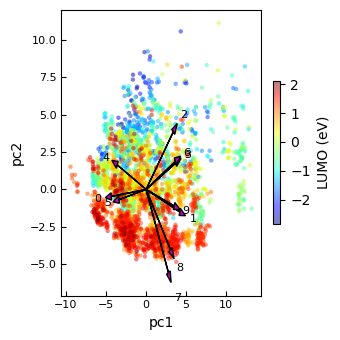

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19']


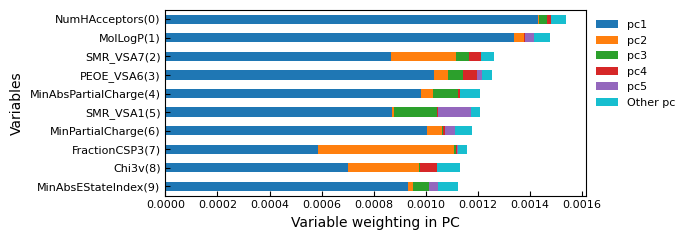

In [29]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'RingCount_' in c ]    
X_features = df_qm9[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=10, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_QM9_rdk.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='rdk_', save_to_file='Figure_PCA_QM9_rdk_TopFeatures.png')

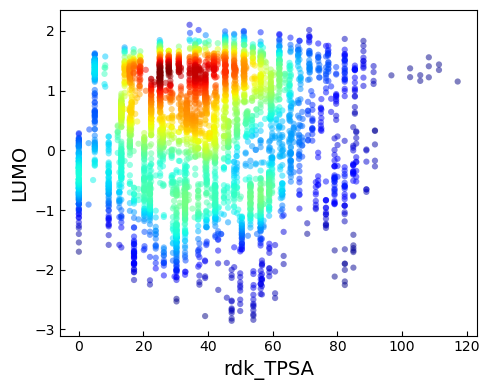

In [82]:
fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
xlabel = 'rdk_TPSA'
y=np.array(df_qm9['LUMO'])
x= np.array(df_qm9[xlabel])
xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
#z = plt.cm.jet(z)    
im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
axs.set_ylabel('LUMO',fontsize=14) ## input X name
axs.set_xlabel(xlabel,fontsize=14) ## input Y name
axs.tick_params(direction='in',labelsize='10')
im
def see_correlation(df, xlabel, ylabel='LUMO'):


Before clean (3382, 891)
After clean (3382, 367)
Num of keep:  185
Num of drop:  182
---------


Empty DataFrame
Columns: [LUMO]
Index: []

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8006657110369286  from  62
Exp Var:  [0.08266286 0.06203806 0.03813611 0.03595946 0.02918505 0.02545539
 0.02436555 0.01979404 0.01968638 0.01882118 0.01816409 0.01601918
 0.01523792 0.01489688 0.01357287 0.01282802 0.01272562 0.01237195
 0.01211822 0.01196519 0.01148573 0.01124148 0.01090348 0.01060856
 0.01015727 0.00971369 0.00962857 0.00931417 0.00905675 0.00882875
 0.00845087 0.00831735 0.00805786 0.00791085 0.0075931  0.00739607
 0.0072449  0.00720461 0.007167   0.00706457 0.00683054 0.00672558
 0.00658919 0.00637095 0.00627988 0.00623016 0.00607892 0.00589752
 0.0057109  0.00562584 0.00558468 0.0055793  0.00553041 0.00549312
 0.00547743 0.0054613  0.00542088 0.00539746 0.00530939 0.00528441
 0.00527459 0.00516362]


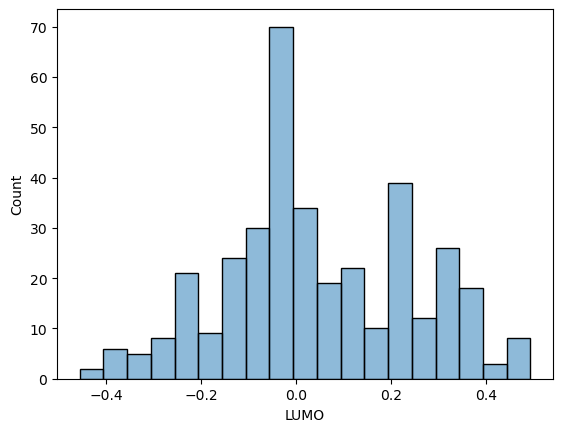

'In plot'

pc1       pc2       pc3       pc4       pc5  \
padelpy_PubchemFP657 -0.218295 -0.060897  0.032159 -0.015749  0.014402   
padelpy_PubchemFP376 -0.183932 -0.132025  0.067107 -0.023746 -0.096786   
padelpy_PubchemFP633 -0.190445 -0.100220  0.066645 -0.049426  0.026023   
padelpy_PubchemFP620  0.172988 -0.126763 -0.014604 -0.099109 -0.130980   
padelpy_PubchemFP535  0.172072 -0.091965 -0.004601 -0.196015  0.038321   
padelpy_PubchemFP14  -0.172823 -0.125841  0.042054 -0.086332  0.032247   
padelpy_PubchemFP666  0.171844 -0.124384 -0.042659 -0.058078 -0.056980   
padelpy_PubchemFP606  0.144792 -0.168206  0.047484  0.029009 -0.031557   
padelpy_PubchemFP539 -0.181890  0.005563  0.078439 -0.029435  0.017356   
padelpy_PubchemFP540 -0.183811 -0.041213 -0.033142 -0.018511 -0.004614   

                           pc6       pc7       pc8       pc9      pc10  ...  \
padelpy_PubchemFP657 -0.098920  0.058436  0.012555  0.047260  0.049286  ...   
padelpy_PubchemFP376  0.061816  0.012335 -0.019827 -0.055858  0.004440  ...   
padelpy_PubchemFP633  0.005256  0.141110  0.045183 -0.040564 -0.035273  ...   
padelpy_PubchemFP620  0.054749 -0.028274  0.031795 -0.038580  0.056081  ...   
padelpy_PubchemFP535  0.009041 -0.011967  0.084913  0.045219  0.023892  ...   
padelpy_PubchemFP14   0.052154  0.062680  0.007053 -0.026577 -0.004837  ...   
padelpy_PubchemFP666  0.038055 -0.036942 -0.022745 -0.013711  0.060603  ...   
padelpy_PubchemFP606  0.067988  0.074236 -0.021568 -0.001035 -0.044599  ...   
padelpy_PubchemFP539 -0.180920  0.088013 -0.082570  0.034190  0.015554  ...   
padelpy_PubchemFP540 -0.072093  0.032841  0.017482  0.029114  0.127038  ...   

                          pc54      pc55      pc56      pc57      pc58  \
padelpy_PubchemFP657 -0.003571 -0.001931  0.000169 -0.032521  0.031564   
padelpy_PubchemFP376 -0.004601  0.006072 -0.013320  0.004635 -0.011363   
padelpy_PubchemFP633 -0.012701  0.011372 -0.012986  0.009670 -0.034003   
padelpy_PubchemFP620 -0.003668 -0.004076 -0.000725  0.008017  0.007904   
padelpy_PubchemFP535  0.015824 -0.003287 -0.000950  0.023306 -0.003177   
padelpy_PubchemFP14   0.006613 -0.000369 -0.001132  0.041294 -0.003486   
padelpy_PubchemFP666 -0.062133  0.025267  0.005466 -0.085913  0.043513   
padelpy_PubchemFP606  0.008795 -0.003757 -0.004101 -0.009525  0.022389   
padelpy_PubchemFP539 -0.001689  0.000445 -0.021776  0.018682 -0.002891   
padelpy_PubchemFP540  0.005011 -0.019352 -0.000892 -0.005965  0.014076   

                          pc59      pc60      pc61      pc62    length  
padelpy_PubchemFP657  0.010879 -0.017711  0.007361  0.005639  0.000355  
padelpy_PubchemFP376  0.003258  0.010150 -0.016599 -0.001998  0.000323  
padelpy_PubchemFP633 -0.001150  0.026391 -0.020235 -0.010477  0.000315  
padelpy_PubchemFP620  0.000723 -0.000528 -0.019186 -0.005048  0.000303  
padelpy_PubchemFP535  0.008259 -0.057811  0.020997  0.007311  0.000294  
padelpy_PubchemFP14  -0.007712  0.009133 -0.041488 -0.003440  0.000290  
padelpy_PubchemFP666 -0.022534  0.060945 -0.054399 -0.011724  0.000284  
padelpy_PubchemFP606  0.008991 -0.011000  0.006322 -0.003882  0.000274  
padelpy_PubchemFP539 -0.005437 -0.000695 -0.038625  0.021998  0.000271  
padelpy_PubchemFP540  0.020202 -0.037469  0.007951 -0.001290  0.000266  

[10 rows x 63 columns]

0 padelpy_PubchemFP657
1 padelpy_PubchemFP376
2 padelpy_PubchemFP633
3 padelpy_PubchemFP620
4 padelpy_PubchemFP535
5 padelpy_PubchemFP14
6 padelpy_PubchemFP666
7 padelpy_PubchemFP606
8 padelpy_PubchemFP539
9 padelpy_PubchemFP540


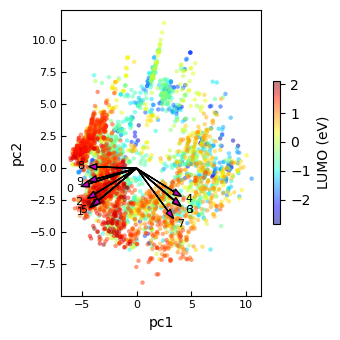

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38', 'pc39', 'pc40', 'pc41', 'pc42', 'pc43', 'pc44', 'pc45', 'pc46', 'pc47', 'pc48', 'pc49', 'pc50', 'pc51', 'pc52', 'pc53', 'pc54', 'pc55', 'pc56', 'pc57', 'pc58', 'pc59', 'pc60', 'pc61', 'pc62']


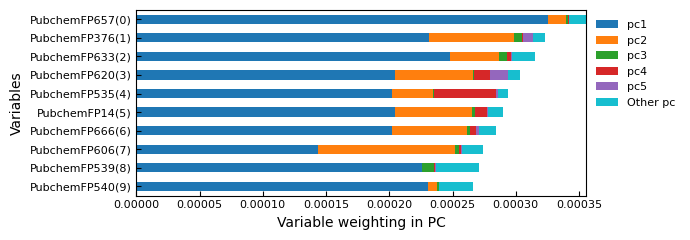

In [30]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'padelpy_PubchemFP' in c or 'RingCount_' in c ]  
X_features = df_qm9[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=10, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_QM9_pubchem.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_QM9_pubchem_TopFeatures.png')

Before clean (3382, 1391)
After clean (3382, 1014)
Num of keep:  308
Num of drop:  706
---------


LUMO
padelpy_AATS0v    -0.699963
padelpy_AATS1v    -0.743181
padelpy_AATS0p    -0.630876
padelpy_AATS1p    -0.611282
padelpy_GATS1m     0.644498
padelpy_GATS1e     0.684172
padelpy_GATS1s     0.697916
padelpy_nBondsS    0.633815
padelpy_nBondsD   -0.671951
padelpy_nBondsD2  -0.671951
padelpy_Mv        -0.681028
padelpy_Mp        -0.637006
padelpy_ndO       -0.692249
padelpy_SdO       -0.694536
padelpy_mindO     -0.676212
padelpy_maxdO     -0.676908
padelpy_piPC6     -0.612729
padelpy_nRotBt     0.609974
padelpy_RotBtFrac  0.638253

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8029990335396738  from  30
Exp Var:  [0.13674439 0.09433334 0.0702152  0.06058309 0.04332171 0.03652796
 0.03412614 0.03363989 0.02704501 0.02373025 0.02198399 0.02131191
 0.01942679 0.01786797 0.01541891 0.01417046 0.01366946 0.01175016
 0.01160475 0.011094   0.01074871 0.00970703 0.00922986 0.00910519
 0.00872984 0.00834137 0.00762607 0.00744581 0.00694199 0.00655779]


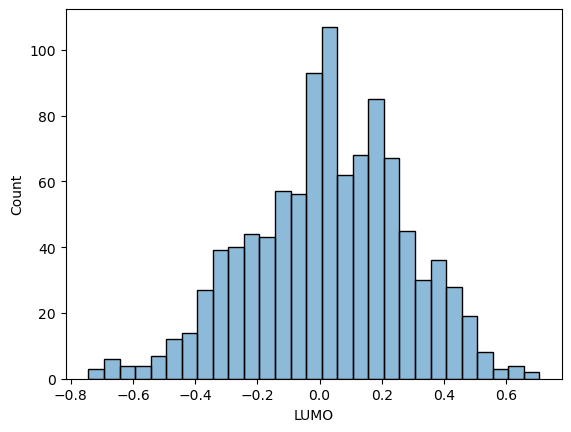

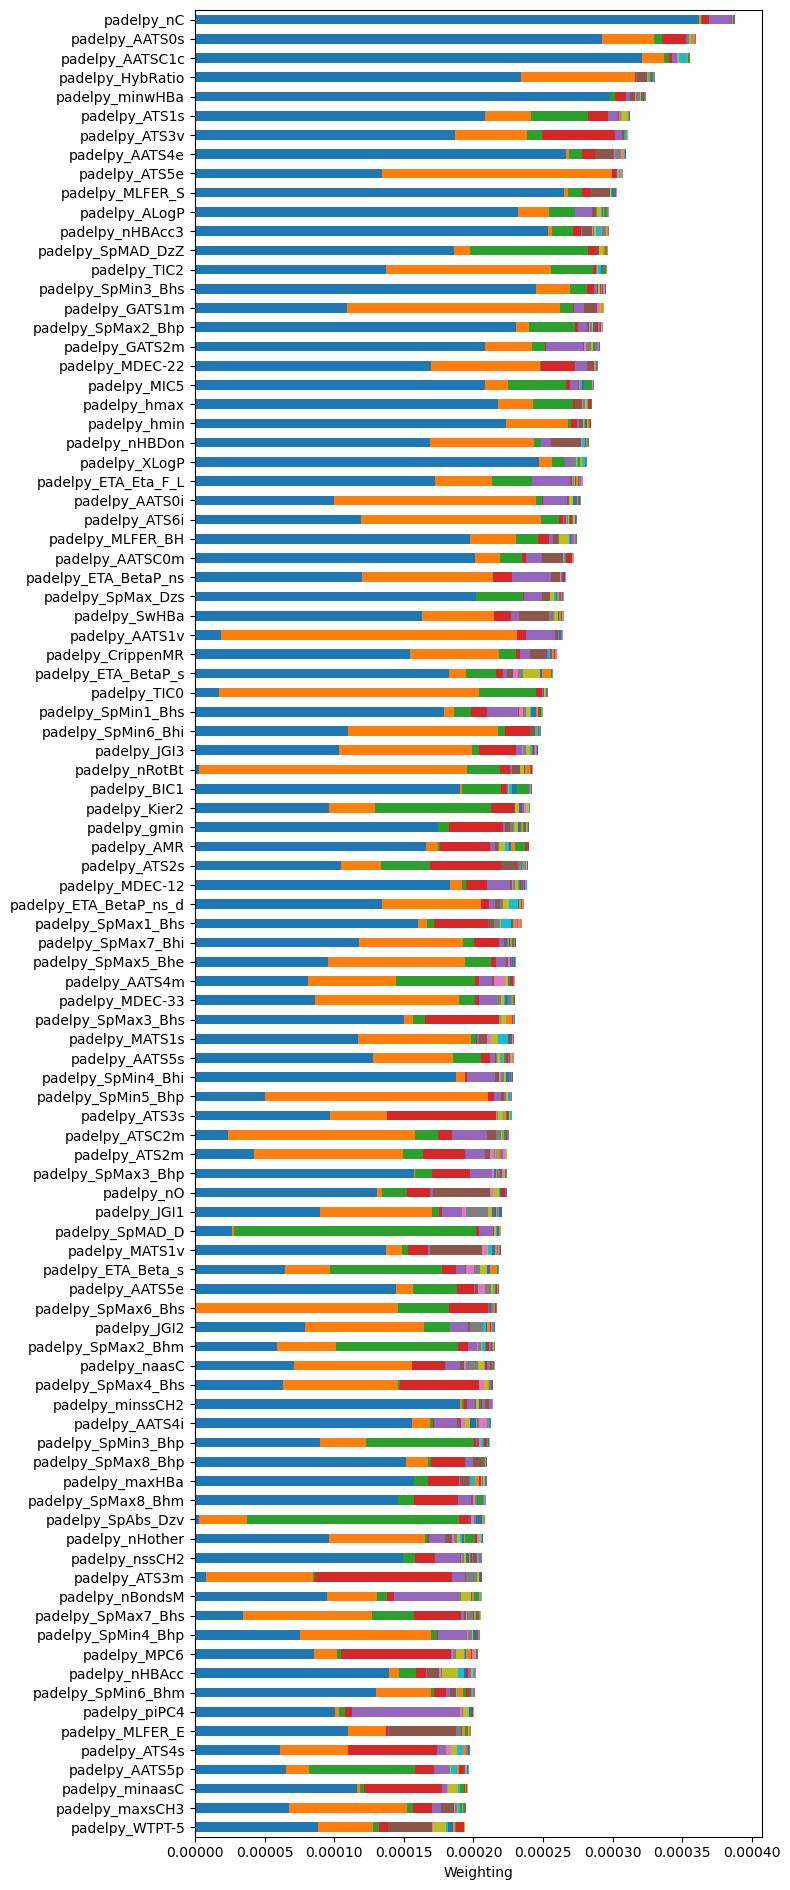

'In plot'

pc1       pc2       pc3       pc4       pc5       pc6  \
padelpy_nC        0.139065  0.013313  0.011851 -0.037586 -0.092092 -0.021475   
padelpy_AATS0s   -0.124969  0.064893 -0.033844 -0.069558 -0.021130  0.017603   
padelpy_AATSC1c   0.131013  0.041791  0.028380  0.023539 -0.044483  0.012741   
padelpy_HybRatio  0.111905 -0.095827 -0.002612  0.014268  0.020007  0.073780   
padelpy_minwHBa   0.126302  0.000961  0.025731  0.047332  0.037574 -0.050615   
padelpy_ATS1s    -0.105576 -0.060546 -0.091110 -0.062764 -0.063797 -0.023319   
padelpy_ATS3v     0.099871 -0.076467  0.045891 -0.119852 -0.051099 -0.036886   
padelpy_AATS4e   -0.119373  0.015913 -0.043809 -0.049546 -0.006236  0.100972   
padelpy_ATS5e     0.084759 -0.136068 -0.006699 -0.028380 -0.014468  0.018014   
padelpy_MLFER_S  -0.119014 -0.018173 -0.044789 -0.040632  0.011078 -0.102015   

                       pc7       pc8       pc9      pc10  ...      pc22  \
padelpy_nC       -0.000853 -0.004789 -0.032811 -0.002056  ...  0.006914   
padelpy_AATS0s    0.002508  0.017586 -0.048844 -0.035775  ...  0.005833   
padelpy_AATSC1c  -0.017825 -0.015278  0.030676 -0.095809  ...  0.020149   
padelpy_HybRatio -0.017973 -0.006980  0.010817 -0.040831  ...  0.049152   
padelpy_minwHBa  -0.026853 -0.051541  0.018988 -0.030786  ... -0.015549   
padelpy_ATS1s    -0.012874 -0.027976 -0.084844  0.030377  ... -0.035206   
padelpy_ATS3v     0.000620 -0.012745 -0.014096 -0.047312  ... -0.037089   
padelpy_AATS4e   -0.030037 -0.057294 -0.030166  0.030522  ...  0.040091   
padelpy_ATS5e    -0.021775 -0.018321 -0.020914 -0.034977  ... -0.031858   
padelpy_MLFER_S  -0.001481 -0.019640  0.020067 -0.038940  ...  0.013569   

                      pc23      pc24      pc25      pc26      pc27      pc28  \
padelpy_nC        0.000656  0.000257 -0.005530 -0.008467  0.006279  0.003087   
padelpy_AATS0s    0.034013 -0.008897 -0.009690 -0.004661  0.014587  0.004263   
padelpy_AATSC1c  -0.061269  0.003856 -0.005219 -0.009473 -0.039013  0.011117   
padelpy_HybRatio  0.000212 -0.015635 -0.028311  0.051131  0.042454 -0.022543   
padelpy_minwHBa   0.026679  0.019884  0.058557 -0.014488  0.029633  0.047728   
padelpy_ATS1s     0.030668 -0.011272  0.005447  0.006630  0.014820  0.020496   
padelpy_ATS3v     0.009080  0.009925  0.001087  0.023020  0.007356 -0.024827   
padelpy_AATS4e    0.002058 -0.009124 -0.019756  0.021511 -0.006704  0.004690   
padelpy_ATS5e     0.046010  0.035957  0.030414 -0.003197  0.022613  0.001378   
padelpy_MLFER_S   0.028560 -0.008807 -0.020014  0.002795  0.018210 -0.009865   

                      pc29      pc30    length  
padelpy_nC       -0.011861 -0.020163  0.000388  
padelpy_AATS0s   -0.004679 -0.023215  0.000360  
padelpy_AATSC1c   0.037532  0.012950  0.000356  
padelpy_HybRatio  0.035466  0.023656  0.000330  
padelpy_minwHBa   0.006669  0.055880  0.000324  
padelpy_ATS1s     0.003206  0.019457  0.000313  
padelpy_ATS3v     0.000967  0.003168  0.000311  
padelpy_AATS4e   -0.018280 -0.039551  0.000310  
padelpy_ATS5e     0.021320 -0.006778  0.000308  
padelpy_MLFER_S  -0.042662 -0.069568  0.000303  

[10 rows x 31 columns]

0 padelpy_nC
1 padelpy_AATS0s
2 padelpy_AATSC1c
3 padelpy_HybRatio
4 padelpy_minwHBa
5 padelpy_ATS1s
6 padelpy_ATS3v
7 padelpy_AATS4e
8 padelpy_ATS5e
9 padelpy_MLFER_S


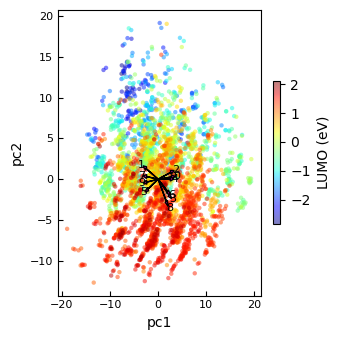

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30']


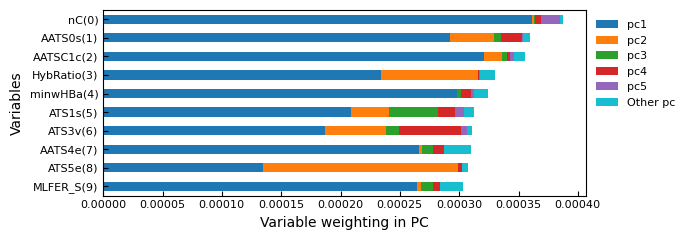

In [31]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'padelpy_PubchemFP' not in c and ('padelpy_' in c or 'RingCount_' in c) ]    
X_features = df_qm9[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=10, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_QM9_padelpy.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_QM9_padelpy_TopFeatures.png')

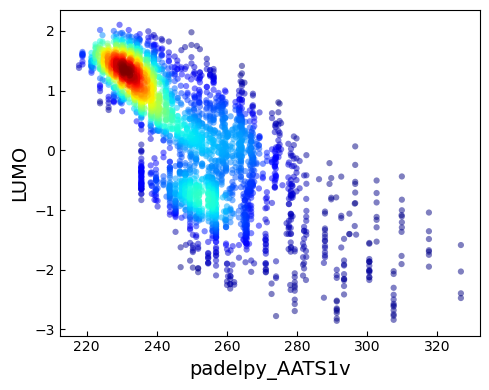

In [188]:
see_correlation(df_qm9, 'padelpy_AATS1v', ylabel='LUMO')


Before clean (3382, 2394)
After clean (3382, 1490)
Num of keep:  524
Num of drop:  966
---------


LUMO
rdk_EState_VSA10  -0.681961
padelpy_AATS0v    -0.699963
padelpy_AATS1v    -0.743181
padelpy_AATS0p    -0.630876
padelpy_AATS1p    -0.611282
padelpy_GATS1m     0.644498
padelpy_GATS1e     0.684172
padelpy_GATS1s     0.697916
padelpy_nBondsS    0.633815
padelpy_nBondsD   -0.671951
padelpy_nBondsD2  -0.671951
padelpy_Mv        -0.681028
padelpy_Mp        -0.637006
padelpy_ndO       -0.692249
padelpy_SdO       -0.694536
padelpy_mindO     -0.676212
padelpy_maxdO     -0.676908
padelpy_piPC6     -0.612729
padelpy_nRotBt     0.609974
padelpy_RotBtFrac  0.638253

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8006804737771327  from  61
Exp Var:  [0.11009226 0.06827487 0.0508672  0.04639283 0.03927372 0.03457946
 0.02891076 0.02574581 0.0223856  0.0213973  0.02024836 0.01848091
 0.0165648  0.01537962 0.01377964 0.01318075 0.01250902 0.01139243
 0.01021472 0.00985498 0.00936002 0.00909687 0.00853722 0.00820571
 0.00808834 0.0078199  0.00716984 0.00692564 0.006743   0.00637201
 0.00604201 0.00598614 0.00587175 0.00578719 0.00560007 0.00534564
 0.00518905 0.00507861 0.0050152  0.00479122 0.004724   0.00452877
 0.00438534 0.00437056 0.00428503 0.00414989 0.00407268 0.00394188
 0.00381304 0.00366238 0.00364271 0.00358355 0.00352893 0.00347125
 0.00338708 0.00327278 0.00317919 0.00311694 0.00306653 0.00302658
 0.00292086]


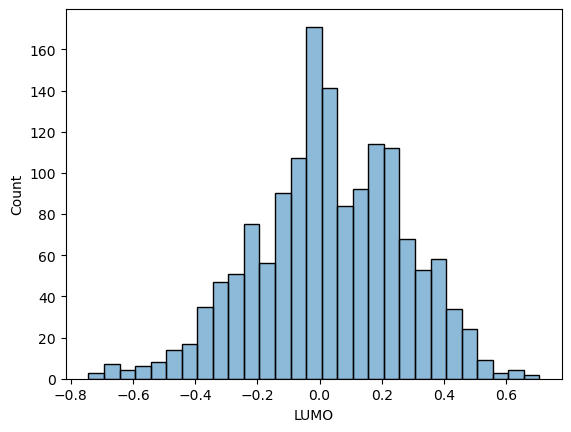

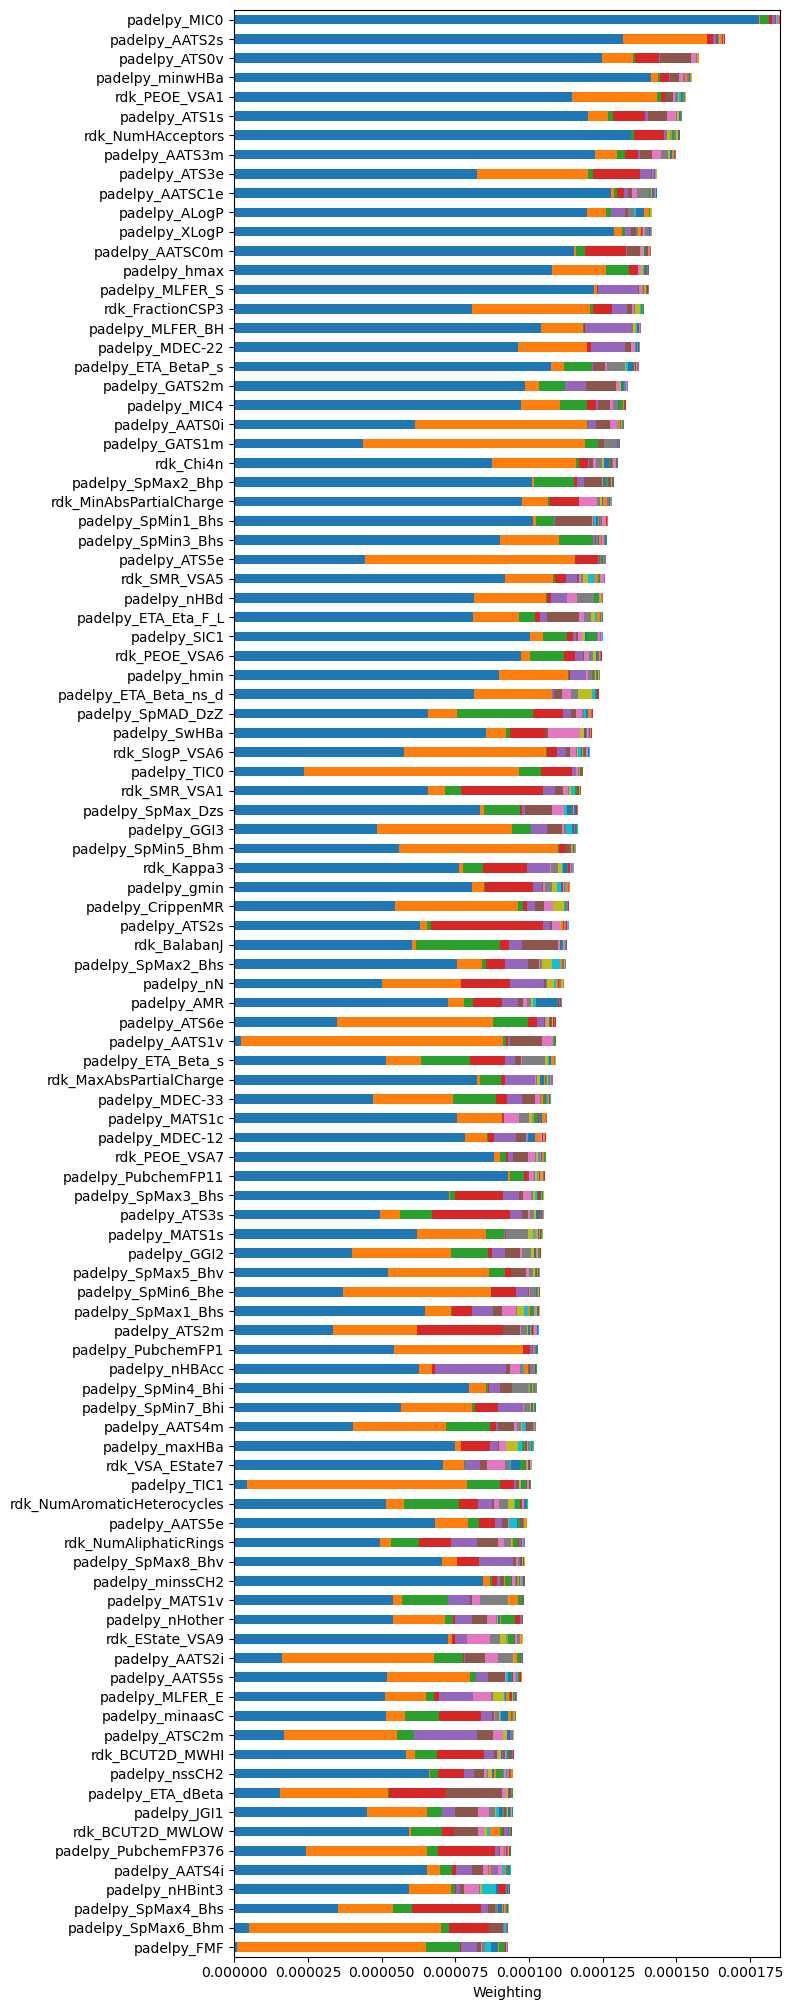

'In plot'

pc1       pc2       pc3       pc4       pc5       pc6  \
padelpy_MIC0      -0.121215  0.005646 -0.035842 -0.019390  0.028434  0.012978   
padelpy_AATS2s    -0.104366  0.078128 -0.003021 -0.029026  0.028540 -0.021106   
padelpy_ATS0v      0.101429 -0.047916 -0.014474 -0.061420  0.015191 -0.094564   
padelpy_minwHBa    0.107971 -0.023668 -0.012044  0.038816 -0.009909  0.050920   
rdk_PEOE_VSA1     -0.097183 -0.078654 -0.024699 -0.024767  0.000504  0.047156   
padelpy_ATS1s     -0.099546 -0.038134 -0.025707 -0.070921  0.025311 -0.073440   
rdk_NumHAcceptors -0.105361 -0.000098 -0.021025 -0.068400 -0.019044  0.014970   
padelpy_AATS3m    -0.100512  0.039442  0.032390 -0.046545 -0.021921 -0.057585   
padelpy_ATS3e      0.082362 -0.090045  0.026386 -0.085648  0.050158  0.015605   
padelpy_AATSC1e    0.102714  0.013532 -0.019464  0.035191 -0.027694 -0.033638   

                        pc7       pc8       pc9      pc10  ...      pc53  \
padelpy_MIC0       0.018781 -0.015440 -0.009582 -0.002735  ... -0.012787   
padelpy_AATS2s     0.013730  0.018469  0.021116 -0.010270  ...  0.009801   
padelpy_ATS0v     -0.041776 -0.023621  0.026681 -0.006285  ... -0.002405   
padelpy_minwHBa   -0.043927 -0.026362  0.010282  0.007529  ... -0.031689   
rdk_PEOE_VSA1     -0.026178  0.040401  0.023391  0.041408  ...  0.033230   
padelpy_ATS1s     -0.059144  0.022094  0.037911 -0.013984  ... -0.016528   
rdk_NumHAcceptors  0.006376 -0.023465  0.043189  0.026047  ...  0.009737   
padelpy_AATS3m    -0.058673 -0.062604  0.029100  0.018411  ... -0.009356   
padelpy_ATS3e      0.012217  0.023959 -0.019488 -0.013661  ... -0.002105   
padelpy_AATSC1e    0.043355 -0.079064 -0.009637 -0.005775  ...  0.010174   

                       pc54      pc55      pc56      pc57      pc58      pc59  \
padelpy_MIC0      -0.007621 -0.021525  0.012406 -0.002509 -0.004196  0.013123   
padelpy_AATS2s     0.005599  0.019594  0.025432 -0.018138 -0.007704  0.020529   
padelpy_ATS0v     -0.003096 -0.003837 -0.016144  0.000536  0.010712 -0.012234   
padelpy_minwHBa   -0.014219 -0.002149 -0.002831  0.006373 -0.013381  0.023945   
rdk_PEOE_VSA1     -0.033270  0.026870  0.010067  0.017890 -0.007369 -0.015793   
padelpy_ATS1s     -0.007774  0.010855  0.006487  0.001638 -0.007815  0.001597   
rdk_NumHAcceptors  0.012045 -0.006220 -0.011983 -0.003878 -0.000580 -0.018185   
padelpy_AATS3m     0.019257 -0.005047 -0.003301  0.000691 -0.000678  0.015077   
padelpy_ATS3e     -0.015247  0.000155 -0.010350  0.001827  0.009449  0.005745   
padelpy_AATSC1e    0.004581 -0.020255 -0.000728  0.016231 -0.031910 -0.044025   

                       pc60      pc61    length  
padelpy_MIC0      -0.005574  0.005641  0.000185  
padelpy_AATS2s     0.000512  0.010134  0.000167  
padelpy_ATS0v      0.002301 -0.003990  0.000158  
padelpy_minwHBa   -0.039835  0.002890  0.000155  
rdk_PEOE_VSA1     -0.024226  0.007020  0.000153  
padelpy_ATS1s     -0.008464  0.010089  0.000152  
rdk_NumHAcceptors -0.025175 -0.023354  0.000151  
padelpy_AATS3m     0.024688 -0.009581  0.000150  
padelpy_ATS3e     -0.007126 -0.002159  0.000143  
padelpy_AATSC1e   -0.029062  0.027916  0.000143  

[10 rows x 62 columns]

0 padelpy_MIC0
1 padelpy_AATS2s
2 padelpy_ATS0v
3 padelpy_minwHBa
4 rdk_PEOE_VSA1
5 padelpy_ATS1s
6 rdk_NumHAcceptors
7 padelpy_AATS3m
8 padelpy_ATS3e
9 padelpy_AATSC1e


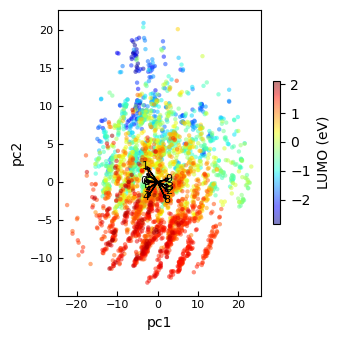

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38', 'pc39', 'pc40', 'pc41', 'pc42', 'pc43', 'pc44', 'pc45', 'pc46', 'pc47', 'pc48', 'pc49', 'pc50', 'pc51', 'pc52', 'pc53', 'pc54', 'pc55', 'pc56', 'pc57', 'pc58', 'pc59', 'pc60', 'pc61']


In [32]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c ]    
X_features = df_qm9[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=10, explained_var=exp_var, num_feature=10,
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_QM9_everything.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_QM9_everything_TopFeatures.png')

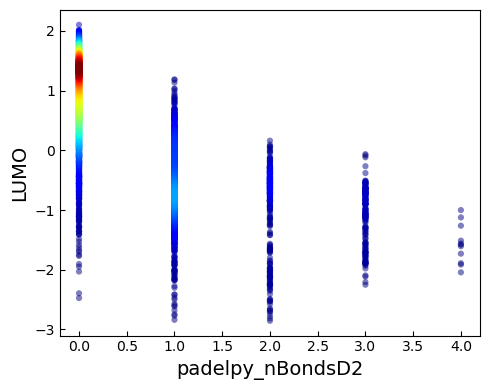

In [38]:
see_correlation(df_qm9, 'padelpy_nBondsD2', ylabel='LUMO')

### 3. Both PNL and QM9

In [33]:
#df_pnl = df_diene_pattern[ df_diene_pattern['source'] =='PNL' ].sort_values(by='LUMO',ascending=True)
#df_qm9 = df_diene_pattern[ df_diene_pattern['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)

df_both = pd.concat([df_pnl,df_qm9], axis=0)
df_both

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
257   -7.844547 -3.291623  C=C/C(C#N)=C\C=O    PNL                   True   
1375  -7.729353 -3.250645   N#C/C=C/C=C\C=O    PNL                   True   
4352  -7.672307 -3.163207   N#C/C=C\C=C\C=O    PNL                   True   
2759  -7.781885 -3.136265  C=C/C(C=O)=C\C#N    PNL                   True   
1759  -7.776203 -3.126049  C=C/C(C#N)=C/C=O    PNL                   True   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
257                    False                  False                  False   
1375                   False                  False                  False   
4352                   False                  False                  False   
2759                   False                  False                  False   
1759                   False                  False                  False   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
13875                  False                  False                  False   
14486                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
257                    False                  False  ...   
1375                   False                  False  ...   
4352                   False                  False  ...   
2759                   False                  False  ...   
1759                   False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
13875                  False                  False  ...   
14486                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
257                     0.0                   0.0                   0.0   
1375                    0.0                   0.0                   0.0   
4352                    0.0                   0.0                   0.0   
2759                    0.0                   0.0                   0.0   
1759                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876  padelpy_PubchemFP877  \
257                     0.0                  0.0                   0.0   
1375                    0.0                  0.0                   0.0   
4352                    0.0                  0.0                   0.0   
2759                    0.0                  0.0                   0.0   
1759                    0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

Before clean (5965, 123)
After clean (5965, 118)
Num of keep:  83
Num of drop:  35
---------


LUMO
rdk_EState_VSA10            -0.639360
rdk_NumAromaticHeterocycles  0.651685

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8068958039132906  from  18
Exp Var:  [0.1565391  0.1350058  0.08577513 0.06074726 0.05042988 0.03728259
 0.03538815 0.03270104 0.03128974 0.02973831 0.02675213 0.02343082
 0.02086284 0.01878107 0.01768154 0.0159538  0.01427755 0.01425905]


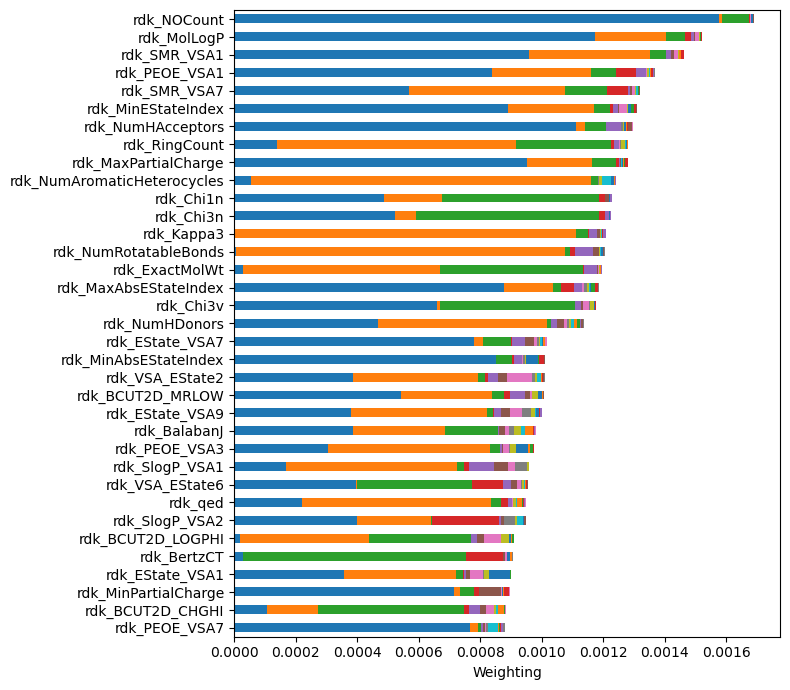

'In plot'

pc1       pc2       pc3       pc4       pc5  \
rdk_NOCount                 -0.253704 -0.022928  0.108690  0.026619 -0.017769   
rdk_MolLogP                  0.218644  0.113060  0.091441 -0.068971 -0.066977   
rdk_SMR_VSA1                -0.197714  0.147226  0.083064 -0.001368  0.082373   
rdk_PEOE_VSA1               -0.184751 -0.133361  0.104226  0.131894 -0.113378   
rdk_SMR_VSA7                 0.152226  0.166830  0.136169 -0.136808 -0.047838   
rdk_MinEStateIndex           0.190561 -0.123860 -0.084345  0.046881 -0.080034   
rdk_NumHAcceptors           -0.212941  0.039806  0.096027  0.006133 -0.138775   
rdk_RingCount                0.075144 -0.206347  0.205664 -0.048582  0.076508   
rdk_MaxPartialCharge        -0.197066  0.107713  0.101877 -0.053177  0.044858   
rdk_NumAromaticHeterocycles -0.046721 -0.246403  0.053060  0.001949  0.025301   

                                  pc6       pc7       pc8       pc9      pc10  \
rdk_NOCount                  0.013704 -0.044754  0.011312 -0.032190 -0.001008   
rdk_MolLogP                 -0.037121  0.109131  0.020051  0.038328 -0.018225   
rdk_SMR_VSA1                -0.071701  0.103558  0.033557  0.040009  0.042328   
rdk_PEOE_VSA1               -0.005030  0.063820  0.025618 -0.058218  0.069830   
rdk_SMR_VSA7                -0.074956 -0.075882 -0.017988 -0.068236  0.077202   
rdk_MinEStateIndex          -0.051493 -0.147403 -0.005758  0.043344 -0.028403   
rdk_NumHAcceptors            0.004397 -0.013227  0.072980  0.066445 -0.006492   
rdk_RingCount                0.006342 -0.062784  0.060017  0.102965  0.062220   
rdk_MaxPartialCharge         0.019157 -0.039529  0.025036  0.021753 -0.032742   
rdk_NumAromaticHeterocycles -0.013581 -0.024035 -0.031266  0.105095 -0.179280   

                                 pc11      pc12      pc13      pc14      pc15  \
rdk_NOCount                  0.072315 -0.018831 -0.024415 -0.073976  0.035175   
rdk_MolLogP                 -0.039451  0.007744  0.040493 -0.094902 -0.036602   
rdk_SMR_VSA1                -0.020632  0.088688  0.072173 -0.145280  0.033642   
rdk_PEOE_VSA1               -0.015966  0.068198 -0.024142 -0.128498  0.102964   
rdk_SMR_VSA7                -0.033615  0.045279 -0.037077  0.078642 -0.045515   
rdk_MinEStateIndex          -0.118681 -0.026231  0.134906 -0.159848 -0.026425   
rdk_NumHAcceptors           -0.098033 -0.065283  0.047339 -0.073034  0.050713   
rdk_RingCount                0.072548  0.075130 -0.000402 -0.041482 -0.031235   
rdk_MaxPartialCharge         0.073204 -0.093434 -0.042091 -0.170888  0.016311   
rdk_NumAromaticHeterocycles  0.126738  0.055957  0.000266 -0.079564  0.017973   

                                 pc16      pc17      pc18    length  
rdk_NOCount                  0.082211 -0.005498 -0.031287  0.001690  
rdk_MolLogP                  0.037371 -0.019050 -0.014526  0.001520  
rdk_SMR_VSA1                -0.039901  0.024957 -0.009668  0.001461  
rdk_PEOE_VSA1               -0.055653 -0.011639 -0.129005  0.001367  
rdk_SMR_VSA7                -0.049664 -0.017067 -0.078024  0.001319  
rdk_MinEStateIndex           0.066062  0.007805  0.022156  0.001309  
rdk_NumHAcceptors            0.234200  0.083152  0.018797  0.001296  
rdk_RingCount                0.047444 -0.037458  0.036151  0.001281  
rdk_MaxPartialCharge        -0.019075  0.051131  0.033995  0.001280  
rdk_NumAromaticHeterocycles  0.056905 -0.099873  0.035158  0.001242

0 rdk_NOCount
1 rdk_MolLogP
2 rdk_SMR_VSA1
3 rdk_PEOE_VSA1
4 rdk_SMR_VSA7
5 rdk_MinEStateIndex
6 rdk_NumHAcceptors
7 rdk_RingCount
8 rdk_MaxPartialCharge
9 rdk_NumAromaticHeterocycles


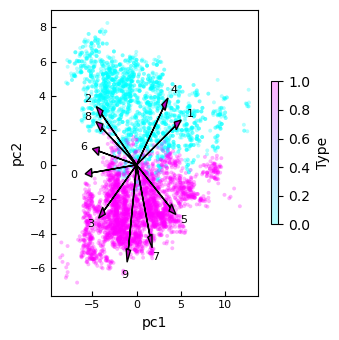

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18']


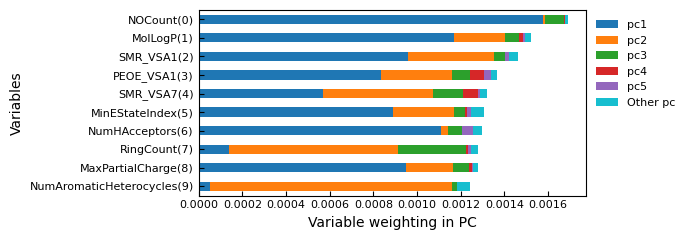

In [34]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_both.columns if 'rdk_' in c ]#or 'RingCount_' in c ]    
X_features = df_both[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

colors = [ 0 if d=='PNL' else 1 for d in df_both['source'] ]
#colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10, data_alpha=0.3, color_map='cool', cbar_label='Type',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_both_rdk.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='rdk_', save_to_file='Figure_PCA_both_rdk_TopFeatures.png')

Before clean (5965, 891)
After clean (5965, 391)
Num of keep:  208
Num of drop:  183
---------


LUMO
RingCount_5           0.691621
padelpy_PubchemFP143  0.691621
padelpy_PubchemFP146  0.692907
padelpy_PubchemFP256  0.651332
padelpy_PubchemFP376  0.679054
padelpy_PubchemFP449  0.627852
padelpy_PubchemFP464  0.605929
padelpy_PubchemFP545  0.651245
padelpy_PubchemFP549  0.653662
padelpy_PubchemFP592  0.634406
padelpy_PubchemFP600  0.627783
padelpy_PubchemFP607  0.650580
padelpy_PubchemFP628  0.619969
padelpy_PubchemFP633  0.630067
padelpy_PubchemFP665  0.632995

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8012195658862205  from  71
Exp Var:  [0.0836208  0.06749343 0.04211326 0.03199585 0.02219274 0.02042251
 0.01943044 0.01802227 0.01656919 0.01610979 0.01546282 0.01453319
 0.01372575 0.01314232 0.01274202 0.01250598 0.0121549  0.01158196
 0.01119115 0.01106484 0.01053508 0.01025512 0.01003755 0.00977528
 0.00958449 0.00923235 0.00909996 0.00889981 0.00867967 0.00849318
 0.00828374 0.0081873  0.00806374 0.00776685 0.00749582 0.00739372
 0.00733888 0.00713232 0.00682648 0.0066802  0.00651572 0.00648572
 0.0063841  0.0062894  0.00624234 0.00615082 0.00589223 0.00582743
 0.00576223 0.0056872  0.00559596 0.00543432 0.00534698 0.00529519
 0.00512655 0.00509822 0.00504284 0.00500767 0.0049349  0.00491087
 0.00487877 0.00486655 0.00485001 0.0048355  0.00482376 0.00480423
 0.0047476  0.00471329 0.00467708 0.00460968 0.00454564]


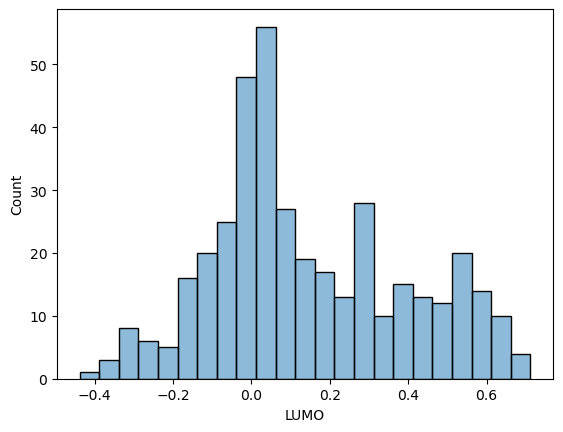

'In plot'

pc1       pc2       pc3       pc4       pc5  \
padelpy_PubchemFP381  0.198361  0.047496 -0.029663  0.086990 -0.062941   
padelpy_PubchemFP143  0.192840 -0.074859  0.012645 -0.026448 -0.077123   
padelpy_PubchemFP633  0.154369 -0.168135  0.012287 -0.035438 -0.009371   
padelpy_PubchemFP589  0.164606  0.130093 -0.011297 -0.060475 -0.063870   
padelpy_PubchemFP520  0.172301 -0.053331  0.162507  0.008203 -0.055365   
padelpy_PubchemFP390  0.101068 -0.202360 -0.013628 -0.034439  0.014481   
padelpy_PubchemFP597  0.156620  0.117834  0.020546 -0.132752 -0.052300   
padelpy_PubchemFP655  0.170042  0.081181  0.056511  0.071670 -0.133510   
padelpy_PubchemFP393  0.148235 -0.134016 -0.002784 -0.065553 -0.034089   
padelpy_PubchemFP351  0.130450 -0.158906 -0.012424 -0.074271 -0.024054   

                           pc6       pc7       pc8       pc9      pc10  ...  \
padelpy_PubchemFP381  0.015091 -0.052967  0.014781 -0.028296 -0.020094  ...   
padelpy_PubchemFP143 -0.029963 -0.087188 -0.103146 -0.027252  0.113237  ...   
padelpy_PubchemFP633 -0.068809  0.027740  0.035118 -0.035432  0.032984  ...   
padelpy_PubchemFP589  0.021097 -0.088117  0.006107 -0.042071  0.010750  ...   
padelpy_PubchemFP520 -0.005951 -0.016008  0.093279  0.005884  0.128628  ...   
padelpy_PubchemFP390 -0.064417  0.047750 -0.021220 -0.016863  0.021734  ...   
padelpy_PubchemFP597  0.027166 -0.102986 -0.027870  0.025064  0.036582  ...   
padelpy_PubchemFP655 -0.036373  0.017549  0.005572 -0.152532 -0.003194  ...   
padelpy_PubchemFP393  0.014782  0.016182  0.032036 -0.000923 -0.013266  ...   
padelpy_PubchemFP351 -0.025058 -0.001163  0.001467 -0.038538 -0.008073  ...   

                          pc63      pc64      pc65      pc66      pc67  \
padelpy_PubchemFP381  0.019467 -0.006973 -0.001223 -0.011460  0.012783   
padelpy_PubchemFP143 -0.004984 -0.005956  0.021421  0.000298 -0.010667   
padelpy_PubchemFP633 -0.006113 -0.000832  0.018462  0.004933 -0.029882   
padelpy_PubchemFP589  0.017268 -0.031401  0.012985 -0.018540  0.013608   
padelpy_PubchemFP520 -0.016236 -0.037544  0.049792 -0.013000 -0.019777   
padelpy_PubchemFP390  0.029162  0.017850 -0.024732  0.018767 -0.032881   
padelpy_PubchemFP597 -0.000473  0.032133 -0.027796  0.008653  0.017021   
padelpy_PubchemFP655 -0.008023  0.001972  0.000479 -0.003729 -0.001476   
padelpy_PubchemFP393 -0.005667  0.014823 -0.013421  0.003035  0.016261   
padelpy_PubchemFP351  0.004048  0.033708 -0.045651  0.004405  0.021730   

                          pc68      pc69      pc70      pc71    length  
padelpy_PubchemFP381  0.017331  0.009225  0.012094 -0.005632  0.000305  
padelpy_PubchemFP143 -0.007421  0.028180  0.010019 -0.004936  0.000304  
padelpy_PubchemFP633 -0.003318  0.053719 -0.019315  0.021279  0.000303  
padelpy_PubchemFP589  0.030027  0.009239  0.024207 -0.044711  0.000282  
padelpy_PubchemFP520  0.018051  0.023237 -0.008833 -0.021627  0.000280  
padelpy_PubchemFP390 -0.016203 -0.023446  0.021248 -0.035618  0.000268  
padelpy_PubchemFP597  0.011352  0.005228  0.007781 -0.013450  0.000267  
padelpy_PubchemFP655 -0.026585 -0.015256 -0.012565  0.026823  0.000263  
padelpy_PubchemFP393 -0.030634 -0.008256 -0.020704  0.025172  0.000251  
padelpy_PubchemFP351 -0.037146 -0.025177 -0.043646  0.027230  0.000247  

[10 rows x 72 columns]

0 padelpy_PubchemFP381
1 padelpy_PubchemFP143
2 padelpy_PubchemFP633
3 padelpy_PubchemFP589
4 padelpy_PubchemFP520
5 padelpy_PubchemFP390
6 padelpy_PubchemFP597
7 padelpy_PubchemFP655
8 padelpy_PubchemFP393
9 padelpy_PubchemFP351


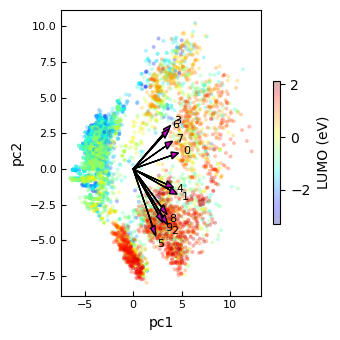

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38', 'pc39', 'pc40', 'pc41', 'pc42', 'pc43', 'pc44', 'pc45', 'pc46', 'pc47', 'pc48', 'pc49', 'pc50', 'pc51', 'pc52', 'pc53', 'pc54', 'pc55', 'pc56', 'pc57', 'pc58', 'pc59', 'pc60', 'pc61', 'pc62', 'pc63', 'pc64', 'pc65', 'pc66', 'pc67', 'pc68', 'pc69', 'pc70', 'pc71']


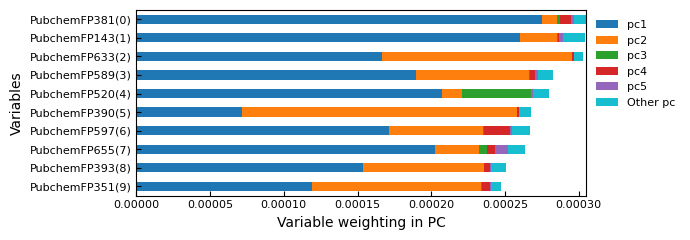

In [35]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_both.columns if 'padelpy_PubchemFP' in c or 'RingCount_' in c ]    
X_features = df_both[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

#colors = [ 0 if d=='PNL' else 1 for d in df_both['source'] ]
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10, data_alpha=0.3, #color_map='cool', cbar_label='Type',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_both_PubchemFP.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_both_PubchemFP_TopFeatures.png')

Before clean (5965, 1391)
After clean (5965, 1062)
Num of keep:  337
Num of drop:  725
---------


LUMO
RingCount_5             0.691621
padelpy_GATS1e          0.712920
padelpy_nBondsD        -0.794308
padelpy_nBondsD2       -0.794308
padelpy_nHdsCH         -0.615558
padelpy_ndsCH          -0.615558
padelpy_naasC           0.656849
padelpy_ndO            -0.646631
padelpy_SHdsCH         -0.639740
padelpy_SdO            -0.647503
padelpy_minHdsCH       -0.618256
padelpy_mindO          -0.642277
padelpy_maxHdsCH       -0.654314
padelpy_maxdsCH        -0.606607
padelpy_maxdO          -0.644571
padelpy_ETA_BetaP_ns_d  0.610445
padelpy_n5Ring          0.691621
padelpy_nT5Ring         0.691621
padelpy_nHeteroRing     0.626269
padelpy_n5HeteroRing    0.692545
padelpy_nT5HeteroRing   0.692545
padelpy_SRW5            0.691621
padelpy_SRW7            0.683802
padelpy_SRW9            0.674497

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8044767115662524  from  38
Exp Var:  [0.13920412 0.09109306 0.07014745 0.05295399 0.03664498 0.03153932
 0.02966899 0.02896265 0.02372995 0.02279877 0.02212415 0.01817841
 0.01777338 0.01476154 0.01382475 0.0131663  0.01191059 0.01151753
 0.01139023 0.01082692 0.01030697 0.00948448 0.00934288 0.00913565
 0.00878125 0.00826479 0.00784108 0.00759243 0.0074506  0.007181
 0.00661504 0.00634019 0.00619283 0.00584643 0.00562958 0.00556801
 0.00540152 0.00528492]


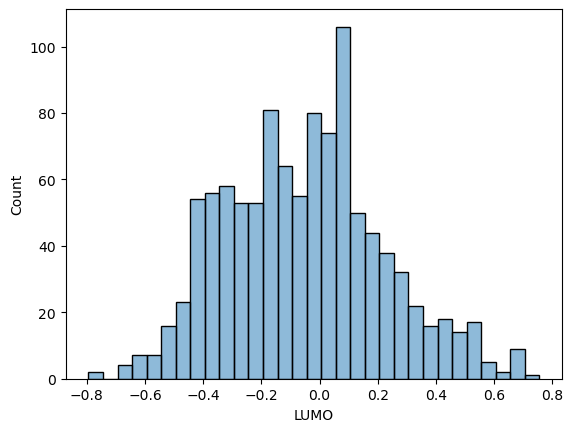

'In plot'

pc1       pc2       pc3       pc4       pc5  \
padelpy_SpMax2_Bhv  0.128223 -0.005824  0.032874  0.024506 -0.025037   
padelpy_ATS7i       0.125792  0.003954 -0.003194 -0.061488 -0.004794   
padelpy_topoRadius  0.123951  0.036529  0.016497 -0.008336 -0.044118   
padelpy_ATS2p       0.105615 -0.059478  0.102557 -0.059080  0.002751   
padelpy_ETA_Eta_L   0.118295 -0.032085  0.001504 -0.073060 -0.047666   
padelpy_ZMIC1       0.115757  0.026884  0.076709 -0.000124  0.042612   
padelpy_AATS6v      0.115302  0.058526 -0.011209  0.032824 -0.012425   
padelpy_SIC0       -0.096365  0.112172  0.024016  0.043524 -0.003232   
padelpy_ATS6s       0.109894  0.069120 -0.031753 -0.054406 -0.001783   
padelpy_SwHBa       0.107665 -0.050901  0.066054  0.068230  0.057607   

                         pc6       pc7       pc8       pc9      pc10  ...  \
padelpy_SpMax2_Bhv -0.028494 -0.025287 -0.014809  0.032677  0.007954  ...   
padelpy_ATS7i      -0.018415 -0.016780 -0.028400 -0.076706  0.026403  ...   
padelpy_topoRadius  0.016030 -0.013346  0.050159 -0.032585  0.033843  ...   
padelpy_ATS2p      -0.029621  0.015976  0.025597  0.029260 -0.015026  ...   
padelpy_ETA_Eta_L  -0.030803  0.024440  0.031453  0.050350 -0.034325  ...   
padelpy_ZMIC1       0.037315  0.030153  0.056522 -0.011302  0.020548  ...   
padelpy_AATS6v     -0.051411 -0.025570 -0.040079 -0.064103  0.020379  ...   
padelpy_SIC0       -0.022672  0.000185 -0.016126 -0.013102  0.014458  ...   
padelpy_ATS6s      -0.005412  0.000679 -0.057328 -0.036629 -0.019658  ...   
padelpy_SwHBa      -0.041001  0.021038 -0.007051 -0.059144  0.009582  ...   

                        pc30      pc31      pc32      pc33      pc34  \
padelpy_SpMax2_Bhv -0.029367 -0.014558  0.006876  0.037665  0.017018   
padelpy_ATS7i      -0.048561  0.022979  0.014118 -0.010933  0.020998   
padelpy_topoRadius  0.028802 -0.037583 -0.018483  0.042577  0.024235   
padelpy_ATS2p       0.012814  0.009846 -0.008966  0.027747 -0.004135   
padelpy_ETA_Eta_L   0.002296  0.034243 -0.015419  0.045684  0.009947   
padelpy_ZMIC1       0.001321  0.011274  0.022887  0.026389  0.009028   
padelpy_AATS6v      0.017771 -0.021001  0.030473  0.016343  0.036798   
padelpy_SIC0        0.004426  0.003050  0.002702 -0.026210  0.000762   
padelpy_ATS6s      -0.000778  0.019121 -0.023548 -0.028914  0.059896   
padelpy_SwHBa       0.017229 -0.009646 -0.002127 -0.013526  0.018175   

                        pc35      pc36      pc37      pc38    length  
padelpy_SpMax2_Bhv  0.013494 -0.043448 -0.001193 -0.047464  0.000332  
padelpy_ATS7i      -0.012894 -0.023753 -0.017441  0.006945  0.000325  
padelpy_topoRadius  0.007987 -0.016303  0.040362  0.027820  0.000319  
padelpy_ATS2p       0.013740 -0.002983 -0.012441  0.025268  0.000310  
padelpy_ETA_Eta_L  -0.018751  0.004833 -0.018630  0.044889  0.000306  
padelpy_ZMIC1       0.023399  0.037150  0.017212  0.006645  0.000305  
padelpy_AATS6v      0.028436 -0.001864 -0.003618  0.012243  0.000300  
padelpy_SIC0       -0.032457 -0.013728 -0.009954 -0.000684  0.000297  
padelpy_ATS6s       0.033312  0.014921 -0.017202  0.024909  0.000294  
padelpy_SwHBa      -0.008379 -0.016245  0.009791 -0.012874  0.000293  

[10 rows x 39 columns]

0 padelpy_SpMax2_Bhv
1 padelpy_ATS7i
2 padelpy_topoRadius
3 padelpy_ATS2p
4 padelpy_ETA_Eta_L
5 padelpy_ZMIC1
6 padelpy_AATS6v
7 padelpy_SIC0
8 padelpy_ATS6s
9 padelpy_SwHBa


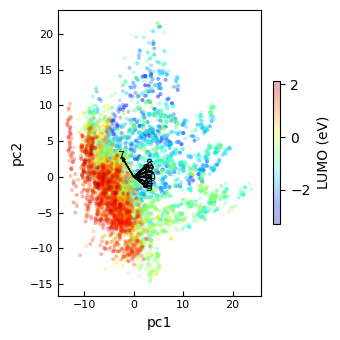

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38']


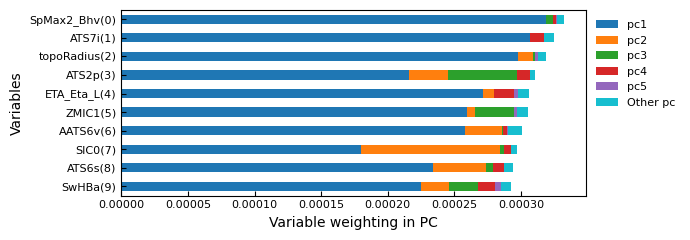

In [36]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_both.columns if 'padelpy_PubchemFP' not in c and ('padelpy_' in c or 'RingCount_' in c) ]  
X_features = df_both[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

#colors = [ 0 if d=='PNL' else 1 for d in df_both['source'] ]
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10, data_alpha=0.3, #color_map='cool', cbar_label='Type',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_both_padelpy.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='padelpy_', save_to_file='Figure_PCA_both_padelpy_TopFeatures.png')

In [37]:
see_correlation(df_both, 'rdk_EState_VSA10', ylabel='LUMO')

## Pattern = With N in diene

In [68]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)

patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = [c for c in patterns_col if c.count('N')>=0 ]
pattern_no = [p for p in patterns_col if p not in pattern_yes]
print( patterns_col,'\n',pattern_yes,'\n',pattern_no )

mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene_pattern = df_diene_pattern.dropna(axis='columns')
#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern = df_diene_pattern[ df_diene_pattern['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)

df_diene_pattern

C:\Users\zhan051\AppData\Local\Temp\ipykernel_14096\2373757323.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)


['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 []


HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
21370 -8.018993 -4.508813   O=Cc1nc(=O)onn1    QM9                  False   
21284 -8.353685 -4.195890   O=c1oncc(n1)C#N    QM9                  False   
21290 -8.155047 -4.168679     O=c1oncnc1C#N    QM9                  False   
21191 -9.463881 -4.149632   O=C(C#N)n1nnnn1    QM9                  False   
21293 -8.353685 -4.021741   O=c1onnc(c1)C#N    QM9                  False   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
21370                  False                  False                  False   
21284                  False                  False                  False   
21290                  False                  False                  False   
21191                  False                  False                  False   
21293                  False                  False                   True   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
14486                  False                  False                  False   
13875                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
21370                  False                  False  ...   
21284                  False                   True  ...   
21290                   True                  False  ...   
21191                  False                  False  ...   
21293                  False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
14486                  False                  False  ...   
13875                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP871  padelpy_PubchemFP872  padelpy_PubchemFP873  \
21370                   0.0                   0.0                   0.0   
21284                   0.0                   0.0                   0.0   
21290                   0.0                   0.0                   0.0   
21191                   0.0                   0.0                   0.0   
21293                   0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP874 padelpy_PubchemFP875  padelpy_PubchemFP876  \
21370                   0.0                  0.0                   0.0   
21284                   0.0                  0.0                   0.0   
21290                   0.0                  0.0                   0.0   
21191                   0.0                  0.0                   0.0   
21293                   0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

In [69]:
## Keep rings >=5
ring = [ c for c in df_diene_pattern.columns if 'RingCount_' in c ]
mask1 = np.all( [df_diene_pattern['RingCount_3']==0, df_diene_pattern['RingCount_4']==0], axis=0 )
mask2 = np.any( [df_diene_pattern[r]==1 for r in ring ], axis=0 )
mask_keep = np.all( [mask1,mask2],axis=0 )
df_diene_pattern = df_diene_pattern[mask_keep]

## Keep common atoms
good_elements = ['C','H','O','N','S']
mask_element = []   ## molecules to keep, keep=True
for smi in df_diene_pattern['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    mask_element.append(all(e in good_elements for e in element))
df_diene_pattern = df_diene_pattern[mask_element]

## Add ring info
#NumRingAtom = np.zeros(len(df_diene_pattern))
NumRingAtom = [ [] for n in range(len(df_diene_pattern)) ]
for r in ring:
    ring_num = int(r.split('_')[-1])
    idx = np.argwhere(df_diene_pattern[r]==1).flatten()
    if len(idx)>0:
        #NumRingAtom[ idx ] = ring_num
        for i in idx:
            NumRingAtom[i].append(ring_num)      
#df_diene_pattern['NumRingAtom'] = NumRingAtom
df_diene_pattern['NumRingAtom'] = [ ''.join([str(j) for j in i]) for i in NumRingAtom]

display( df_diene_pattern )

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
21370 -8.018993 -4.508813   O=Cc1nc(=O)onn1    QM9                  False   
21284 -8.353685 -4.195890   O=c1oncc(n1)C#N    QM9                  False   
21290 -8.155047 -4.168679     O=c1oncnc1C#N    QM9                  False   
21191 -9.463881 -4.149632   O=C(C#N)n1nnnn1    QM9                  False   
21293 -8.353685 -4.021741   O=c1onnc(c1)C#N    QM9                  False   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
21370                  False                  False                  False   
21284                  False                  False                  False   
21290                  False                  False                  False   
21191                  False                  False                  False   
21293                  False                  False                   True   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
14486                  False                  False                  False   
13875                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
21370                  False                  False  ...   
21284                  False                   True  ...   
21290                   True                  False  ...   
21191                  False                  False  ...   
21293                  False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
14486                  False                  False  ...   
13875                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
21370                   0.0                   0.0                   0.0   
21284                   0.0                   0.0                   0.0   
21290                   0.0                   0.0                   0.0   
21191                   0.0                   0.0                   0.0   
21293                   0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876  padelpy_PubchemFP877  \
21370                   0.0                  0.0                   0.0   
21284                   0.0                  0.0                   0.0   
21290                   0.0                  0.0                   0.0   
21191                   0.0                  0.0                   0.0   
21293                   0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

In [82]:
df_diene_pattern = df_diene_pattern[ [len(d)==1 for d in df_diene_pattern['NumRingAtom']] ]
df_diene_pattern

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
21370 -8.018993 -4.508813   O=Cc1nc(=O)onn1    QM9                  False   
21284 -8.353685 -4.195890   O=c1oncc(n1)C#N    QM9                  False   
21290 -8.155047 -4.168679     O=c1oncnc1C#N    QM9                  False   
21191 -9.463881 -4.149632   O=C(C#N)n1nnnn1    QM9                  False   
21293 -8.353685 -4.021741   O=c1onnc(c1)C#N    QM9                  False   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
21370                  False                  False                  False   
21284                  False                  False                  False   
21290                  False                  False                  False   
21191                  False                  False                  False   
21293                  False                  False                   True   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
14486                  False                  False                  False   
13875                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
21370                  False                  False  ...   
21284                  False                   True  ...   
21290                   True                  False  ...   
21191                  False                  False  ...   
21293                  False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
14486                  False                  False  ...   
13875                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
21370                   0.0                   0.0                   0.0   
21284                   0.0                   0.0                   0.0   
21290                   0.0                   0.0                   0.0   
21191                   0.0                   0.0                   0.0   
21293                   0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876  padelpy_PubchemFP877  \
21370                   0.0                  0.0                   0.0   
21284                   0.0                  0.0                   0.0   
21290                   0.0                  0.0                   0.0   
21191                   0.0                  0.0                   0.0   
21293                   0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

In [81]:
Chem.MolFromSmiles( 'o1ncnc2-c1ncn2' )

In [87]:
df_diene_pattern['NumRingAtom'].value_counts()

NumRingAtom
5    9832
6    2569
7     418
8      47
9      26
Name: count, dtype: int64

In [83]:
df_diene_pattern['diene_types'] = -1

patterns_col = [ c for c in df_diene_pattern.columns if 'SMILES_pattern_' in c ]
groups = [ [c for c in patterns_col if c.count('N')==n] for n in [0,1,2,3,4] ]

for i, pattern_yes in enumerate(groups):
    pattern_no = [p for p in patterns_col if p not in pattern_yes] 
    mask = np.any( df_diene_pattern[pattern_yes]==True, axis=1)
    #mask2 = np.all( df_diene_pattern[pattern_no]==False, axis=1)
    #mask = np.all([mask1,mask2], axis=0)
    ##mask = np.any([ list(df_diene_pattern[p]==True) for p in g], axis=0)
    df_diene_pattern.loc[ mask, ['diene_types'] ]= i

df_diene_pattern['diene_types'].value_counts()


diene_types
1    6120
0    3268
2    3080
3     357
4      67
Name: count, dtype: int64

In [ ]:
df = df_diene_pattern[df_diene_pattern['diene_types']==-1]
Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=5, legends=[str(p) for p in df['LUMO']] )  


In [85]:
df_diene_pattern.to_csv('df_final_qm9_n_diene.csv')

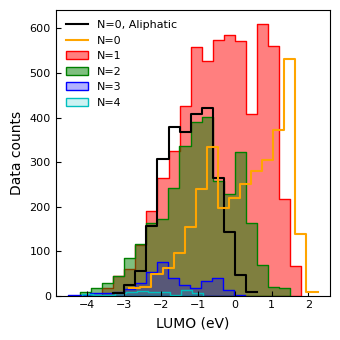

In [103]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
df_n_diene = pd.read_csv('df_final_qm9_n_diene.csv', index_col=0)

colors = ['orange','r','g','b','c']
alphas = [1, 0.5, 0.5, 0.3, 0.2]
fig, axs = plt.subplots( 1,1, figsize=(3.5,3.5), tight_layout=True, )#dpi=100)
sns.histplot( df_pnl, x='LUMO', kde=False, binwidth=0.3, ax=axs, element="step", alpha=1, fill=False, color='k', label=f'N=0, Aliphatic')#, stat='percent')#, multiple="stack", 
for i,n in enumerate([0,1,2,3,4]):
    df = df_n_diene[df_n_diene['diene_types']==n]
    if n==0:
        sns.histplot( df, x='LUMO', kde=False, binwidth=0.3, ax=axs, element="step", alpha=alphas[i], fill=False, color=colors[i], label=f'N={n}')#, stat='percent')#, multiple="stack", 
    else:
        sns.histplot( df, x='LUMO', kde=False, binwidth=0.3, ax=axs, element="step", alpha=alphas[i], fill=True, color=colors[i], label=f'N={n}')#, stat='percent')#, multiple="stack", 

axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
#axs.set_xlim((-4,2.5))
#handles, labels = axs.get_legend_handles_labels()
#labels = ['Ring>=7','Ring 6','Ring 5','No ring']
#axs.legend([handles[-1]]+handles[:-1], [labels[-1]]+labels[:-1], fontsize=8, frameon=False, loc=2)#, ncol=1, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.set_ylabel('Data counts', fontsize=10)

plt.savefig("QM9_Ndiene_Hist.png", dpi=800) 

plt.show()

In [105]:
x,y,z = df_n_diene['diene_types'], df_n_diene['LUMO'], df_n_diene['NumRingAtom']
z = np.array([ i if i<=6 else 7 if i<12 else -1 for i in z ])  ## ring=5,6 or >=7, -1 means overlap
x = np.array([ i+(j-6)*0.1 for i,j in zip(x,z) ])  ## differentiate 5,6,7 by x location
y = np.array(y)

colors = ['magenta','limegreen','darkorange'] #,'c','m']  ## correspond to 5,6,7
colors = np.array( [ colors[int(i-5)] if i>0 else 'k' for i in z] )
mk = ['<','p','*']

fig, axs = plt.subplots(1,1, figsize=(3.5,3.5), tight_layout=True)
for i in [5,6,7]:
    if i in [5,6]:
        idx = np.argwhere( z==i ).flatten()
        idx = [ i for i in idx if x[i]>-0.5 ]
        axs.scatter(x[idx], y[idx], marker=mk[i-5], c=colors[idx], cmap='jet', alpha=0.9, s=10, label=f'Ring = {i}') 
    else:
        idx = np.argwhere( z>=i ).flatten()
        idx = [ i for i in idx if x[i]>-0.5 ]
        axs.scatter(x[idx], y[idx], marker=mk[i-5], c=colors[idx], cmap='jet', alpha=0.9, s=10, label=r'Ring$\geq$7') 

axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.set_xlabel('Numbers of N atoms in diene pattern', fontsize=10)
#axs.set_xticks( [0,1] )
axs.legend(fontsize=8, frameon=False, loc=1) #handles[::-1], labels[::-1], fontsize=8, frameon=False, ncol=3, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)

plt.savefig("QM9_Ndiene_diagram.png", dpi=800) 

plt.show()

In [129]:
top = df_n_diene.sort_values(by='LUMO',ascending=True).head(6)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=6, subImgSize=(400, 300), returnPNG=False, legends=[str(round(p,2))+' eV' for p in top['LUMO']], )  
img.save('Ncontaining_lowest_LUMO.png')
display(img)

0

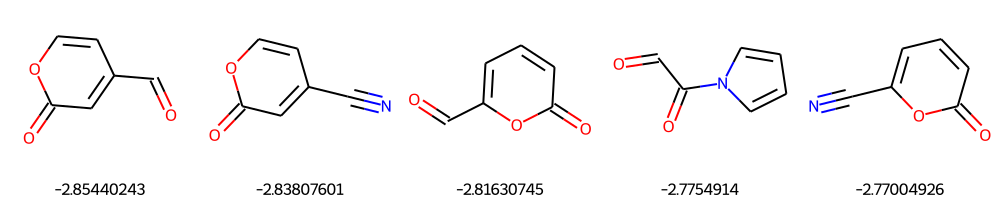

1

2

3

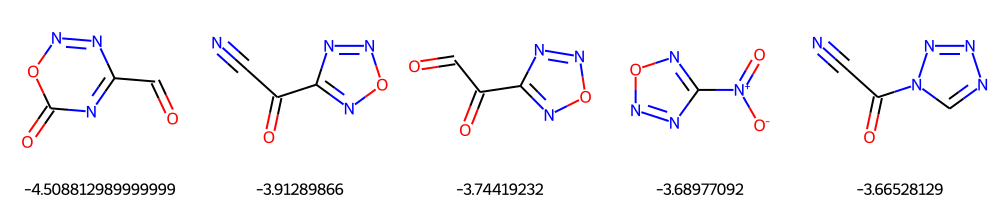

4

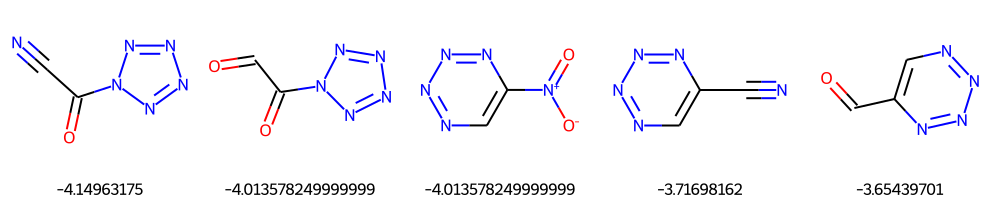

In [357]:
## Draw based on Num N
for n in [0,1,2,3,4]:
    df = df_n_diene[ df_n_diene['diene_types']==n ].sort_values(by='LUMO',ascending=True).head(5)
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=5, legends=[str(p) for p in df['LUMO']] )  
    display(n, img)

In [323]:
zines = [
    'C1=CN=NN=C1', # 1,2,3-triazine
    'C1=CN=NC=N1', # 1,2,4-Triazine
    'C1=NC=NC=N1', # 1,3,5-Triazine
    'C1=CN=NN=N1', #1,2,3,4-Tetrazine
    'C1=NN=CN=N1', #1,2,4,5-Tetrazine
]

df_n_diene[ [has_substructure(smi, sub_struct=zines) for smi in df_n_diene['SMILES']] ]


Empty DataFrame
Columns: [HOMO, LUMO, SMILES, source, SMILES_pattern_C=CC=C, SMILES_pattern_N=CC=C, SMILES_pattern_C=NC=C, SMILES_pattern_N=NC=C, SMILES_pattern_N=CN=C, SMILES_pattern_N=CC=N, SMILES_pattern_C=NN=C, SMILES_pattern_N=NN=C, SMILES_pattern_N=NC=N, SMILES_pattern_N=NN=N, Inchi, rdk_MaxEStateIndex, rdk_MinEStateIndex, rdk_MaxAbsEStateIndex, rdk_MinAbsEStateIndex, rdk_qed, rdk_MolWt, rdk_HeavyAtomMolWt, rdk_ExactMolWt, rdk_NumValenceElectrons, rdk_NumRadicalElectrons, rdk_MaxPartialCharge, rdk_MinPartialCharge, rdk_MaxAbsPartialCharge, rdk_MinAbsPartialCharge, rdk_FpDensityMorgan1, rdk_FpDensityMorgan2, rdk_FpDensityMorgan3, rdk_BCUT2D_MWHI, rdk_BCUT2D_MWLOW, rdk_BCUT2D_CHGHI, rdk_BCUT2D_CHGLO, rdk_BCUT2D_LOGPHI, rdk_BCUT2D_LOGPLOW, rdk_BCUT2D_MRHI, rdk_BCUT2D_MRLOW, rdk_BalabanJ, rdk_BertzCT, rdk_Chi0, rdk_Chi0n, rdk_Chi0v, rdk_Chi1, rdk_Chi1n, rdk_Chi1v, rdk_Chi2n, rdk_Chi2v, rdk_Chi3n, rdk_Chi3v, rdk_Chi4n, rdk_Chi4v, rdk_HallKierAlpha, rdk_Kappa1, rdk_Kappa2, rdk_Kappa3, rdk_LabuteASA, rdk_PEOE_VSA1, rdk_PEOE_VSA10, rdk_PEOE_VSA11, rdk_PEOE_VSA12, rdk_PEOE_VSA13, rdk_PEOE_VSA14, rdk_PEOE_VSA2, rdk_PEOE_VSA3, rdk_PEOE_VSA4, rdk_PEOE_VSA5, rdk_PEOE_VSA6, rdk_PEOE_VSA7, rdk_PEOE_VSA8, rdk_PEOE_VSA9, rdk_SMR_VSA1, rdk_SMR_VSA10, rdk_SMR_VSA2, rdk_SMR_VSA3, rdk_SMR_VSA4, rdk_SMR_VSA5, rdk_SMR_VSA6, rdk_SMR_VSA7, rdk_SMR_VSA8, rdk_SMR_VSA9, rdk_SlogP_VSA1, rdk_SlogP_VSA10, rdk_SlogP_VSA11, rdk_SlogP_VSA12, rdk_SlogP_VSA2, rdk_SlogP_VSA3, rdk_SlogP_VSA4, rdk_SlogP_VSA5, rdk_SlogP_VSA6, rdk_SlogP_VSA7, rdk_SlogP_VSA8, rdk_SlogP_VSA9, rdk_TPSA, rdk_EState_VSA1, rdk_EState_VSA10, rdk_EState_VSA11, rdk_EState_VSA2, ...]
Index: []

[0 rows x 2386 columns]

Before clean (9624, 123)
After clean (9624, 114)
Num of keep:  84
Num of drop:  30
---------


Empty DataFrame
Columns: [LUMO]
Index: []

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Total Var  0.8024269973460318  from  20
Exp Var:  [0.15467095 0.09247425 0.06698798 0.05973066 0.05419636 0.04765553
 0.04466705 0.03738315 0.03413556 0.03044031 0.02506189 0.02466045
 0.02112181 0.01837744 0.0165458  0.01646606 0.01513867 0.01493799
 0.01410533 0.01366978]


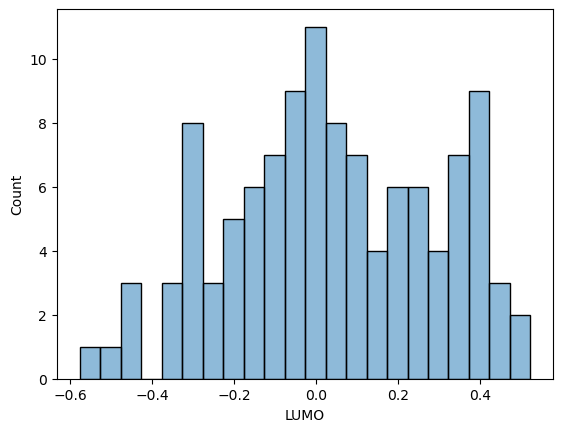

'In plot'

pc1       pc2       pc3       pc4       pc5  \
rdk_TPSA                -0.239931 -0.040674  0.092164  0.025152  0.009474   
rdk_MolLogP              0.210859 -0.047456 -0.053548 -0.155841  0.057800   
rdk_MinEStateIndex       0.200753  0.004595  0.145927  0.099795 -0.012347   
rdk_FractionCSP3         0.165899 -0.220963 -0.013834  0.083702  0.021520   
rdk_HallKierAlpha        0.178385 -0.158229 -0.049310  0.017199 -0.058246   
rdk_Chi2n                0.167498 -0.181014  0.007064 -0.188756 -0.033337   
rdk_NumHAcceptors       -0.199625 -0.064797  0.003420  0.128029 -0.017833   
rdk_VSA_EState8          0.187480 -0.086318  0.009072 -0.099151  0.028686   
rdk_MinAbsPartialCharge -0.192980  0.008811 -0.074306 -0.007317 -0.032433   
rdk_MinAbsEStateIndex    0.190610  0.041373  0.095037  0.084772 -0.098131   

                              pc6       pc7       pc8       pc9      pc10  \
rdk_TPSA                 0.131558 -0.008863 -0.051860 -0.016301 -0.153279   
rdk_MolLogP             -0.161950  0.004811  0.052884 -0.099215 -0.001708   
rdk_MinEStateIndex      -0.124489 -0.049695  0.132782  0.014673 -0.001659   
rdk_FractionCSP3         0.066973  0.126543 -0.087869  0.006895  0.026549   
rdk_HallKierAlpha       -0.043724  0.248740  0.048044  0.038198 -0.057167   
rdk_Chi2n                0.140517 -0.009099 -0.097737 -0.001040  0.015905   
rdk_NumHAcceptors        0.049601  0.044986 -0.107455 -0.040490  0.026872   
rdk_VSA_EState8          0.099086  0.141684 -0.068798 -0.203962 -0.003932   
rdk_MinAbsPartialCharge -0.087060  0.037775 -0.145372 -0.183611  0.179421   
rdk_MinAbsEStateIndex   -0.054551  0.010744  0.061176 -0.075398  0.087318   

                         ...      pc12      pc13      pc14      pc15  \
rdk_TPSA                 ...  0.087376  0.030735  0.007230  0.012052   
rdk_MolLogP              ... -0.087890  0.101614 -0.071345  0.064923   
rdk_MinEStateIndex       ... -0.086889  0.049908  0.049032 -0.059005   
rdk_FractionCSP3         ...  0.066393 -0.122587  0.066450 -0.002854   
rdk_HallKierAlpha        ...  0.093665 -0.051828  0.029541 -0.042791   
rdk_Chi2n                ... -0.028677 -0.052022  0.012305 -0.015418   
rdk_NumHAcceptors        ...  0.077637 -0.088997  0.181041  0.043539   
rdk_VSA_EState8          ... -0.058039  0.021277  0.008522 -0.039181   
rdk_MinAbsPartialCharge  ... -0.040513 -0.025864 -0.074328 -0.051958   
rdk_MinAbsEStateIndex    ...  0.039861  0.021736 -0.141551  0.060389   

                             pc16      pc17      pc18      pc19      pc20  \
rdk_TPSA                 0.026403  0.033869  0.020922  0.016770  0.014012   
rdk_MolLogP             -0.028239 -0.067216  0.001088 -0.037777 -0.011404   
rdk_MinEStateIndex       0.011471 -0.113624  0.070324  0.153999 -0.000594   
rdk_FractionCSP3        -0.012895 -0.010092 -0.086982 -0.031564 -0.019488   
rdk_HallKierAlpha       -0.005896  0.027089 -0.087769 -0.067322  0.006725   
rdk_Chi2n                0.025344 -0.052305 -0.051277 -0.048026 -0.038264   
rdk_NumHAcceptors        0.043052 -0.054605  0.087563  0.122853 -0.037432   
rdk_VSA_EState8         -0.110715 -0.032491 -0.157510 -0.002835 -0.018075   
rdk_MinAbsPartialCharge -0.067698  0.051787 -0.050288  0.009186 -0.038423   
rdk_MinAbsEStateIndex    0.022376 -0.039670  0.100619  0.090796  0.119809   

                           length  
rdk_TPSA                 0.001505  
rdk_MolLogP              0.001284  
rdk_MinEStateIndex       0.001181  
rdk_FractionCSP3         0.001173  
rdk_HallKierAlpha        0.001147  
rdk_Chi2n                0.001146  
rdk_NumHAcceptors        0.001117  
rdk_VSA_EState8          0.001075  
rdk_MinAbsPartialCharge  0.001052  
rdk_MinAbsEStateIndex    0.001024  

[10 rows x 21 columns]

0 rdk_TPSA
1 rdk_MolLogP
2 rdk_MinEStateIndex
3 rdk_FractionCSP3
4 rdk_HallKierAlpha
5 rdk_Chi2n
6 rdk_NumHAcceptors
7 rdk_VSA_EState8
8 rdk_MinAbsPartialCharge
9 rdk_MinAbsEStateIndex


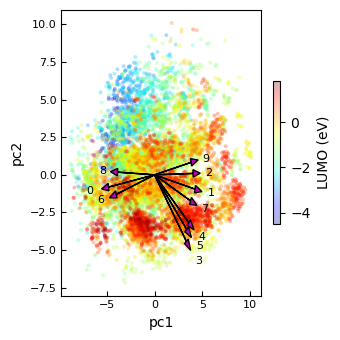

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20']


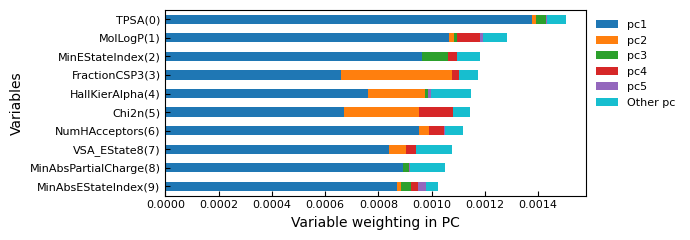

In [124]:
df = df_n_diene[df_n_diene['diene_types']>=1]

## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df.columns if 'rdk_' in c ]#or 'diene_types' in c or 'NumRingAtom' in c ]    
X_features = df[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
mask = highlight.drop('LUMO',axis=0).abs()>0.6
display( highlight.drop('LUMO')[ mask.values ] )
display( sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) ) #color='r', stat='percent',label='LUMO', element="step", 

Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=0.5)

#colors = [ 0 if d=='PNL' else 1 for d in df['source'] ]
colors = X_features_prop_clean['LUMO']
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=8, explained_var=exp_var, num_feature=10, data_alpha=0.3, color_map='jet', cbar_label='LUMO (eV)',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_AllN_rdk.png')
feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='rdk_', save_to_file='Figure_PCA_AllN_rdk_TopFeatures.png')

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20']


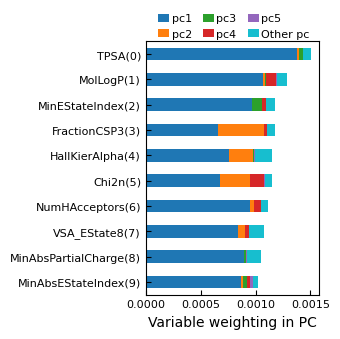

In [125]:
def copy_feature_weight( pca_coef, explained_var, num_variable=10, if_var_considered=False, header=None, save_to_file=None, fig_size=None):
    pc_names = list(pca_coef.drop('length',axis=1).columns)
    print(pc_names)
    
    if if_var_considered:
        weight = (pca_coef[pc_names]*explained_var)**2
        weight['length'] = weight.sum(axis=1)
    weight = weight.sort_values('length',ascending=False)
    weight = weight.head(num_variable)
    if header is not None:
        weight.index = [i.replace(header,'')+f'({n})' for n,i in enumerate(weight.index)]
    #display(weight)
    n_pc_show = 5
    colors = ['tab:cyan' for p in pc_names]
    colors = list(mcolors.TABLEAU_COLORS.keys())[:n_pc_show] + colors[n_pc_show:]
    
    if fig_size is None: fig_size = (7,0.25*num_variable)
    fig, axs = plt.subplots(1,1, figsize=fig_size,tight_layout=True)
    weight.plot(kind='barh', y=pc_names, ax=axs, stacked=True, color=colors)#, colormap='tab10')
    axs.set_xlabel('Variable weighting in PC',fontsize=10) ## input X name
    #axs.set_ylabel('Variables',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
    axs.invert_yaxis()
    
    handles, labels = axs.get_legend_handles_labels()
    handles,labels = handles[:n_pc_show+1],labels[:n_pc_show+1]
    labels[-1] = 'Other pc'
    axs.legend( handles,labels, fontsize=8, frameon=False, ncol=3, bbox_to_anchor=(1, 1.15), handlelength=1, handletextpad=0.2, columnspacing=1 )
    #axs.get_legend().remove()
    #plt.yticks(rotation=45)

    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=800)    
    plt.show()
copy_feature_weight( df2_pca_coef, exp_var, num_variable=10, if_var_considered=True, header='rdk_', save_to_file='Figure_PCA_AllN_rdk_TopFeatures.png', fig_size=(3.5, 3.5))

## Pattern = 1 N in diene

In [56]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)

patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = [c for c in patterns_col if c.count('N')==1 ]
pattern_no = [p for p in patterns_col if p not in pattern_yes]
print( patterns_col,'\n',pattern_yes,'\n',pattern_no )

mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene_pattern = df_diene_pattern.dropna(axis='columns')
#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern

C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\4252653105.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)


['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C'] 
 ['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N']


C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\4252653105.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)


HOMO      LUMO              SMILES source  SMILES_pattern_C=CC=C  \
4564  -6.130571  0.903395          [nH]1ccnc1    QM9                  False   
4566  -6.827165  0.027211             o1ccnc1    QM9                  False   
4567  -6.633969  0.650336          [nH]1cccn1    QM9                  False   
4571  -7.284304 -0.375508             o1cccn1    QM9                  False   
4581  -6.432609  0.179591            Cc1cnco1    QM9                  False   
...         ...       ...                 ...    ...                    ...   
23132 -7.918314 -1.202713     FC(F)(F)c1ccno1    QM9                  False   
23134 -7.344168  0.008163  FC(F)(F)c1c[nH]nc1    QM9                  False   
23136 -7.959130 -0.995912     FC(F)(F)c1conc1    QM9                  False   
23139 -7.251652 -0.106122  FC(F)(F)c1n[nH]cc1    QM9                  False   
23142 -7.869334 -1.036728     FC(F)(F)c1nocc1    QM9                  False   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
4564                   False                   True                  False   
4566                   False                   True                  False   
4567                    True                  False                  False   
4571                    True                  False                  False   
4581                   False                   True                  False   
...                      ...                    ...                    ...   
23132                   True                  False                  False   
23134                   True                  False                  False   
23136                   True                  False                  False   
23139                   True                  False                  False   
23142                   True                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
4564                   False                  False  ...   
4566                   False                  False  ...   
4567                   False                  False  ...   
4571                   False                  False  ...   
4581                   False                  False  ...   
...                      ...                    ...  ...   
23132                  False                  False  ...   
23134                  False                  False  ...   
23136                  False                  False  ...   
23139                  False                  False  ...   
23142                  False                  False  ...   

       padelpy_PubchemFP871  padelpy_PubchemFP872  padelpy_PubchemFP873  \
4564                    0.0                   0.0                   0.0   
4566                    0.0                   0.0                   0.0   
4567                    0.0                   0.0                   0.0   
4571                    0.0                   0.0                   0.0   
4581                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
23132                   0.0                   0.0                   0.0   
23134                   0.0                   0.0                   0.0   
23136                   0.0                   0.0                   0.0   
23139                   0.0                   0.0                   0.0   
23142                   0.0                   0.0                   0.0   

       padelpy_PubchemFP874 padelpy_PubchemFP875 padelpy_PubchemFP876  \
4564                    0.0                  0.0                  0.0   
4566                    0.0                  0.0                  0.0   
4567                    0.0                  0.0                  0.0   
4571                    0.0                  0.0                  0.0   
4581                    0.0                  0.0                  0.0   
...                     ...                  ...                 

In [66]:
df_diene_pattern['diene_types'] = -1

for i,p in enumerate(pattern_yes):
    mask = list(df_diene_pattern[p]==True)
    #df_diene_pattern[mask,['diene_types']] = i
    df_diene_pattern.loc[ mask, ['diene_types'] ]=i
    
df_diene_pattern['diene_types']

4564     1
4566     1
4567     0
4571     0
4581     1
        ..
23132    0
23134    0
23136    0
23139    0
23142    0
Name: diene_types, Length: 7712, dtype: int64

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

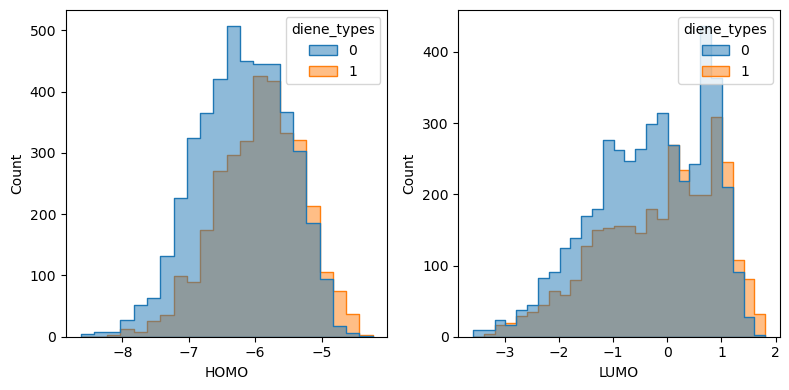

In [67]:
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)

sns.histplot(df_diene_pattern, x='HOMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_diene_pattern, x='LUMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO',  
#axs[0].legend(loc=2)
#axs[1].legend(loc=2)

Before clean (7712, 132)
After clean (7712, 122)
Num of keep:  93
Num of drop:  29
---------


LUMO
rdk_EState_VSA10 -0.653992

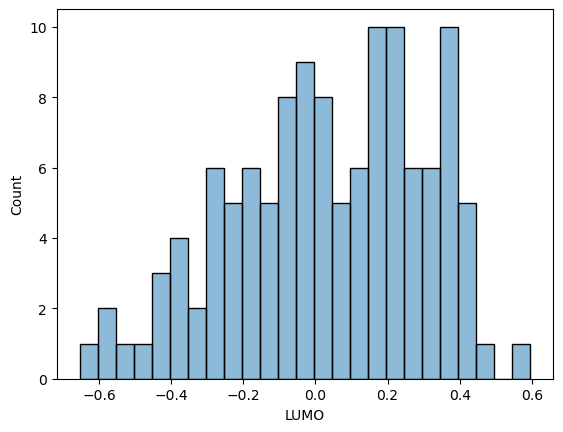

In [70]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'RingCount_' in c]    
X_features = df_diene_pattern[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
X_features_prop_clean

sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO', element="step",

mask = highlight.drop('LUMO',axis=0).abs()>0.6
highlight.drop('LUMO')[ mask.values ]

Total Var  0.2359836413293756  from  2
Exp Var:  [0.1556846  0.08029904]
                               pc1           pc2         Total
RingCount_8           6.426271e-09  3.631531e-07  3.695793e-07
RingCount_9           1.144489e-07  2.002489e-06  2.116938e-06
rdk_SlogP_VSA8        2.146522e-07  2.162278e-06  2.376930e-06
rdk_SMR_VSA4          4.871217e-06  2.568226e-06  7.439443e-06
rdk_PEOE_VSA10        7.948589e-06  6.651546e-06  1.460013e-05
...                            ...           ...           ...
rdk_MaxPartialCharge  9.307680e-04  1.827112e-06  9.325951e-04
rdk_NumHAcceptors     8.018786e-04  1.354452e-04  9.373238e-04
rdk_Chi3n             9.805210e-04  9.148267e-05  1.072004e-03
rdk_FractionCSP3      9.832239e-04  1.001205e-04  1.083344e-03
rdk_NumHeteroatoms    1.179993e-03  1.009143e-04  1.280908e-03

[92 rows x 3 columns]


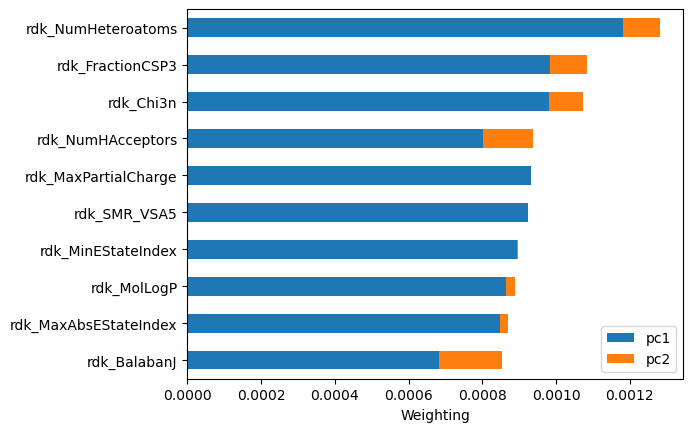

'In plot'

pc1       pc2    length
rdk_NumHeteroatoms    -0.220645 -0.125103  0.001281
rdk_FractionCSP3       0.201410 -0.124609  0.001083
rdk_Chi3n              0.201133 -0.119113  0.001072
rdk_NumHAcceptors     -0.181890 -0.144934  0.000937
rdk_MaxPartialCharge  -0.195963  0.016833  0.000933
rdk_SMR_VSA5           0.195313 -0.004886  0.000925
rdk_MinEStateIndex     0.192051 -0.021156  0.000897
rdk_MolLogP            0.188766  0.062852  0.000889
rdk_MaxAbsEStateIndex -0.186955  0.057354  0.000868
rdk_BalabanJ          -0.167839  0.163038  0.000854

0 rdk_NumHeteroatoms
1 rdk_FractionCSP3
2 rdk_Chi3n
3 rdk_NumHAcceptors
4 rdk_MaxPartialCharge
5 rdk_SMR_VSA5
6 rdk_MinEStateIndex
7 rdk_MolLogP
8 rdk_MaxAbsEStateIndex
9 rdk_BalabanJ


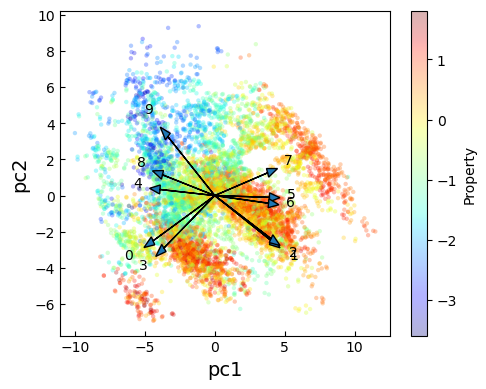

In [71]:
Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =2
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=10)

#colors = X_prop['RingCount_5'] 
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', feature_arrow=True, num_feature=10, size=10, explained_var=exp_var )# yrange=[-5,10] )


## Pattern = 2 N in diene

In [72]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)

patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = [c for c in patterns_col if c.count('N')==2 ]
pattern_no = [p for p in patterns_col if p not in pattern_yes]
print( patterns_col,'\n',pattern_yes,'\n',pattern_no )

mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene_pattern = df_diene_pattern.dropna(axis='columns')
#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern['diene_types'] = -1
for i,p in enumerate(pattern_yes):
    mask = list(df_diene_pattern[p]==True)
    df_diene_pattern.loc[ mask, ['diene_types'] ]=i

df_diene_pattern

C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\2562239946.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)


['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C'] 
 ['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N']


C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\2562239946.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)


HOMO      LUMO              SMILES source  SMILES_pattern_C=CC=C  \
4568  -7.186346 -0.062585          [nH]1ccnn1    QM9                  False   
4569  -6.941450  0.446255          [nH]1cnnc1    QM9                  False   
4570  -7.461174 -0.149659          [nH]1nccn1    QM9                  False   
4572  -7.787702 -1.197271             o1ccnn1    QM9                  False   
4573  -8.310148 -0.911558             o1cncn1    QM9                  False   
...         ...       ...                 ...    ...                    ...   
23138 -8.821709 -1.676179     FC(F)(F)c1ncno1    QM9                  False   
23140 -7.989062 -0.465303  FC(F)(F)c1n[nH]cn1    QM9                  False   
23141 -8.114231 -0.859858  FC(F)(F)c1n[nH]nc1    QM9                  False   
23143 -8.889736 -1.504752     FC(F)(F)c1nocn1    QM9                  False   
23144 -9.281570 -2.005429     FC(F)(F)c1nonc1    QM9                  False   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
4568                   False                  False                   True   
4569                   False                  False                  False   
4570                   False                  False                  False   
4572                   False                  False                   True   
4573                   False                  False                  False   
...                      ...                    ...                    ...   
23138                  False                  False                  False   
23140                  False                  False                  False   
23141                  False                  False                  False   
23143                  False                  False                  False   
23144                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
4568                   False                  False  ...   
4569                   False                  False  ...   
4570                   False                   True  ...   
4572                   False                  False  ...   
4573                    True                  False  ...   
...                      ...                    ...  ...   
23138                   True                  False  ...   
23140                   True                  False  ...   
23141                  False                   True  ...   
23143                   True                  False  ...   
23144                  False                   True  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
4568                    0.0                   0.0                   0.0   
4569                    0.0                   0.0                   0.0   
4570                    0.0                   0.0                   0.0   
4572                    0.0                   0.0                   0.0   
4573                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
23138                   0.0                   0.0                   0.0   
23140                   0.0                   0.0                   0.0   
23141                   0.0                   0.0                   0.0   
23143                   0.0                   0.0                   0.0   
23144                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876 padelpy_PubchemFP877  \
4568                    0.0                  0.0                  0.0   
4569                    0.0                  0.0                  0.0   
4570                    0.0                  0.0                  0.0   
4572                    0.0                  0.0                  0.0   
4573                    0.0                  0.0                  0.0   
...                     ...                  ...                 

In [79]:
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)
sns.histplot(df_diene_pattern, x='HOMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.3, fill=True, palette=['r','g','b','y']) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_diene_pattern, x='LUMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.3, fill=True, palette=['r','g','b','y']) #color='r', stat='percent',label='LUMO',  

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

Before clean (3291, 132)
After clean (3291, 120)
Num of keep:  87
Num of drop:  33
---------


LUMO
rdk_EState_VSA10 -0.626937

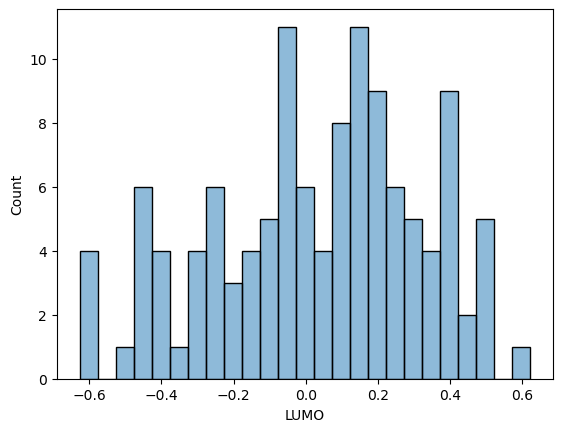

In [74]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'RingCount_' in c]    
X_features = df_diene_pattern[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
X_features_prop_clean

sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO', element="step",

mask = highlight.drop('LUMO',axis=0).abs()>0.6
highlight.drop('LUMO')[ mask.values ]

In [75]:
Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =2
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=10)

#colors = X_prop['RingCount_5'] 
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', feature_arrow=True, num_feature=10, size=10, explained_var=exp_var )# yrange=[-5,10] )


Total Var  0.24514481312545705  from  2
Exp Var:  [0.16373914 0.08140567]
                                  pc1           pc2     Total
rdk_SlogP_VSA8           7.667587e-07  7.711624e-06  0.000008
rdk_PEOE_VSA10           1.617680e-05  1.976527e-07  0.000016
rdk_SMR_VSA4             8.412824e-06  8.327026e-06  0.000017
rdk_PEOE_VSA5            1.658135e-05  6.509772e-06  0.000023
rdk_VSA_EState9          7.420761e-07  2.447410e-05  0.000025
...                               ...           ...       ...
rdk_MinAbsPartialCharge  1.073704e-03  9.938186e-09  0.001074
rdk_SMR_VSA5             1.078372e-03  3.005009e-09  0.001078
rdk_Chi2n                1.112495e-03  8.637312e-05  0.001199
rdk_FractionCSP3         1.106630e-03  1.252246e-04  0.001232
rdk_TPSA                 1.229867e-03  9.817205e-05  0.001328

[86 rows x 3 columns]


'In plot'

pc1       pc2    length
rdk_TPSA                 0.214179 -0.121714  0.001328
rdk_FractionCSP3        -0.203165 -0.137464  0.001232
rdk_Chi2n               -0.203703 -0.114165  0.001199
rdk_SMR_VSA5            -0.200554  0.000673  0.001078
rdk_MinAbsPartialCharge  0.200120 -0.001225  0.001074
rdk_NumHAcceptors        0.186104 -0.112588  0.001013
rdk_MolLogP             -0.188293  0.071413  0.000984
rdk_MaxAbsEStateIndex    0.188294  0.045742  0.000964
rdk_BalabanJ             0.167454  0.170421  0.000944
rdk_MinEStateIndex      -0.186050 -0.026575  0.000933

0 rdk_TPSA
1 rdk_FractionCSP3
2 rdk_Chi2n
3 rdk_SMR_VSA5
4 rdk_MinAbsPartialCharge
5 rdk_NumHAcceptors
6 rdk_MolLogP
7 rdk_MaxAbsEStateIndex
8 rdk_BalabanJ
9 rdk_MinEStateIndex


## pattern = 3 N in diene

In [81]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)

patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = [c for c in patterns_col if c.count('N')==3 ]
pattern_no = [p for p in patterns_col if p not in pattern_yes]
print( patterns_col,'\n',pattern_yes,'\n',pattern_no )

mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene_pattern = df_diene_pattern.dropna(axis='columns')
#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern['diene_types'] = -1
for i,p in enumerate(pattern_yes):
    mask = list(df_diene_pattern[p]==True)
    df_diene_pattern.loc[ mask, ['diene_types'] ]=i

df_diene_pattern

C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\1659063016.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)


['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N'] 
 ['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=N']


C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\1659063016.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)


HOMO      LUMO           SMILES source  SMILES_pattern_C=CC=C  \
4575  -9.006742 -1.749648          o1cnnn1    QM9                  False   
4577  -9.194496 -2.217672          o1ncnn1    QM9                  False   
4621  -7.842124 -0.658499      Cc1n[nH]nn1    QM9                  False   
4625  -8.701982 -1.899307         Cc1nonn1    QM9                  False   
4629  -7.692465 -0.405439         Cn1cnnn1    QM9                  False   
...         ...       ...              ...    ...                    ...   
22080 -7.692465 -0.435371      OCCCn1cnnn1    QM9                  False   
22082 -7.624438 -0.606799      OCCCn1ncnn1    QM9                  False   
22102 -5.967307 -0.361902   OCCNc1n[nH]nn1    QM9                  False   
22106 -6.666621 -1.447609      OCCNc1nonn1    QM9                  False   
23145 -9.678846 -2.737396  FC(F)(F)c1nonn1    QM9                  False   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
4575                   False                  False                  False   
4577                   False                  False                  False   
4621                   False                  False                  False   
4625                   False                  False                  False   
4629                   False                  False                  False   
...                      ...                    ...                    ...   
22080                  False                  False                  False   
22082                  False                  False                  False   
22102                  False                  False                  False   
22106                  False                  False                  False   
23145                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
4575                   False                  False  ...   
4577                   False                  False  ...   
4621                   False                  False  ...   
4625                   False                  False  ...   
4629                   False                  False  ...   
...                      ...                    ...  ...   
22080                  False                  False  ...   
22082                  False                  False  ...   
22102                  False                  False  ...   
22106                  False                  False  ...   
23145                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
4575                    0.0                   0.0                   0.0   
4577                    0.0                   0.0                   0.0   
4621                    0.0                   0.0                   0.0   
4625                    0.0                   0.0                   0.0   
4629                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
22080                   0.0                   0.0                   0.0   
22082                   0.0                   0.0                   0.0   
22102                   0.0                   0.0                   0.0   
22106                   0.0                   0.0                   0.0   
23145                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876 padelpy_PubchemFP877  \
4575                    0.0                  0.0                  0.0   
4577                    0.0                  0.0                  0.0   
4621                    0.0                  0.0                  0.0   
4625                    0.0                  0.0                  0.0   
4629                    0.0                  0.0                  0.0   
...                     ...                  ...                  ...   
22080                   0.0 

In [82]:
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)
sns.histplot(df_diene_pattern, x='HOMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.3, fill=True, ) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_diene_pattern, x='LUMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.3, fill=True, ) #color='r', stat='percent',label='LUMO',  

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

In [83]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'RingCount_' in c]    
X_features = df_diene_pattern[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
X_features_prop_clean

sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO', element="step",

mask = highlight.drop('LUMO',axis=0).abs()>0.6
highlight.drop('LUMO')[ mask.values ]

Before clean (336, 132)
After clean (336, 119)
Num of keep:  82
Num of drop:  37
---------


LUMO
rdk_BCUT2D_MWHI  -0.647495
rdk_SMR_VSA1     -0.659130
rdk_EState_VSA10 -0.606261

Total Var  0.2571821220211243  from  2
Exp Var:  [0.16787463 0.0893075 ]
                               pc1           pc2         Total
rdk_VSA_EState9       8.552883e-08  8.516580e-07  9.371868e-07
rdk_PEOE_VSA10        2.334372e-06  2.311240e-06  4.645612e-06
rdk_SMR_VSA7          3.333333e-07  6.321039e-06  6.654372e-06
rdk_SMR_VSA4          1.558401e-05  2.019978e-06  1.760398e-05
rdk_VSA_EState6       1.947853e-05  9.770553e-06  2.924909e-05
...                            ...           ...           ...
rdk_MaxPartialCharge  1.095089e-03  1.510107e-05  1.110190e-03
rdk_MaxEStateIndex    1.057387e-03  9.375672e-05  1.151144e-03
rdk_MolLogP           1.227716e-03  1.544005e-06  1.229260e-03
rdk_FractionCSP3      1.184916e-03  3.230060e-04  1.507922e-03
rdk_NumHeteroatoms    1.511363e-03  1.737608e-05  1.528739e-03

[81 rows x 3 columns]


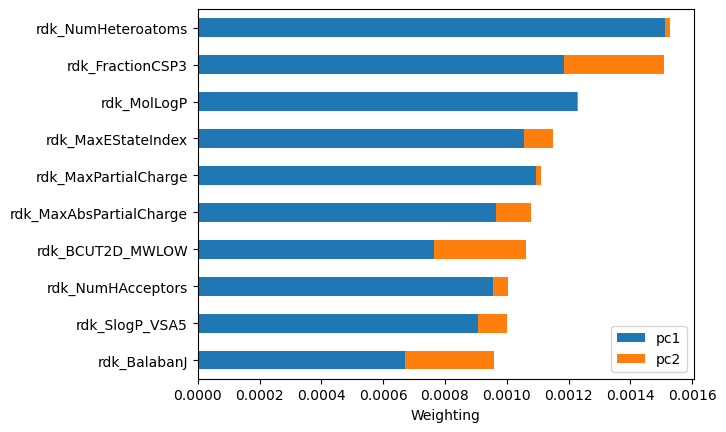

'In plot'

pc1       pc2    length
rdk_NumHeteroatoms      -0.231579 -0.046675  0.001529
rdk_FractionCSP3         0.205050 -0.201241  0.001508
rdk_MolLogP              0.208720 -0.013914  0.001229
rdk_MaxEStateIndex      -0.193701 -0.108421  0.001151
rdk_MaxPartialCharge    -0.197124  0.043513  0.001110
rdk_MaxAbsPartialCharge -0.184930 -0.119542  0.001078
rdk_BCUT2D_MWLOW        -0.164894  0.192218  0.001061
rdk_NumHAcceptors       -0.184095 -0.077534  0.001003
rdk_SlogP_VSA5           0.179329 -0.109424  0.001002
rdk_BalabanJ            -0.154342  0.190106  0.000960

0 rdk_NumHeteroatoms
1 rdk_FractionCSP3
2 rdk_MolLogP
3 rdk_MaxEStateIndex
4 rdk_MaxPartialCharge
5 rdk_MaxAbsPartialCharge
6 rdk_BCUT2D_MWLOW
7 rdk_NumHAcceptors
8 rdk_SlogP_VSA5
9 rdk_BalabanJ


In [85]:
Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =2
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=10)

#colors = X_prop['RingCount_5'] 
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', feature_arrow=True, num_feature=10, size=50, explained_var=exp_var )# yrange=[-5,10] )


## pattern 4 N in diene

In [86]:
df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)

patterns_col = [ c for c in df_diene_all_descriptor.columns if 'SMILES_pattern_' in c ]
pattern_yes = [c for c in patterns_col if c.count('N')==4 ]
pattern_no = [p for p in patterns_col if p not in pattern_yes]
print( patterns_col,'\n',pattern_yes,'\n',pattern_no )

mask1 = np.any( df_diene_all_descriptor[pattern_yes]==True, axis=1)
mask2 = np.all( df_diene_all_descriptor[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)

df_diene_pattern = df_diene_all_descriptor[mask_keep]

df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)
df_diene_pattern = df_diene_pattern.dropna(axis='columns')
#df_diene_pattern = df_diene_pattern.reset_index(drop=True)

df_diene_pattern['diene_types'] = -1
for i,p in enumerate(pattern_yes):
    mask = list(df_diene_pattern[p]==True)
    df_diene_pattern.loc[ mask, ['diene_types'] ]=i

df_diene_pattern

C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\3418258038.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diene_all_descriptor = pd.read_csv('df_diene_all_descriptor.csv', index_col=0)


['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N', 'SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_N=NN=N'] 
 ['SMILES_pattern_C=CC=C', 'SMILES_pattern_N=CC=C', 'SMILES_pattern_C=NC=C', 'SMILES_pattern_N=NC=C', 'SMILES_pattern_N=CN=C', 'SMILES_pattern_N=CC=N', 'SMILES_pattern_C=NN=C', 'SMILES_pattern_N=NN=C', 'SMILES_pattern_N=NC=N']


C:\Users\zhan051\AppData\Local\Temp\ipykernel_15692\3418258038.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diene_pattern.replace([np.inf, -np.inf], np.nan, inplace=True)


HOMO      LUMO                 SMILES source  \
4632  -8.701982 -1.289787               Cn1nnnn1    QM9   
4957  -8.623071 -1.194550              CCn1nnnn1    QM9   
5083  -8.859804 -3.150999             O=Cn1nnnn1    QM9   
6476  -8.269332 -1.219039           C1CC1n1nnnn1    QM9   
6622  -8.541439 -2.753723          CC(=O)n1nnnn1    QM9   
6646  -8.533276 -1.088428           CC(C)n1nnnn1    QM9   
6914  -8.593139 -1.161897             CCCn1nnnn1    QM9   
7221  -9.235312 -1.989102            N#CCn1nnnn1    QM9   
7300  -7.545527 -2.225835          NC(=N)n1nnnn1    QM9   
7320  -8.565928 -2.296583          NC(=O)n1nnnn1    QM9   
7515  -8.065251 -1.872096            O=CCn1nnnn1    QM9   
7614  -8.174094 -1.287066             OCCn1nnnn1    QM9   
15887 -7.872056 -1.395909           C#CCCn1nnnn1    QM9   
15937 -8.467970 -1.131965        C(C1CC1)n1nnnn1    QM9   
15961 -7.221720 -1.529241    C([C@H]1CN1)n1nnnn1    QM9   
15985 -8.103346 -1.295229    C([C@H]1CO1)n1nnnn1    QM9   
16207 -8.533276 -1.191829        C1CC(C1)n1nnnn1    QM9   
16498 -7.616275 -1.534683          C1OCC1n1nnnn1    QM9   
16593 -7.618996 -1.248971           CC#CCn1nnnn1    QM9   
16689 -7.733281 -1.287066         CC(=O)Cn1nnnn1    QM9   
16755 -8.106068 -1.295229    C[C@@H](C#C)n1nnnn1    QM9   
16777 -9.085653 -1.825838    C[C@@H](C#N)n1nnnn1    QM9   
16801 -8.473412 -1.023122        CC(C)(C)n1nnnn1    QM9   
16907 -8.579534 -1.164618          CC(C)Cn1nnnn1    QM9   
16977 -7.940082 -1.719716    C[C@@H](C=O)n1nnnn1    QM9   
17001 -8.111510 -1.167339     C[C@@H](CO)n1nnnn1    QM9   
17097 -8.054367 -1.140128     C[C@@H](O)Cn1nnnn1    QM9   
17126 -8.301985 -1.183665        CC1(CC1)n1nnnn1    QM9   
17956 -8.076136 -1.208155  C[C@H]1C[C@H]1n1nnnn1    QM9   
18172 -8.467970 -2.680254         CCC(=O)n1nnnn1    QM9   
18196 -8.500623 -1.053054     CC[C@@H](C)n1nnnn1    QM9   
18554 -8.576813 -1.142849            CCCCn1nnnn1    QM9   
19449 -7.091108 -2.100666         CNC(=N)n1nnnn1    QM9   
19469 -8.092462 -2.174135         CNC(=O)n1nnnn1    QM9   
19734 -8.315590 -2.242162         COC(=N)n1nnnn1    QM9   
19755 -8.753682 -2.446242         COC(=O)n1nnnn1    QM9   
20045 -7.695186 -1.284345            COCCn1nnnn1    QM9   
20107 -9.096537 -1.787743           N#CCCn1nnnn1    QM9   
20388 -7.741444 -1.213597         NC(=O)Cn1nnnn1    QM9   
21171 -8.780893 -3.336032        O=C(C#C)n1nnnn1    QM9   
21192 -9.463881 -4.149632        O=C(C#N)n1nnnn1    QM9   
21330 -8.370011 -4.013578        O=CC(=O)n1nnnn1    QM9   
21429 -7.651649 -1.665295           O=CCCn1nnnn1    QM9   
21826 -7.436684 -1.502031  O[C@H]1C[C@H]1n1nnnn1    QM9   
21914 -8.492459 -2.786376         OCC(=O)n1nnnn1    QM9   
22083 -7.847566 -1.189108            OCCCn1nnnn1    QM9   

       SMILES_pattern_C=CC=C  SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  \
4632                   False                  False                  False   
4957                   False                  False                  False   
5083                   False                  False                  False   
6476                   False                  False                  False   
6622                   False                  False                  False   
6646                   False                  False                  False   
6914                   False                  False                  False   
7221                   False                  False                  False   
7300                   False                  False                  False   
7320                   False                  False                  False   
7515                   False                  False                  False   
7614                   False                  False                  False   
15887                  False                  False                  False   
15937                  False                  False                  False   
15961                  False                  False                

<AxesSubplot:xlabel='LUMO', ylabel='Count'>

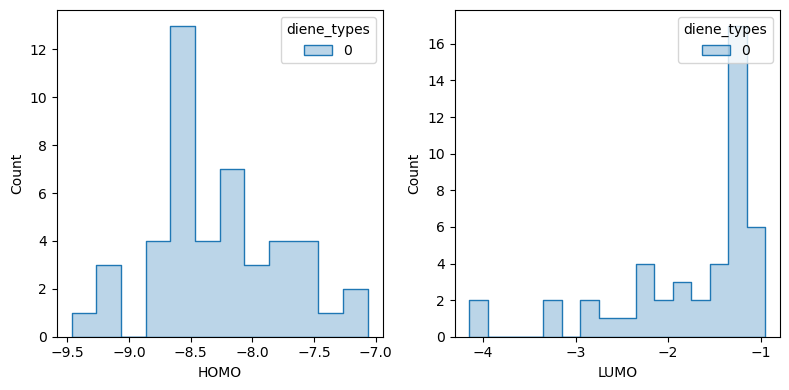

In [87]:
fig, axs = plt.subplots(1,2,figsize=(8,4),tight_layout=True,dpi=100)
sns.histplot(df_diene_pattern, x='HOMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[0], element="step", alpha=0.3, fill=True, ) #color='r', stat='percent',label='HOMO',  
sns.histplot(df_diene_pattern, x='LUMO', hue='diene_types', kde=False, binwidth=0.2, ax=axs[1], element="step", alpha=0.3, fill=True, ) #color='r', stat='percent',label='LUMO',  

In [88]:
## x = 'SMILES_pattern_' , 'rdk_' , 'padelpy_' (padelpy_PubchemFP or not) , 'RingCount_' : if 'rdk_' in c or 'padelpy_' in c or 'RingCount_' in c
feature_col = ['LUMO'] + [c for c in df_diene_pattern.columns if 'rdk_' in c or 'RingCount_' in c]    
X_features = df_diene_pattern[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, highlight= remove_high_corr_gradually(X_features, cutoff=0.8, highlight=['LUMO'])
X_features_prop_clean

sns.histplot(highlight.drop('LUMO'), x='LUMO', kde=False, binwidth=0.05, alpha=0.5, fill=True) #color='r', stat='percent',label='LUMO', element="step",

mask = highlight.drop('LUMO',axis=0).abs()>0.6
highlight.drop('LUMO')[ mask.values ]

Before clean (46, 132)
After clean (46, 111)
Num of keep:  67
Num of drop:  44
---------


LUMO
rdk_MaxEStateIndex      -0.657021
rdk_MinEStateIndex       0.632355
rdk_MaxAbsEStateIndex   -0.657021
rdk_qed                  0.692462
rdk_MaxPartialCharge    -0.826396
rdk_MinAbsPartialCharge -0.755703
rdk_BCUT2D_MRHI         -0.768223
rdk_Chi1n                0.620694
rdk_Chi1v                0.620694
rdk_HallKierAlpha        0.757700
rdk_PEOE_VSA14          -0.652165
rdk_PEOE_VSA2           -0.725978
rdk_SMR_VSA10           -0.777933
rdk_SMR_VSA5             0.702067
rdk_TPSA                -0.613539
rdk_EState_VSA10        -0.730961
rdk_VSA_EState2         -0.711491
rdk_FractionCSP3         0.824233
rdk_NOCount             -0.652464
rdk_NumHAcceptors       -0.709013
rdk_NumHeteroatoms      -0.652464

Total Var  0.3211542214064937  from  2
Exp Var:  [0.21514695 0.10600727]
                              pc1       pc2     Total
rdk_EState_VSA6          0.000046  0.000001  0.000048
rdk_PEOE_VSA4            0.000062  0.000051  0.000113
rdk_SlogP_VSA4           0.000005  0.000119  0.000124
rdk_PEOE_VSA6            0.000008  0.000124  0.000132
rdk_PEOE_VSA11           0.000096  0.000043  0.000139
...                           ...       ...       ...
rdk_HallKierAlpha        0.002049  0.000075  0.002123
rdk_MaxAbsEStateIndex    0.002150  0.000010  0.002160
rdk_MolLogP              0.002377  0.000043  0.002419
rdk_MinAbsPartialCharge  0.002440  0.000009  0.002449
rdk_NumHAcceptors        0.002376  0.000161  0.002537

[66 rows x 3 columns]


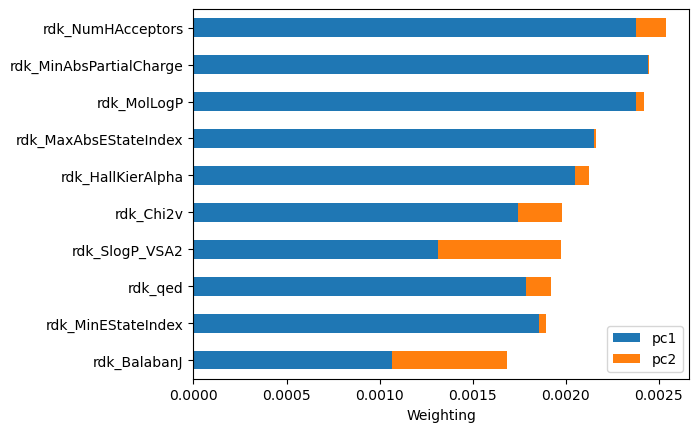

'In plot'

pc1       pc2    length
rdk_NumHAcceptors        0.226549 -0.119851  0.002537
rdk_MinAbsPartialCharge  0.229614  0.027901  0.002449
rdk_MolLogP             -0.226598  0.061619  0.002419
rdk_MaxAbsEStateIndex    0.215523 -0.029088  0.002160
rdk_HallKierAlpha       -0.210379 -0.081553  0.002123
rdk_Chi2v               -0.194102 -0.143985  0.001977
rdk_SlogP_VSA2           0.168585 -0.242128  0.001974
rdk_qed                 -0.196563 -0.108620  0.001921
rdk_MinEStateIndex      -0.200290  0.055322  0.001891
rdk_BalabanJ             0.151959  0.234268  0.001686

0 rdk_NumHAcceptors
1 rdk_MinAbsPartialCharge
2 rdk_MolLogP
3 rdk_MaxAbsEStateIndex
4 rdk_HallKierAlpha
5 rdk_Chi2v
6 rdk_SlogP_VSA2
7 rdk_qed
8 rdk_MinEStateIndex
9 rdk_BalabanJ


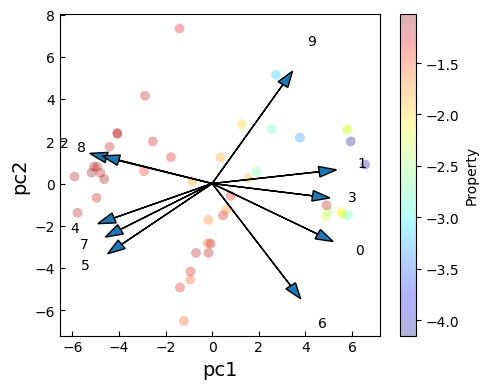

In [89]:
Y_prop = X_features_prop_clean['LUMO']
X_prop = X_features_prop_clean.drop('LUMO',axis=1)

n_pca =2
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X_prop, n_pca, if_plot=True, top_features=10)

#colors = X_prop['RingCount_5'] 
colors = Y_prop
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', feature_arrow=True, num_feature=10, size=50, explained_var=exp_var )# yrange=[-5,10] )


# All dienes

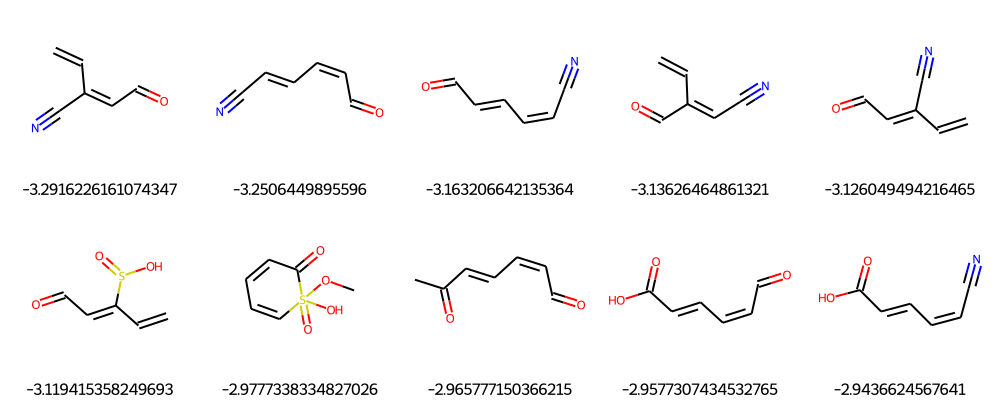

In [101]:
df = df_pnl.sort_values(by='LUMO',ascending=True).head(10)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=5, legends=[str(p) for p in df['LUMO']] ) 
img

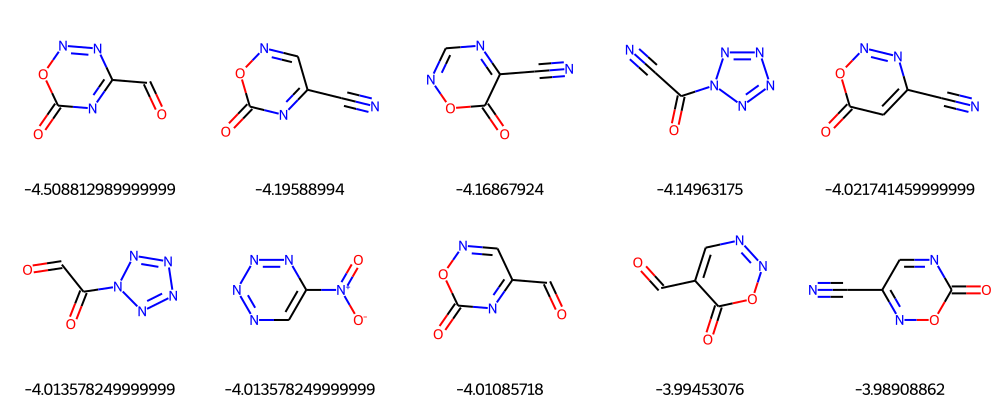

In [102]:
df = df_qm9.sort_values(by='LUMO',ascending=True).head(10)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=5, legends=[str(p) for p in df['LUMO']] ) 
img

# Additiona analysis

In [21]:
def locate_func( smi, pattern='C=CC=C', pattern_ngb=[1,2,2,1] ):
    """
    return a dict: key=location, value=functionl groups
    """
    pattern = Chem.MolFromSmiles(pattern)
    mol = Chem.MolFromSmiles(smi)
    #display(mol)
    #display( mol_with_atom_index(mol) )
    atoms_in_diene = mol.GetSubstructMatches(pattern)[0]
    bonds = [ mol.GetAtomWithIdx(at).GetBonds() for at in atoms_in_diene ]
    output = {}
    dummy_atom = Chem.Atom(82)
    for ii,(at,bond,patt) in enumerate(zip(atoms_in_diene,bonds,pattern_ngb)):
        if len(bond)>patt: ## There is a func here
            func_bond = [b for b in bond if b.GetBeginAtom().GetIdx() not in atoms_in_diene or b.GetEndAtom().GetIdx() not in atoms_in_diene]
            func_bond = [ b.GetIdx() for b in func_bond]
            mol_fragments = Chem.FragmentOnBonds( mol, func_bond , addDummies=True , dummyLabels=[(0,0) for b in func_bond] )
            mol_fragments = Chem.RWMol(mol_fragments)            
            mol_fragments.ReplaceAtom(at, dummy_atom)
            mol_fragments = Chem.GetMolFrags(mol_fragments, asMols=True)
            mol_fragments = [ fragment for fragment in mol_fragments if not any(a.GetSymbol()=='Pb' for a in fragment.GetAtoms()) ]

            mol_fragments = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol_fragments]
            output[ii] = mol_fragments
    return output

In [118]:
## Padel also provides pubchem
from padelpy import from_smiles

descriptors = from_smiles( 'FC(F)(F)c1cocc1', fingerprints=True)
col_names = list(descriptors.keys())


In [14]:
display(df_pnl,df_qm9)

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
257  -7.844547 -3.291623  C=C/C(C#N)=C\C=O    PNL                   True   
1375 -7.729353 -3.250645   N#C/C=C/C=C\C=O    PNL                   True   
4352 -7.672307 -3.163207   N#C/C=C\C=C\C=O    PNL                   True   
2759 -7.781885 -3.136265  C=C/C(C=O)=C\C#N    PNL                   True   
1759 -7.776203 -3.126049  C=C/C(C#N)=C/C=O    PNL                   True   
...        ...       ...               ...    ...                    ...   
2510 -7.466715  0.379902       C/C=C/C=C/C    PNL                   True   
2299 -6.947992  0.392159     CO/C=C/C=C/OC    PNL                   True   
1309 -6.630128  0.397719     CO/C=C\C=C\OC    PNL                   True   
813  -5.451796  0.404868  C=C(/C=C\C)N(C)C    PNL                   True   
2216 -4.993262  0.434078   CN(C)/C=C/C=C/O    PNL                   True   

      SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
257                   False                  False                  False   
1375                  False                  False                  False   
4352                  False                  False                  False   
2759                  False                  False                  False   
1759                  False                  False                  False   
...                     ...                    ...                    ...   
2510                  False                  False                  False   
2299                  False                  False                  False   
1309                  False                  False                  False   
813                   False                  False                  False   
2216                  False                  False                  False   

      SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  padelpy_PubchemFP871  \
257                   False                  False  ...                   0.0   
1375                  False                  False  ...                   0.0   
4352                  False                  False  ...                   0.0   
2759                  False                  False  ...                   0.0   
1759                  False                  False  ...                   0.0   
...                     ...                    ...  ...                   ...   
2510                  False                  False  ...                   0.0   
2299                  False                  False  ...                   0.0   
1309                  False                  False  ...                   0.0   
813                   False                  False  ...                   0.0   
2216                  False                  False  ...                   0.0   

      padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
257                    0.0                   0.0                   0.0   
1375                   0.0                   0.0                   0.0   
4352                   0.0                   0.0                   0.0   
2759                   0.0                   0.0                   0.0   
1759                   0.0                   0.0                   0.0   
...                    ...                   ...                   ...   
2510                   0.0                   0.0                   0.0   
2299                   0.0                   0.0                   0.0   
1309                   0.0                   0.0                   0.0   
813                    0.0                   0.0                   0.0   
2216                   0.0                   0.0                   0.0   

     padelpy_PubchemFP875  padelpy_PubchemFP876  padelpy_PubchemFP877  \
257                   0.0                   0.0                   0.0   
1375                  0.0                   0.0                   0.0   
4352                  0.0                   0.0                   0.0   
2759              

HOMO      LUMO            SMILES source  SMILES_pattern_C=CC=C  \
9077  -6.930565 -2.854402   O=Cc1cc(=O)occ1    QM9                   True   
8920  -7.189067 -2.838076   O=c1occc(c1)C#N    QM9                   True   
9117  -7.009476 -2.816307   O=Cc1cccc(=O)o1    QM9                   True   
9048  -6.329209 -2.775491   O=CC(=O)n1cccc1    QM9                   True   
8804  -7.167298 -2.770049   O=c1oc(ccc1)C#N    QM9                   True   
...         ...       ...               ...    ...                    ...   
5546  -4.443507  1.991823   COc1ccc(O)[nH]1    QM9                   True   
14784 -4.372759  1.997265  CCOc1cc(N)c[nH]1    QM9                   True   
13875 -4.361875  2.013592  CNc1c[nH]c(OC)c1    QM9                   True   
14486 -4.663914  2.013592  COc1c[nH]c(O)c1N    QM9                   True   
14112 -4.432623  2.100666  COc1ccc([nH]1)OC    QM9                   True   

       SMILES_pattern_N=CC=C  SMILES_pattern_C=NC=C  SMILES_pattern_N=NC=C  \
9077                   False                  False                  False   
8920                   False                  False                  False   
9117                   False                  False                  False   
9048                   False                  False                  False   
8804                   False                  False                  False   
...                      ...                    ...                    ...   
5546                   False                  False                  False   
14784                  False                  False                  False   
13875                  False                  False                  False   
14486                  False                  False                  False   
14112                  False                  False                  False   

       SMILES_pattern_N=CN=C  SMILES_pattern_N=CC=N  ...  \
9077                   False                  False  ...   
8920                   False                  False  ...   
9117                   False                  False  ...   
9048                   False                  False  ...   
8804                   False                  False  ...   
...                      ...                    ...  ...   
5546                   False                  False  ...   
14784                  False                  False  ...   
13875                  False                  False  ...   
14486                  False                  False  ...   
14112                  False                  False  ...   

       padelpy_PubchemFP872  padelpy_PubchemFP873  padelpy_PubchemFP874  \
9077                    0.0                   0.0                   0.0   
8920                    0.0                   0.0                   0.0   
9117                    0.0                   0.0                   0.0   
9048                    0.0                   0.0                   0.0   
8804                    0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
5546                    0.0                   0.0                   0.0   
14784                   0.0                   0.0                   0.0   
13875                   0.0                   0.0                   0.0   
14486                   0.0                   0.0                   0.0   
14112                   0.0                   0.0                   0.0   

       padelpy_PubchemFP875 padelpy_PubchemFP876  padelpy_PubchemFP877  \
9077                    0.0                  0.0                   0.0   
8920                    0.0                  0.0                   0.0   
9117                    0.0                  0.0                   0.0   
9048                    0.0                  0.0                   0.0   
8804                    0.0                  0.0                   0.0   
...                     ...                  ...                   ...   
5546     

In [22]:
for s in df_pnl.head(9)['SMILES']:
    print( locate_func(s) )

{2: ['*C#N'], 3: ['*C=O']}
{0: ['*C#N'], 3: ['*C=O']}
{0: ['*C#N'], 3: ['*C=O']}
{2: ['*C=O'], 3: ['*C#N']}
{2: ['*C#N'], 3: ['*C=O']}
{2: ['*S(=O)O'], 3: ['*C=O']}
{0: ['*C(C)=O'], 3: ['*C=O']}
{0: ['*C=O'], 3: ['*C(=O)O']}
{0: ['*C#N'], 3: ['*C(=O)O']}


In [23]:
top = df_pnl.head(9)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=3, subImgSize=(400, 300), returnPNG=False, legends=[str(round(p,2))+' eV' for p in top['LUMO']], )  
img.save('CCCC_lowest_LUMO.png')
display(img)

In [16]:
top = df_qm9.head(9)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=5, legends=[str(p) for p in top['LUMO']] )  
display(img)

## PNL CCCC 

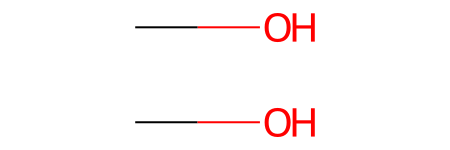

In [122]:
mol = Chem.MolFromSmiles( 'CO/C=C/C=C/OC' )
rm = AllChem.DeleteSubstructs(mol, d)
display( rm )

In [162]:
from itertools import chain

prop_list = [ 
    'TPSA',
    'MinAbsPartialCharge',
    'NumHeteroatoms',
    'MolLogP',
    'EState_VSA10',
    'PEOE_VSA6',
    'Chi1v',
    'MaxAbsEStateIndex',
    'BCUT2D_MRLOW',
    'BCUT2D_CHGHI',
]
    
from rdkit.ML.Descriptors import MoleculeDescriptors
def get_rdkprop(smies_list, prop_list):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(prop_list)           
    fp_data = {}
    for smi in smies_list:
        fp = calc.CalcDescriptors( Chem.MolFromSmiles(smi) )
        fp_data[smi] = fp
    return fp_data

functionality=[] 
for s in df_pnl['SMILES']:
    f=list(chain( *locate_func(smi=s).values() ) )
    functionality += f

functionality = list(set(functionality ))
functionality = get_rdkprop(functionality, prop_list )

functionality = pd.DataFrame(functionality.values(), index=functionality.keys(), columns=prop_list)
functionality = functionality.dropna(axis='columns')
functionality = clean_std(functionality)
print(functionality.columns)
functionality = {k: list(v.values()) for k,v in functionality.to_dict('index').items() }
functionality['*C=O']

Before clean (141, 7)
After clean (141, 6)
Index(['TPSA', 'NumHeteroatoms', 'MolLogP', 'EState_VSA10', 'Chi1v',
       'MaxAbsEStateIndex'],
      dtype='object')


[17.07, 2, -0.2741, 0.0, 0.2357022603955159, 8.916666666666666]

In [172]:
known_func = ['*O', '*N(C)C', '*NC', '*N', '*OC', '*NC(=O)C', '*OC(=O)C', '*C', '*C=C', '*C=O', '*C(=O)C', '*C(=O)OC', '*C(=O)O', '*C#N', '*S(=O)(=O)O','*[N+](=O)[O-]']
functionality= get_rdkprop(known_func, prop_list)
functionality = pd.DataFrame(functionality.values(), index=functionality.keys(), columns=prop_list)
functionality = functionality.dropna(axis='columns')
functionality = clean_std(functionality)
functionality = {k: list(v.values()) for k,v in functionality.to_dict('index').items() }
functionality['*N(C)C']

Before clean (16, 7)
After clean (16, 6)


[3.24, 2, 0.012299999999999978, 0.0, 0.8944271909999159, 2.25]

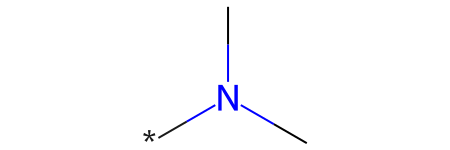

(3.24, 2, 0.012299999999999978, 0.0, 0.8944271909999159, 2.25)

In [173]:
mol_ref = Chem.MolFromSmiles( '*N(C)C' )
display( mol_ref )
calc = MoleculeDescriptors.MolecularDescriptorCalculator(['TPSA', 'NumHeteroatoms', 'MolLogP', 'EState_VSA10', 'Chi1v','MaxAbsEStateIndex'])  
vec_ref = calc.CalcDescriptors( mol_ref )
vec_ref

In [176]:
def dist_cos(v1,v2):
    dot_product = np.dot(v1, v2)
    d1,d2 = np.linalg.norm(v1), np.linalg.norm(v2)
    cosine_distance = dot_product / (d1 * d2)
    return cosine_distance

df = [ [ k, dist_cos(v, vec_ref) ] for k,v in functionality.items() ]
df = pd.DataFrame(df, columns=['name','dist']).sort_values(by='dist',ascending=True)

fig, axs = plt.subplots(1,1,  figsize=(4,4),tight_layout=True)
df.plot(kind='barh', x='name', y=['dist'], color=['limegreen'], legend=False, fontsize=8, xlabel=None, ax=axs)
df

name      dist
8            *C=C  0.610240
7              *C  0.619164
14    *S(=O)(=O)O  0.824277
3              *N  0.826812
15  *[N+](=O)[O-]  0.842479
12        *C(=O)O  0.850061
13           *C#N  0.868578
5        *NC(=O)C  0.873616
0              *O  0.881255
11       *C(=O)OC  0.881310
6        *OC(=O)C  0.881542
2             *NC  0.884336
10        *C(=O)C  0.891136
9            *C=O  0.910680
4             *OC  0.939755
1          *N(C)C  1.000000

## QM9 CCCC

RingCount_3 350
RingCount_4 188
RingCount_5 3146
RingCount_6 638
RingCount_7 258
RingCount_8 53
RingCount_9 14
RingCount_10 0
RingCount_11 0
14


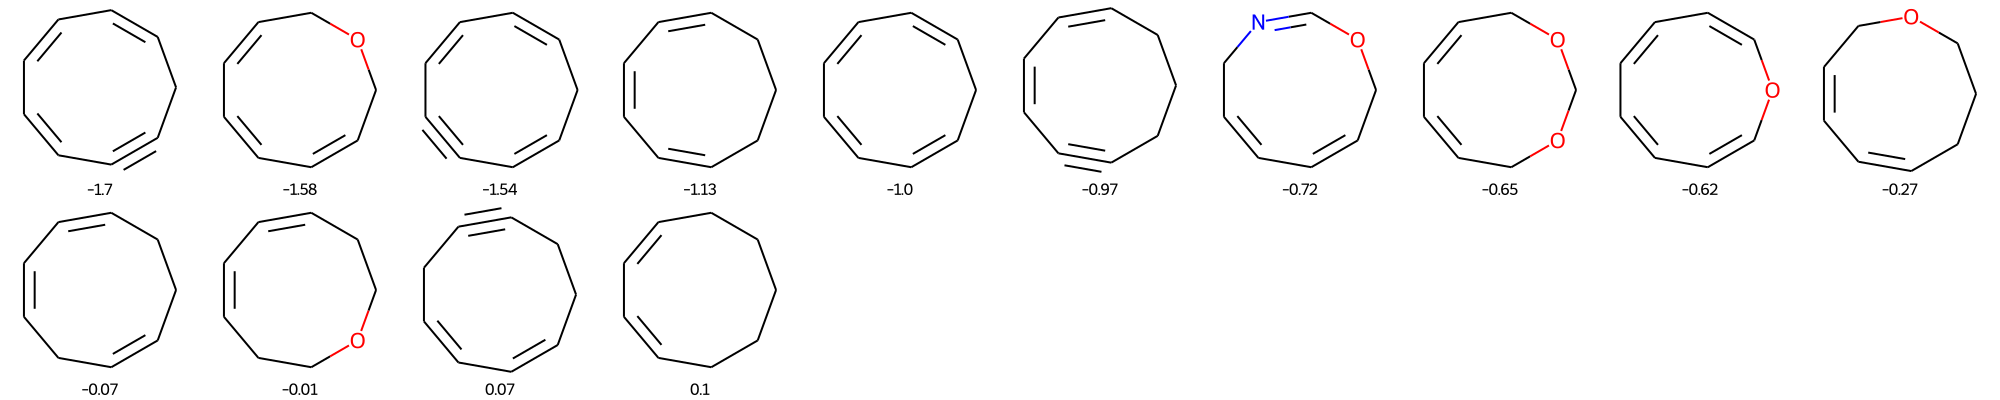

In [72]:
df_qm9 = df_diene_pattern[ df_diene_pattern['source'] =='QM9' ].sort_values(by='LUMO',ascending=True)

ring = [ c for c in df_qm9.columns if 'RingCount_' in c ]
for r in ring:
    #display(df_qm9['RingCount_3'].value_counts())
    df = df_qm9[df_qm9[r]==1]
    print(r, len(df) )



df = df[df['RingCount_9']==1]

print( len(df) )
Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in df['SMILES']], molsPerRow=10, legends=[str(round(p,2)) for p in df['LUMO']] )  


# Understand descriptor meaning

In [37]:
# from: https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/Descriptors/Crippen.cpp#L194
# each line includes the atom label, the SMARTS, the logP contribution, the MR contribution, and an optional note
rdkit_data='''C1    [CH4]   0.1441  2.503   
C1  [CH3]C  0.1441  2.503   
C1  [CH2](C)C   0.1441  2.503   
C2  [CH](C)(C)C 0   2.433   
C2  [C](C)(C)(C)C   0   2.433   
C3  [CH3][N,O,P,S,F,Cl,Br,I]    -0.2035 2.753   
C3  [CH2X4]([N,O,P,S,F,Cl,Br,I])[A;!#1] -0.2035 2.753   
C4  [CH1X4]([N,O,P,S,F,Cl,Br,I])([A;!#1])[A;!#1]    -0.2051 2.731   
C4  [CH0X4]([N,O,P,S,F,Cl,Br,I])([A;!#1])([A;!#1])[A;!#1]   -0.2051 2.731   
C5  [C]=[!C;A;!#1]  -0.2783 5.007   
C6  [CH2]=C 0.1551  3.513   
C6  [CH1](=C)[A;!#1]    0.1551  3.513   
C6  [CH0](=C)([A;!#1])[A;!#1]   0.1551  3.513   
C6  [C](=C)=C   0.1551  3.513   
C7  [CX2]#[A;!#1]   0.0017  3.888   
C8  [CH3]c  0.08452 2.464   
C9  [CH3]a  -0.1444 2.412   
C10 [CH2X4]a    -0.0516 2.488   
C11 [CHX4]a 0.1193  2.582   
C12 [CH0X4]a    -0.0967 2.576   
C13 [cH0]-[A;!C;!N;!O;!S;!F;!Cl;!Br;!I;!#1] -0.5443 4.041   
C14 [c][#9] 0   3.257   
C15 [c][#17]    0.245   3.564   
C16 [c][#35]    0.198   3.18    
C17 [c][#53]    0   3.104   
C18 [cH]    0.1581  3.35    
C19 [c](:a)(:a):a   0.2955  4.346   
C20 [c](:a)(:a)-a   0.2713  3.904   
C21 [c](:a)(:a)-C   0.136   3.509   
C22 [c](:a)(:a)-N   0.4619  4.067   
C23 [c](:a)(:a)-O   0.5437  3.853   
C24 [c](:a)(:a)-S   0.1893  2.673   
C25 [c](:a)(:a)=[C,N,O] -0.8186 3.135   
C26 [C](=C)(a)[A;!#1]   0.264   4.305   
C26 [C](=C)(c)a 0.264   4.305   
C26 [CH1](=C)a  0.264   4.305   
C26 [C]=c   0.264   4.305   
C27 [CX4][A;!C;!N;!O;!P;!S;!F;!Cl;!Br;!I;!#1]   0.2148  2.693   
CS  [#6]    0.08129 3.243   
H1  [#1][#6,#1] 0.123   1.057   
H2  [#1]O[CX4,c]    -0.2677 1.395   
H2  [#1]O[!#6;!#7;!#8;!#16] -0.2677 1.395   
H2  [#1][!#6;!#7;!#8]   -0.2677 1.395   
H3  [#1][#7]    0.2142  0.9627  
H3  [#1]O[#7]   0.2142  0.9627  
H4  [#1]OC=[#6,#7,O,S]  0.298   1.805   
H4  [#1]O[O,S]  0.298   1.805   
HS  [#1]    0.1125  1.112   
N1  [NH2+0][A;!#1]  -1.019  2.262   
N2  [NH+0]([A;!#1])[A;!#1]  -0.7096 2.173   
N3  [NH2+0]a    -1.027  2.827   
N4  [NH1+0]([!#1;A,a])a -0.5188 3   
N5  [NH+0]=[!#1;A,a]    0.08387 1.757   
N6  [N+0](=[!#1;A,a])[!#1;A,a]  0.1836  2.428   
N7  [N+0]([A;!#1])([A;!#1])[A;!#1]  -0.3187 1.839   
N8  [N+0](a)([!#1;A,a])[A;!#1]  -0.4458 2.819   
N8  [N+0](a)(a)a    -0.4458 2.819   
N9  [N+0]#[A;!#1]   0.01508 1.725   
N10 [NH3,NH2,NH;+,+2,+3]    -1.95       
N11 [n+0]   -0.3239 2.202   
N12 [n;+,+2,+3] -1.119      
N13 [NH0;+,+2,+3]([A;!#1])([A;!#1])([A;!#1])[A;!#1] -0.3396 0.2604  
N13 [NH0;+,+2,+3](=[A;!#1])([A;!#1])[!#1;A,a]   -0.3396 0.2604  
N13 [NH0;+,+2,+3](=[#6])=[#7]   -0.3396 0.2604  
N14 [N;+,+2,+3]#[A;!#1] 0.2887  3.359   
N14 [N;-,-2,-3] 0.2887  3.359   
N14 [N;+,+2,+3](=[N;-,-2,-3])=N 0.2887  3.359   
NS  [#7]    -0.4806 2.134   
O1  [o] 0.1552  1.08    
O2  [OH,OH2]    -0.2893 0.8238  
O3  [O]([A;!#1])[A;!#1] -0.0684 1.085   
O4  [O](a)[!#1;A,a] -0.4195 1.182   
O5  [O]=[#7,#8] 0.0335  3.367   
O5  [OX1;-,-2,-3][#7]   0.0335  3.367   
O6  [OX1;-,-2,-2][#16]  -0.3339 0.7774  
O6  [O;-0]=[#16;-0] -0.3339 0.7774  
O12 [O-]C(=O)   -1.326      \"order flip here intentional\"
O7  [OX1;-,-2,-3][!#1;!N;!S]    -1.189  0   
O8  [O]=c   0.1788  3.135   
O9  [O]=[CH]C   -0.1526 0   
O9  [O]=C(C)([A;!#1])   -0.1526 0   
O9  [O]=[CH][N,O]   -0.1526 0   
O9  [O]=[CH2]   -0.1526 0   
O9  [O]=[CX2]=O -0.1526 0   
O10 [O]=[CH]c   0.1129  0.2215  
O10 [O]=C([C,c])[a;!#1] 0.1129  0.2215  
O10 [O]=C(c)[A;!#1] 0.1129  0.2215  
O11 [O]=C([!#1;!#6])[!#1;!#6]   0.4833  0.389   
OS  [#8]    -0.1188 0.6865  
F   [#9-0]  0.4202  1.108   
Cl  [#17-0] 0.6895  5.853   
Br  [#35-0] 0.8456  8.927   
I   [#53-0] 0.8857  14.02   
Hal [#9,#17,#35,#53;-]  -2.996      
Hal [#53;+,+2,+3]   -2.996      
Hal [+;#3,#11,#19,#37,#55]  -2.996      \"Footnote h indicates these should be here?\"
P   [#15]   0.8612  6.92    
S2  [S;-,-2,-3,-4,+1,+2,+3,+5,+6]   -0.0024 7.365   \"Order flip here is intentional\"
S2  [S-0]=[N,O,P,S] -0.0024 7.365   \"Expanded definition of (pseudo-)ionic S\"
S1  [S;A]   0.6482  7.591   \"Order flip here is intentional\"
S3  [s;a]   0.6237  6.691   
Me1 [#3,#11,#19,#37,#55]    -0.3808 5.754   
Me1 [#4,#12,#20,#38,#56]    -0.3808 5.754   
Me1 [#5,#13,#31,#49,#81]    -0.3808 5.754   
Me1 [#14,#32,#50,#82]   -0.3808 5.754   
Me1 [#33,#51,#83]   -0.3808 5.754   
Me1 [#34,#52,#84]   -0.3808 5.754   
Me2 [#21,#22,#23,#24,#25,#26,#27,#28,#29,#30]   -0.0025     
Me2 [#39,#40,#41,#42,#43,#44,#45,#46,#47,#48]   -0.0025     
Me2 [#72,#73,#74,#75,#76,#77,#78,#79,#80]   -0.0025     '''

In [38]:
from collections import namedtuple

CrippenTuple = namedtuple('CrippenTuple',('name','smarts','logp_contrib','mr_contrib'))
lines = [x.split('\t') for x in rdkit_data.split('\n')]

crippenData = []
for i,entry in enumerate(lines):
    entry = entry[0].split()
    entry[2] = float(entry[2])
    if len(entry)<=3:
        entry.append(None)
    else:
        try: 
            entry[3] = float(entry[3])
        except:
            entry[3] = None
    entry = entry[:4]
    crippenData.append(CrippenTuple(*entry))
print(crippenData[:3])

[CrippenTuple(name='C1', smarts='[CH4]', logp_contrib=0.1441, mr_contrib=2.503), CrippenTuple(name='C1', smarts='[CH3]C', logp_contrib=0.1441, mr_contrib=2.503), CrippenTuple(name='C1', smarts='[CH2](C)C', logp_contrib=0.1441, mr_contrib=2.503)]


In [39]:
import re
def find_contribs_for_bin(lower,upper,crippenData=crippenData,which='mr_contrib'):
    ' returns a list of Crippen contributions which are between lower and upper '
    res = []
    for tpl in crippenData:
        v = getattr(tpl,which)
        if v is not None and v>=lower and v<=upper:
            res.append(tpl)
    return res
def find_tuples_for_atom(symbol,crippenData=crippenData):
    ' returns a list of crippen contributions for a particular atomic symbol, i.e. "C" or "N"'
    res = []
    anum = Chem.GetPeriodicTable().GetAtomicNumber(symbol)
    for tpl in crippenData:
        if tpl.name.startswith(symbol) or re.match(f'\[[^\]]*#{anum}[^0-9]',tpl.smarts):
            res.append(tpl)
    return res

In [40]:
print(Descriptors.SMR_VSA1.__doc__)

MOE MR VSA Descriptor 1 (-inf < x <  1.29)


In [50]:
sub = find_contribs_for_bin(-999999999,1.29, which='mr_contrib')
sub

[CrippenTuple(name='H1', smarts='[#1][#6,#1]', logp_contrib=0.123, mr_contrib=1.057),
 CrippenTuple(name='H3', smarts='[#1][#7]', logp_contrib=0.2142, mr_contrib=0.9627),
 CrippenTuple(name='H3', smarts='[#1]O[#7]', logp_contrib=0.2142, mr_contrib=0.9627),
 CrippenTuple(name='HS', smarts='[#1]', logp_contrib=0.1125, mr_contrib=1.112),
 CrippenTuple(name='N13', smarts='[NH0;+,+2,+3]([A;!#1])([A;!#1])([A;!#1])[A;!#1]', logp_contrib=-0.3396, mr_contrib=0.2604),
 CrippenTuple(name='N13', smarts='[NH0;+,+2,+3](=[A;!#1])([A;!#1])[!#1;A,a]', logp_contrib=-0.3396, mr_contrib=0.2604),
 CrippenTuple(name='N13', smarts='[NH0;+,+2,+3](=[#6])=[#7]', logp_contrib=-0.3396, mr_contrib=0.2604),
 CrippenTuple(name='O1', smarts='[o]', logp_contrib=0.1552, mr_contrib=1.08),
 CrippenTuple(name='O2', smarts='[OH,OH2]', logp_contrib=-0.2893, mr_contrib=0.8238),
 CrippenTuple(name='O3', smarts='[O]([A;!#1])[A;!#1]', logp_contrib=-0.0684, mr_contrib=1.085),
 CrippenTuple(name='O4', smarts='[O](a)[!#1;A,a]', lo

CrippenTuple(name='H1', smarts='[#1][#6,#1]', logp_contrib=0.123, mr_contrib=1.057)

CrippenTuple(name='H3', smarts='[#1][#7]', logp_contrib=0.2142, mr_contrib=0.9627)

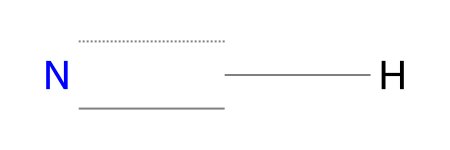

CrippenTuple(name='H3', smarts='[#1]O[#7]', logp_contrib=0.2142, mr_contrib=0.9627)

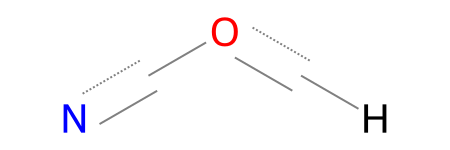

CrippenTuple(name='HS', smarts='[#1]', logp_contrib=0.1125, mr_contrib=1.112)

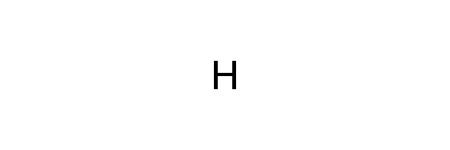

CrippenTuple(name='N13', smarts='[NH0;+,+2,+3]([A;!#1])([A;!#1])([A;!#1])[A;!#1]', logp_contrib=-0.3396, mr_contrib=0.2604)

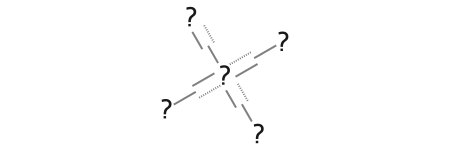

CrippenTuple(name='N13', smarts='[NH0;+,+2,+3](=[A;!#1])([A;!#1])[!#1;A,a]', logp_contrib=-0.3396, mr_contrib=0.2604)

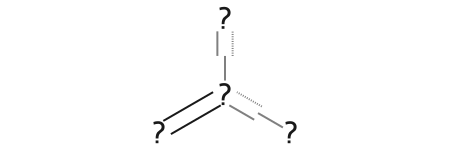

CrippenTuple(name='N13', smarts='[NH0;+,+2,+3](=[#6])=[#7]', logp_contrib=-0.3396, mr_contrib=0.2604)

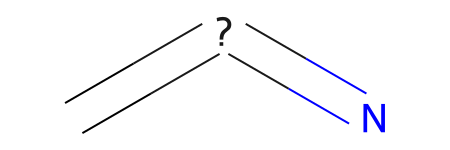

CrippenTuple(name='O1', smarts='[o]', logp_contrib=0.1552, mr_contrib=1.08)

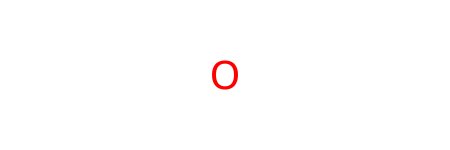

CrippenTuple(name='O2', smarts='[OH,OH2]', logp_contrib=-0.2893, mr_contrib=0.8238)

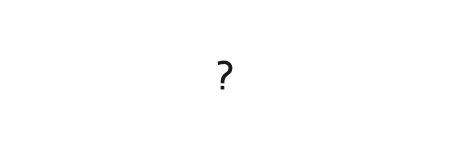

CrippenTuple(name='O3', smarts='[O]([A;!#1])[A;!#1]', logp_contrib=-0.0684, mr_contrib=1.085)

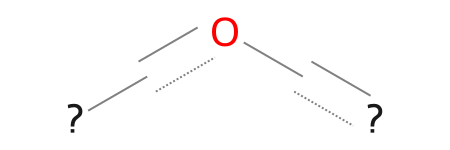

CrippenTuple(name='O4', smarts='[O](a)[!#1;A,a]', logp_contrib=-0.4195, mr_contrib=1.182)

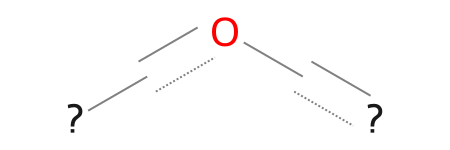

CrippenTuple(name='O6', smarts='[OX1;-,-2,-2][#16]', logp_contrib=-0.3339, mr_contrib=0.7774)

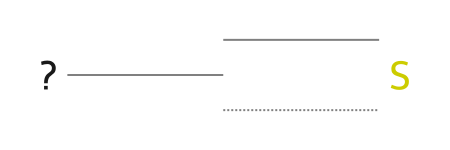

CrippenTuple(name='O6', smarts='[O;-0]=[#16;-0]', logp_contrib=-0.3339, mr_contrib=0.7774)

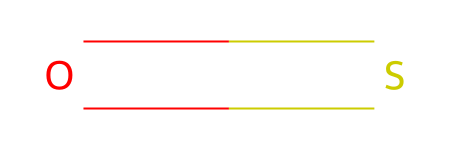

CrippenTuple(name='O7', smarts='[OX1;-,-2,-3][!#1;!N;!S]', logp_contrib=-1.189, mr_contrib=0.0)

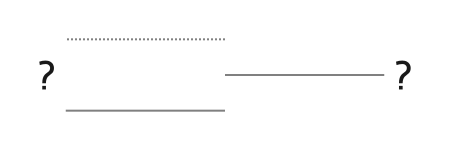

CrippenTuple(name='O9', smarts='[O]=[CH]C', logp_contrib=-0.1526, mr_contrib=0.0)

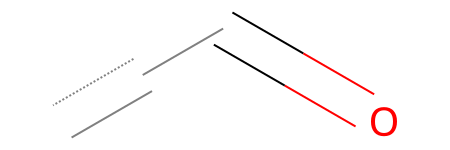

CrippenTuple(name='O9', smarts='[O]=C(C)([A;!#1])', logp_contrib=-0.1526, mr_contrib=0.0)

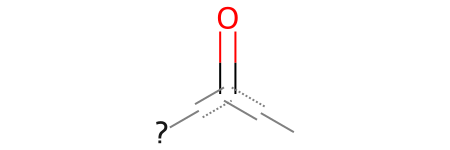

CrippenTuple(name='O9', smarts='[O]=[CH][N,O]', logp_contrib=-0.1526, mr_contrib=0.0)

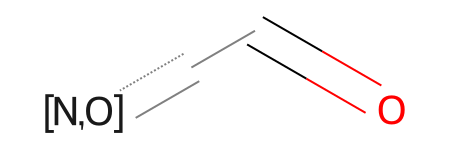

CrippenTuple(name='O9', smarts='[O]=[CH2]', logp_contrib=-0.1526, mr_contrib=0.0)

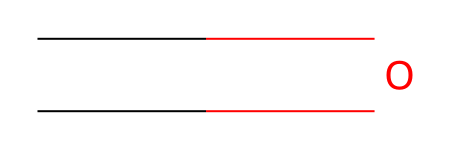

CrippenTuple(name='O9', smarts='[O]=[CX2]=O', logp_contrib=-0.1526, mr_contrib=0.0)

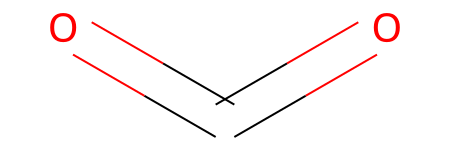

CrippenTuple(name='O10', smarts='[O]=[CH]c', logp_contrib=0.1129, mr_contrib=0.2215)

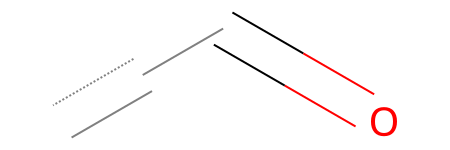

CrippenTuple(name='O10', smarts='[O]=C([C,c])[a;!#1]', logp_contrib=0.1129, mr_contrib=0.2215)

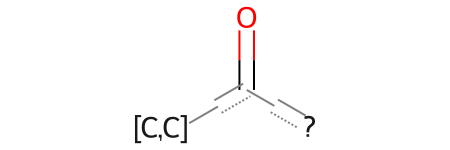

CrippenTuple(name='O10', smarts='[O]=C(c)[A;!#1]', logp_contrib=0.1129, mr_contrib=0.2215)

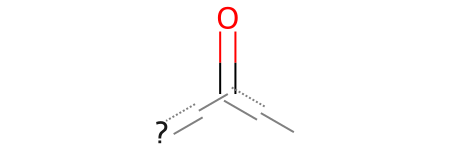

CrippenTuple(name='O11', smarts='[O]=C([!#1;!#6])[!#1;!#6]', logp_contrib=0.4833, mr_contrib=0.389)

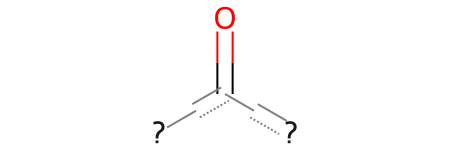

CrippenTuple(name='OS', smarts='[#8]', logp_contrib=-0.1188, mr_contrib=0.6865)

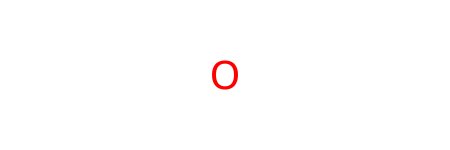

CrippenTuple(name='F', smarts='[#9-0]', logp_contrib=0.4202, mr_contrib=1.108)

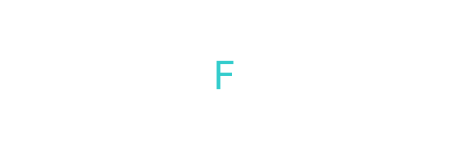

In [64]:
for at in sub:
    mol = Chem.MolFromSmarts(at[1])
    display(at, mol)
#img = Draw.MolsToGridImage( mol, molsPerRow=5, )#legends=[at[1] for at in sub] )  
#display(img)

In [42]:
print(Descriptors.SlogP_VSA6.__doc__)

MOE logP VSA Descriptor 6 ( 0.15 <= x <  0.20)


In [65]:
sub = find_contribs_for_bin( 0.15, 0.20, which='logp_contrib')
sub

[CrippenTuple(name='C6', smarts='[CH2]=C', logp_contrib=0.1551, mr_contrib=3.513),
 CrippenTuple(name='C6', smarts='[CH1](=C)[A;!#1]', logp_contrib=0.1551, mr_contrib=3.513),
 CrippenTuple(name='C6', smarts='[CH0](=C)([A;!#1])[A;!#1]', logp_contrib=0.1551, mr_contrib=3.513),
 CrippenTuple(name='C6', smarts='[C](=C)=C', logp_contrib=0.1551, mr_contrib=3.513),
 CrippenTuple(name='C16', smarts='[c][#35]', logp_contrib=0.198, mr_contrib=3.18),
 CrippenTuple(name='C18', smarts='[cH]', logp_contrib=0.1581, mr_contrib=3.35),
 CrippenTuple(name='C24', smarts='[c](:a)(:a)-S', logp_contrib=0.1893, mr_contrib=2.673),
 CrippenTuple(name='N6', smarts='[N+0](=[!#1;A,a])[!#1;A,a]', logp_contrib=0.1836, mr_contrib=2.428),
 CrippenTuple(name='O1', smarts='[o]', logp_contrib=0.1552, mr_contrib=1.08),
 CrippenTuple(name='O8', smarts='[O]=c', logp_contrib=0.1788, mr_contrib=3.135)]

CrippenTuple(name='C6', smarts='[CH2]=C', logp_contrib=0.1551, mr_contrib=3.513)

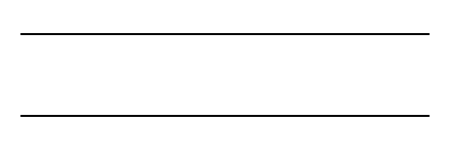

CrippenTuple(name='C6', smarts='[CH1](=C)[A;!#1]', logp_contrib=0.1551, mr_contrib=3.513)

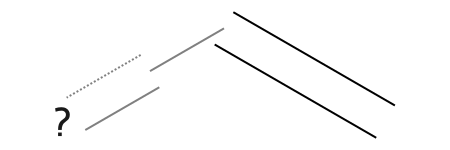

CrippenTuple(name='C6', smarts='[CH0](=C)([A;!#1])[A;!#1]', logp_contrib=0.1551, mr_contrib=3.513)

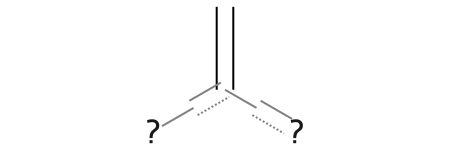

CrippenTuple(name='C6', smarts='[C](=C)=C', logp_contrib=0.1551, mr_contrib=3.513)

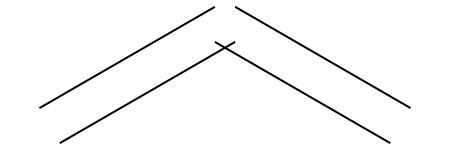

CrippenTuple(name='C16', smarts='[c][#35]', logp_contrib=0.198, mr_contrib=3.18)

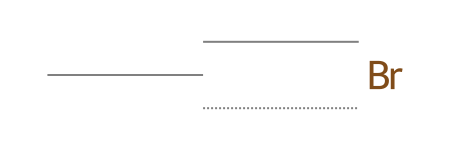

CrippenTuple(name='C18', smarts='[cH]', logp_contrib=0.1581, mr_contrib=3.35)

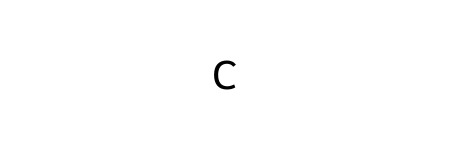

CrippenTuple(name='C24', smarts='[c](:a)(:a)-S', logp_contrib=0.1893, mr_contrib=2.673)

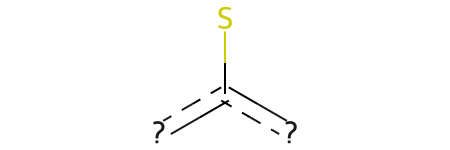

CrippenTuple(name='N6', smarts='[N+0](=[!#1;A,a])[!#1;A,a]', logp_contrib=0.1836, mr_contrib=2.428)

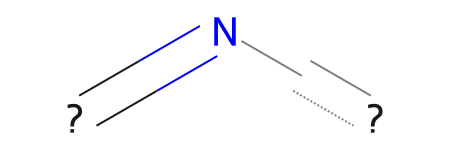

CrippenTuple(name='O1', smarts='[o]', logp_contrib=0.1552, mr_contrib=1.08)

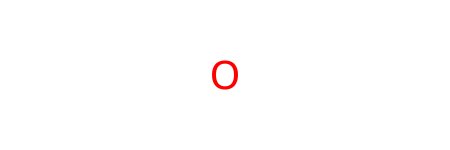

CrippenTuple(name='O8', smarts='[O]=c', logp_contrib=0.1788, mr_contrib=3.135)

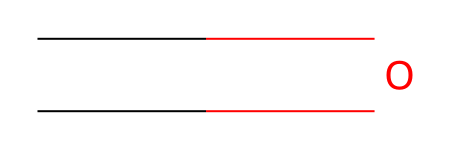

In [66]:
for at in sub:
    mol = Chem.MolFromSmarts(at[1])
    display(at, mol)

In [43]:
print(Descriptors.PEOE_VSA1.__doc__)

MOE Charge VSA Descriptor 1 (-inf < x < -0.30)


In [67]:
smarts = [
    'C(~O)(:C)',
    'N-C-C:C-C',
    'C-C:C-O-C',
    'C=C-C:C',
    'N(~C)(~C)',
    'O=C-C-C:C',
    'O-C-C-C:C',
    'N(~C)(~H)',
    'C(~C)(~N)',
]

img = Draw.MolsToGridImage( [Chem.MolFromSmarts(s) for s in smarts], molsPerRow=5, legends=[s for s in smarts] )  
img

[21:33:41] SMARTS Parse Error: syntax error while parsing: N(~C)(~H)
[21:33:41] SMARTS Parse Error: Failed parsing SMARTS 'N(~C)(~H)' for input: 'N(~C)(~H)'


In [ ]:
143 >= 1 any ring size 5
